This notebook determines the recovery rates of discharge events for icpc detector types.

**Contents:**

**Section 1:** Extracts all the discharge events. This process has previously been conducted in the notebook `CUTS_SELECTION_CRITERIA.ipynb`.

**Section 2:** This section calculates the recovery rates, similar to `RECOVERY_RATES_DETECTORS(2).ipynb` with one if statement difference.

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

## Section 1

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T004658Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "icpc"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

In [6]:
tb_data_dict = {}  
wfs_all_dict = {}  

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]

    min_values = []
    
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    min_z_scores = zscore(min_values)
    
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    for i, z_score in enumerate(min_z_scores):
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    for i, z_score in enumerate(max_z_scores):
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [14]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

Skipped waveforms for detector ch1104000: [382, 1166]
Percentage of discharges present: 0.14174344436569397%
Skipped waveforms for detector ch1104001: [247, 1166]
Percentage of discharges present: 0.14174344436569397%
Skipped waveforms for detector ch1104002: [24, 1231]
Percentage of discharges present: 0.14174344436569397%
Skipped waveforms for detector ch1104003: [24, 1231]
Percentage of discharges present: 0.14174344436569397%
This detector ch1104004 doesn't have any discharges
This detector ch1104005 doesn't have any discharges
Skipped waveforms for detector ch1105600: [243, 1198]
Percentage of discharges present: 0.14174344436569397%
This detector ch1105602 doesn't have any discharges
This detector ch1105603 doesn't have any discharges
This detector ch1108802 doesn't have any discharges
This detector ch1108803 doesn't have any discharges
This detector ch1108804 doesn't have any discharges
Skipped waveforms for detector ch1115200: [685]
Percentage of discharges present: 0.070871722

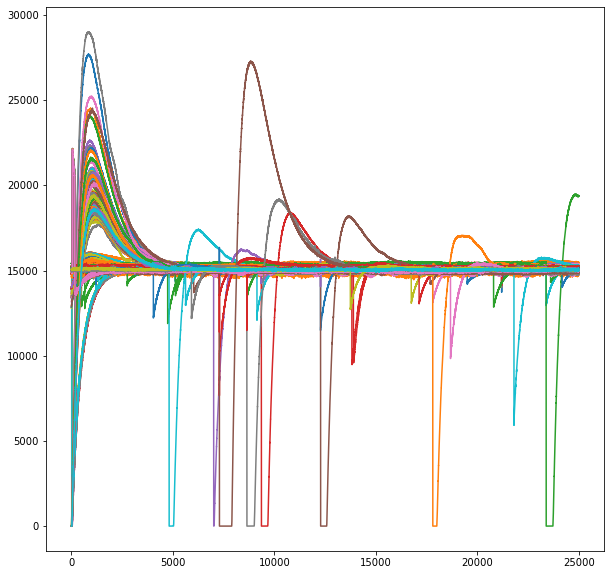

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1 
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            plt.plot(ts[:], wf0[:], label=f'Event {i}') 

        # Customize plot
        #plt.xlabel('Time ($\mu s$)')
        #plt.ylabel('Voltage (mV)')
        #plt.title(f'Skipped events in detector {j} which is a {test}')
        #plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Another selection criteria which states that if the size of the skipped indices is larger than 20, after the 2 cuts, this suggests we have no discharges.

In [16]:
detector_events ={}
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    events = []
    detector_events[j]=events 
    for i in range(len(wfs_all)):
        wf0=wfs_all[i,:]
        if np.any(wf0[:]==0):
            events.append(i)

In [17]:
final_events = {}
for j in detectors_bege:
    all_zeros = detector_events[j]
    try:
        all_events = skipped_waveforms[j]
    except KeyError:
        all_events =[]
    
    combo=all_zeros+all_events
    final = np.unique(combo)
    final_events[j]=final 

In [18]:
import pandas as pd

df = pd.DataFrame(columns=['Detector Name', 'Percentage of discharge events'])

percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = final_events[j]

    if len(index_skip1) < 20: 
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:] #removes the ch from the detector name 
            test = cmap[x]['type'] #searches the type of detector the detector is 

            #plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            #plt.xlabel('Time ($\mu s$)')
            #plt.ylabel('Voltage (mV)')
            #plt.title(f'Skipped events in detector {j} which is a {test}')
            #plt.legend()
            #plt.show()

        diff = len(minimum_dict[j]) - len(index_skip1) 
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        #print(f"Percentage of discharges present: {percentage}%")
        #plt.show() 
    else:
        #if the dataset has more than 20 data points then the data set has no discharges
        percent_discharge[j] = 0
        #print(f"This detector {j} doesn't have any discharges")

Skipped waveforms for detector ch1104000: [ 382 1166]
Skipped waveforms for detector ch1104001: [ 247 1166]
Skipped waveforms for detector ch1104002: [  24 1231]
Skipped waveforms for detector ch1104003: [  24 1231]
Skipped waveforms for detector ch1104004: []
Skipped waveforms for detector ch1104005: []
Skipped waveforms for detector ch1105600: [ 243 1198]
Skipped waveforms for detector ch1105602: []
Skipped waveforms for detector ch1105603: []
Skipped waveforms for detector ch1108802: []
Skipped waveforms for detector ch1108803: []
Skipped waveforms for detector ch1108804: []
Skipped waveforms for detector ch1115200: [685]
Skipped waveforms for detector ch1115201: [ 78 685 822]
Skipped waveforms for detector ch1115202: []
Skipped waveforms for detector ch1115203: []
Skipped waveforms for detector ch1115204: []
Skipped waveforms for detector ch1116801: [ 189  607  608  663 1052 1168 1332]
Skipped waveforms for detector ch1116802: [ 134  188  213  357  514  527  556  584  694  949  973

## Section 2

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 19502.4, 20399.2
Next Maximum difference: 20399.2, 20476.0


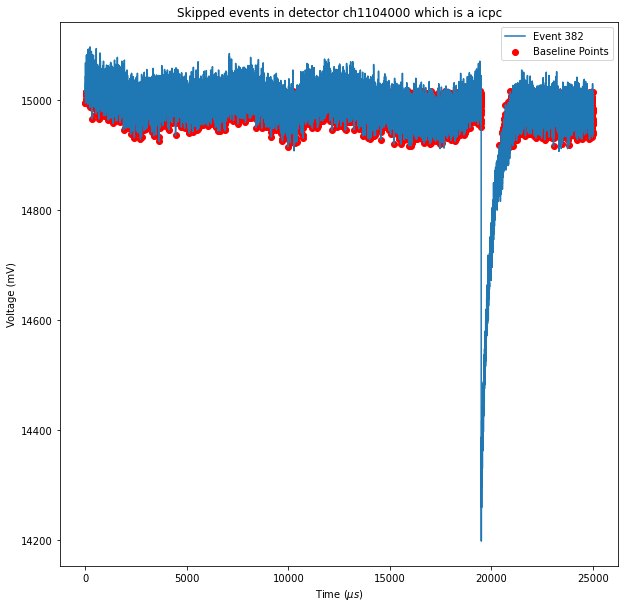

recovery rate -40.0s
MICRODISCHARGE
Maximum difference: 19.200000000000003, 865.6
Next Maximum difference: 905.6, 934.4000000000001


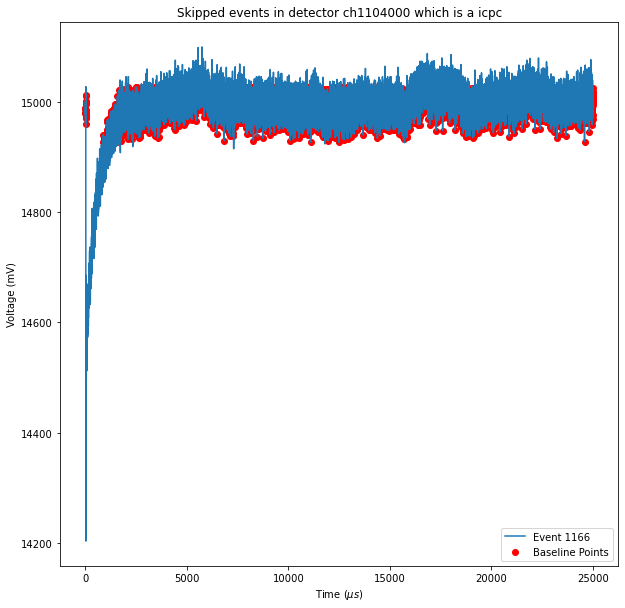

recovery rate -31.199999999999818s
MICRODISCHARGE
Maximum difference: 656.0, 2258.4
Next Maximum difference: 2289.6, 2329.6


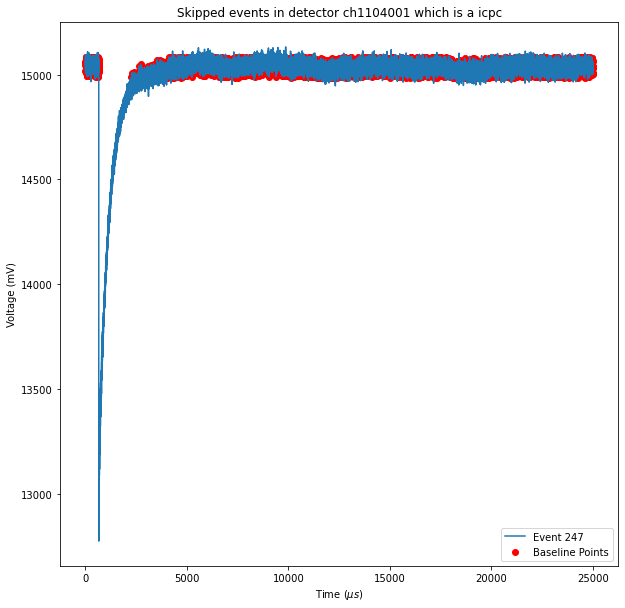

recovery rate -18.40000000000009s
DISCHARGE
Maximum difference: 19.200000000000003, 2548.0
Next maximum difference: 2566.4, 2606.4


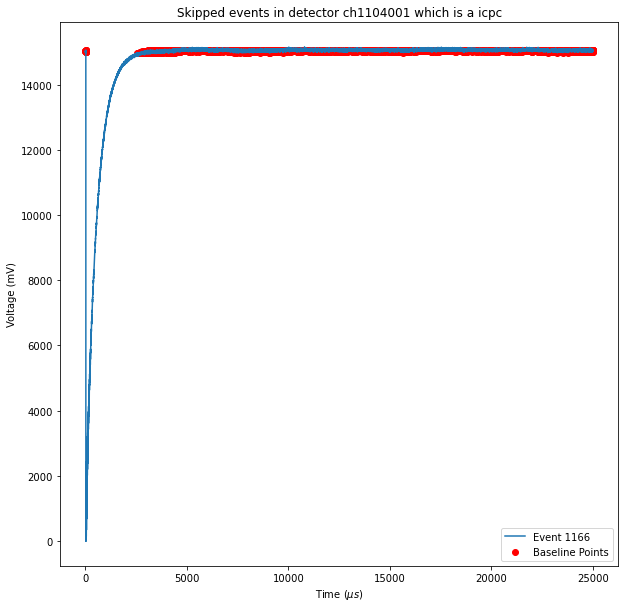

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 12.8, 1044.8
Next Maximum difference: 1044.8, 1138.4


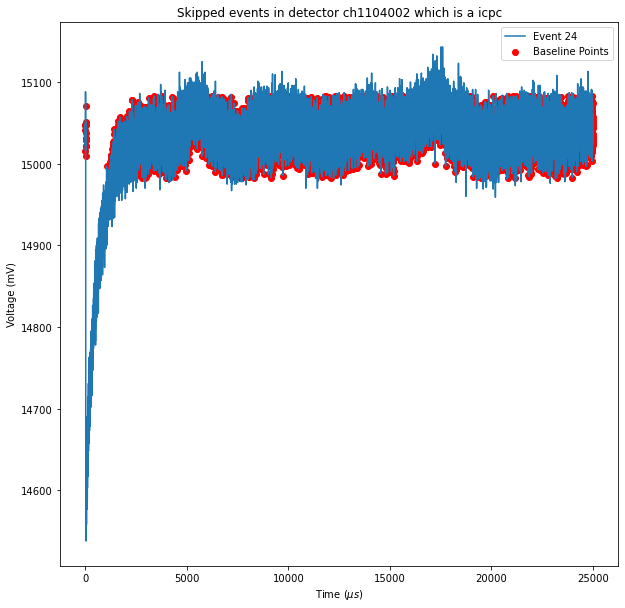

recovery rate -12.0s
MICRODISCHARGE
Maximum difference: 10.4, 725.6
Next Maximum difference: 737.6, 832.0


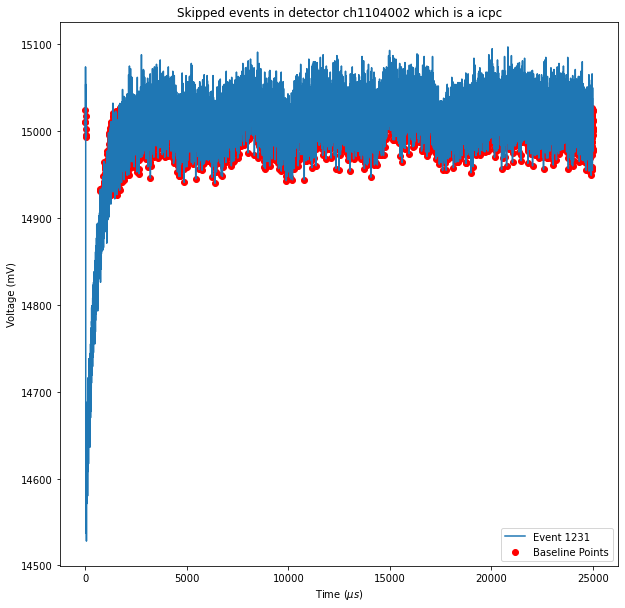

recovery rate -5264.799999999999s
DISCHARGE
Maximum difference: 12.8, 2431.2000000000003
Next maximum difference: 7696.0, 7716.0


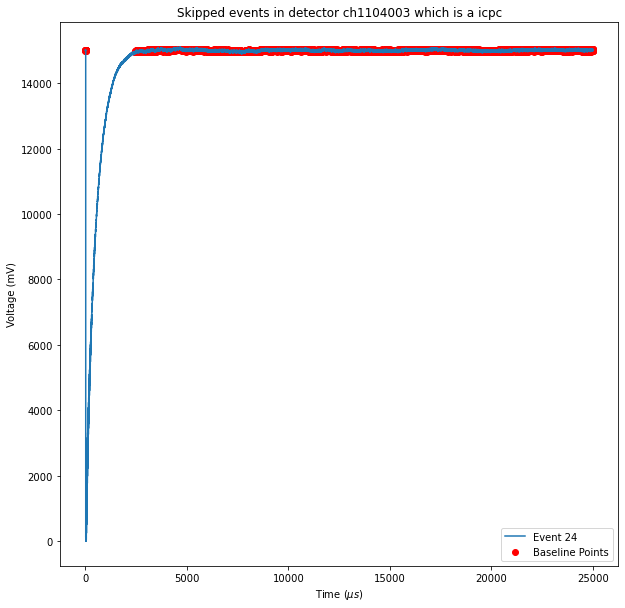

recovery rate -15.199999999999818s
DISCHARGE
Maximum difference: 12.8, 2852.8
Next maximum difference: 2868.0, 2883.2000000000003


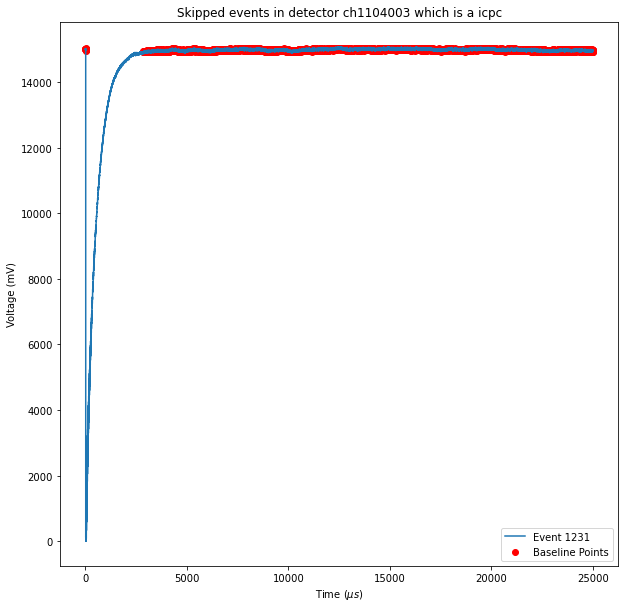

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 20.0, 2257.6
Next Maximum difference: 2257.6, 2303.2000000000003


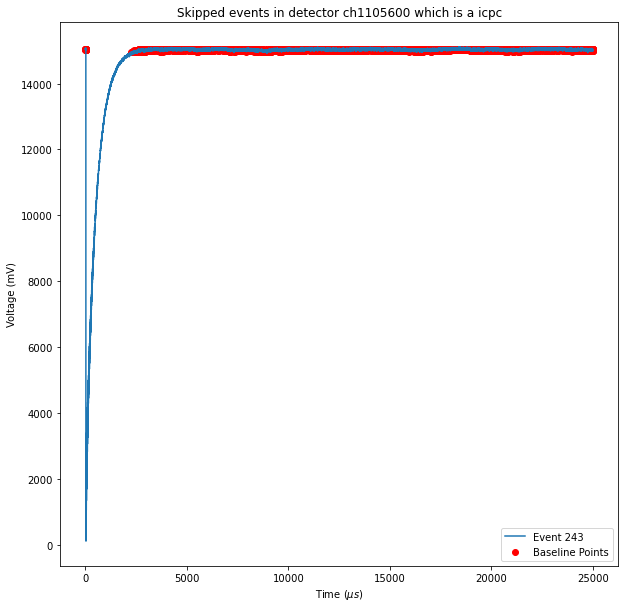

recovery rate 0.0s
DISCHARGE
Maximum difference: 19.200000000000003, 2506.4
Next maximum difference: 2506.4, 2556.8


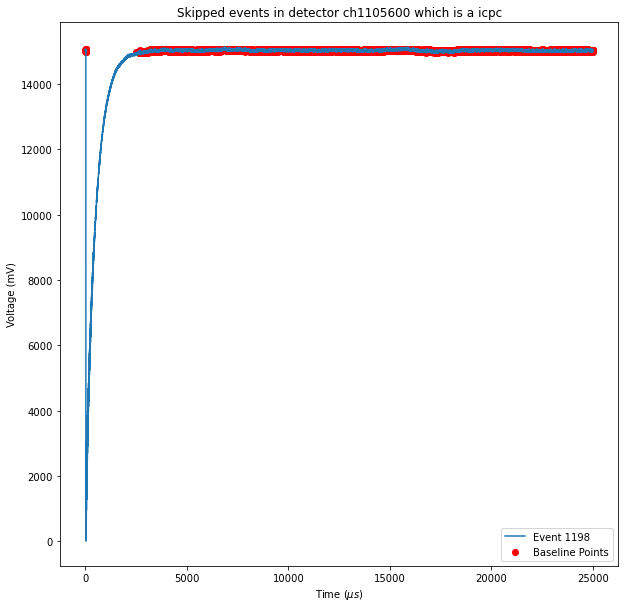

recovery rate -44.0s
MICRODISCHARGE
Maximum difference: 5122.400000000001, 5163.200000000001
Next Maximum difference: 5207.200000000001, 5228.0


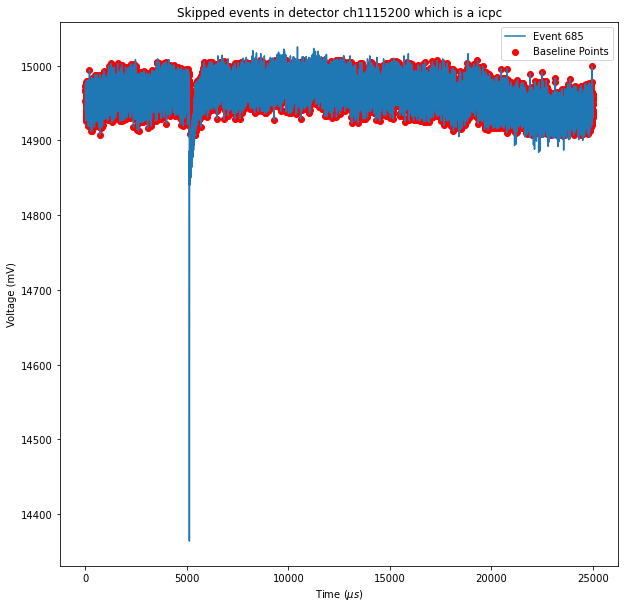

recovery rate 3096.0s
MICRODISCHARGE
Maximum difference: 23289.600000000002, 23366.4
Next Maximum difference: 20270.4, 20339.2


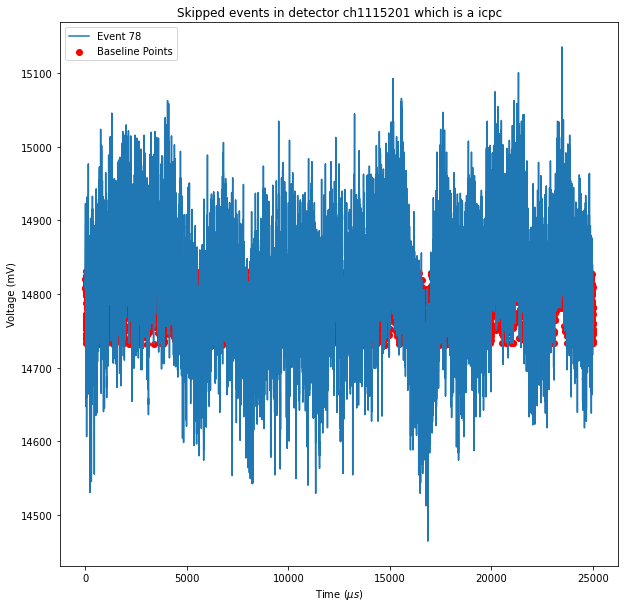

recovery rate 16131.2s
MICRODISCHARGE
Maximum difference: 15207.2, 16131.2
Next Maximum difference: 5114.400000000001, 5740.8


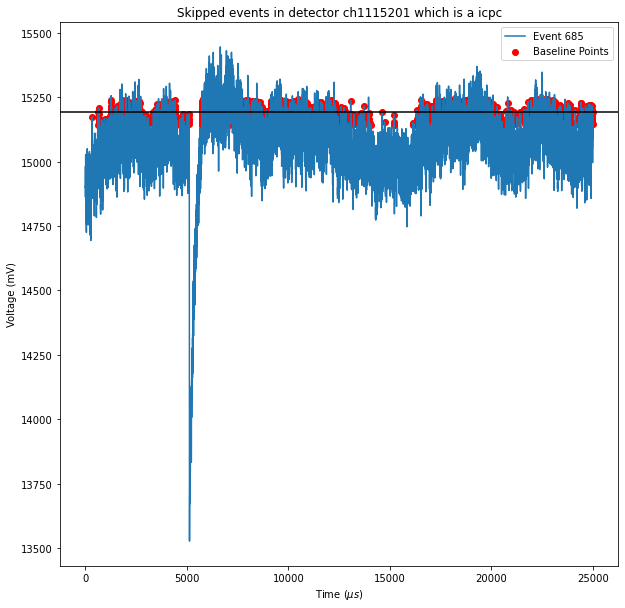

recovery rate 8320.0s
MICRODISCHARGE
Maximum difference: 6443.200000000001, 8320.0
Next Maximum difference: 15526.400000000001, 16121.6


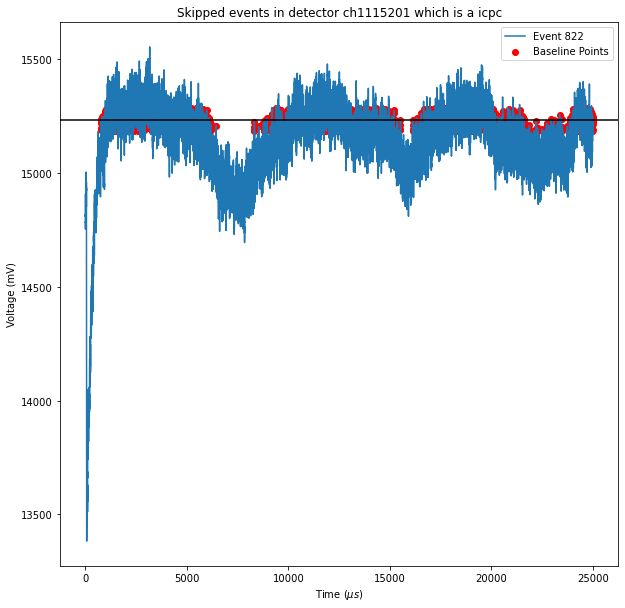

recovery rate 5716.8s
DISCHARGE
Maximum difference: 370.40000000000003, 5716.8
Next maximum difference: 6555.200000000001, 7482.400000000001


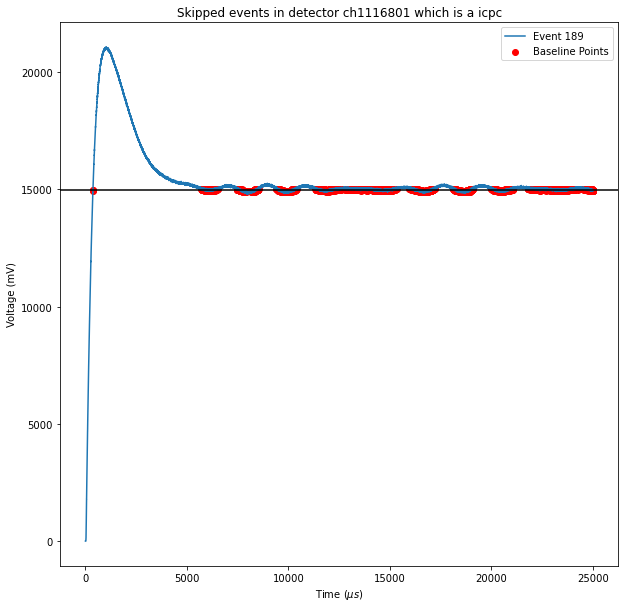

recovery rate 5148.0s
DISCHARGE
Maximum difference: 513.6, 5148.0
Next maximum difference: 5148.0, 5269.6


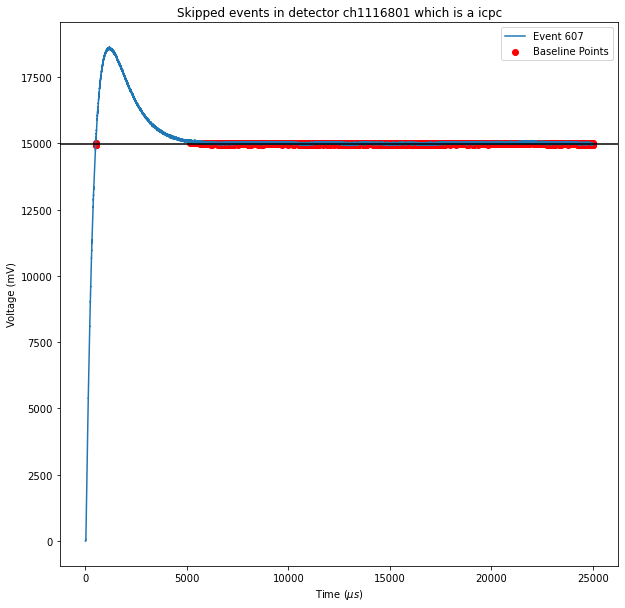

recovery rate 5233.6s
DISCHARGE
Maximum difference: 441.6, 5233.6
Next maximum difference: 5963.200000000001, 6360.0


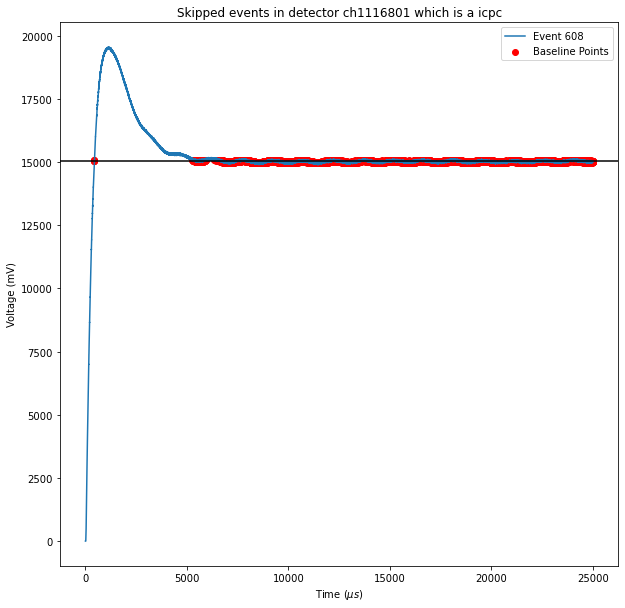

recovery rate 5185.6s
DISCHARGE
Maximum difference: 429.6, 5185.6
Next maximum difference: 9913.6, 10359.2


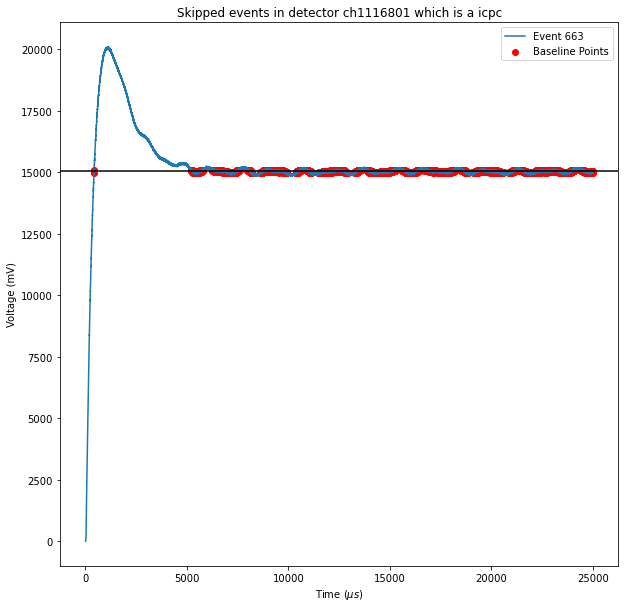

recovery rate 5864.8s
MICRODISCHARGE
Maximum difference: 512.0, 5864.8
Next Maximum difference: 21380.0, 21454.4


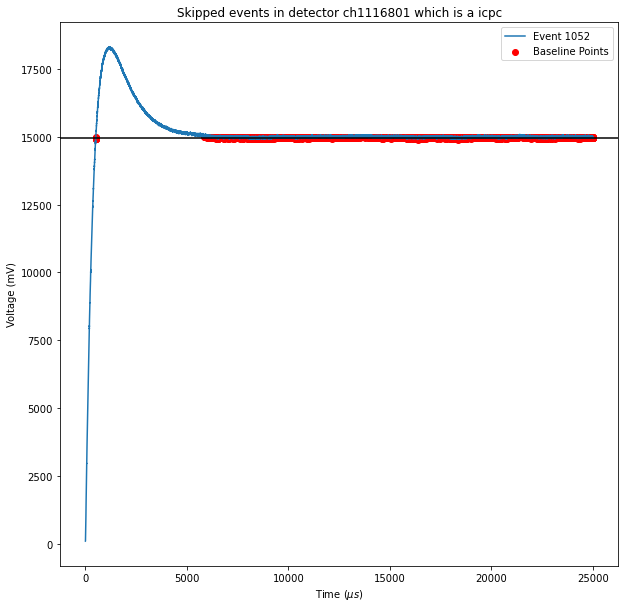

recovery rate 24412.0s
MICRODISCHARGE
Maximum difference: 24396.0, 24412.0
Next Maximum difference: 24381.600000000002, 24396.0


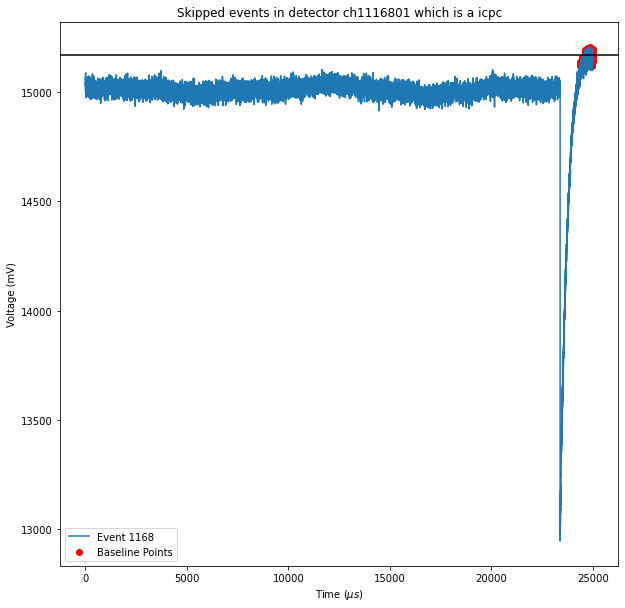

recovery rate 5480.8s
DISCHARGE
Maximum difference: 520.0, 5480.8
Next maximum difference: 7824.8, 8506.4


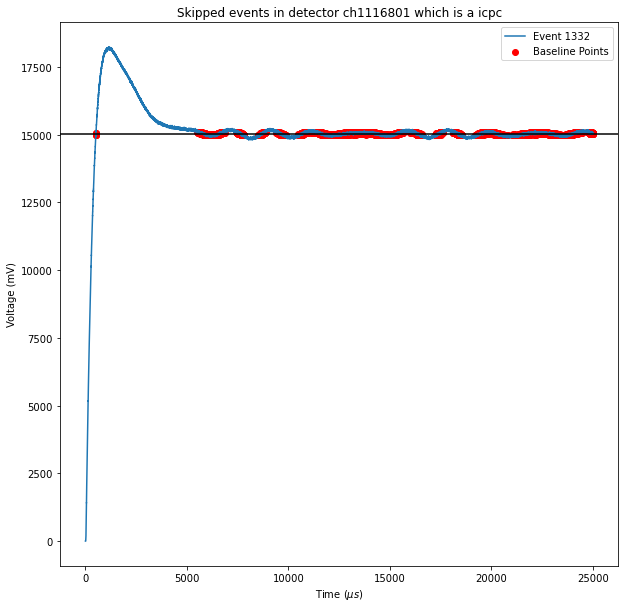

recovery rate 19364.8s
MICRODISCHARGE
Maximum difference: 15793.6, 19364.8
Next Maximum difference: 372.0, 3388.8


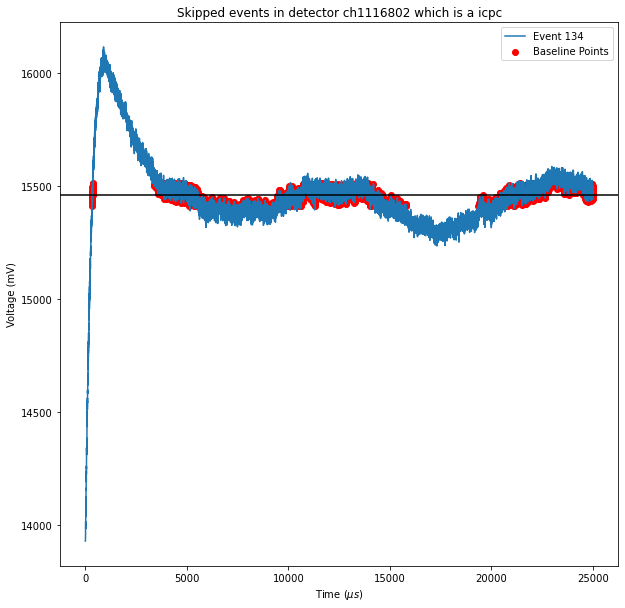

recovery rate 13690.400000000001s
MICRODISCHARGE
Maximum difference: 7344.8, 13690.400000000001
Next Maximum difference: 18012.0, 23326.4


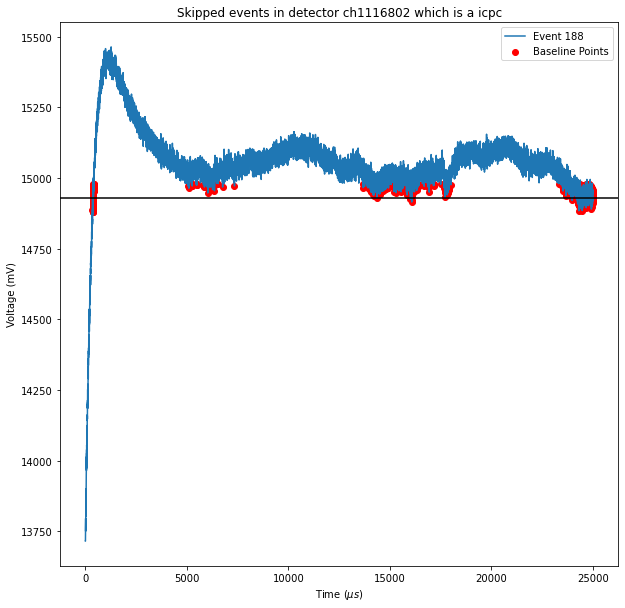

recovery rate 2052.8s
MICRODISCHARGE
Maximum difference: 511.20000000000005, 2052.8
Next Maximum difference: 16895.2, 17897.600000000002


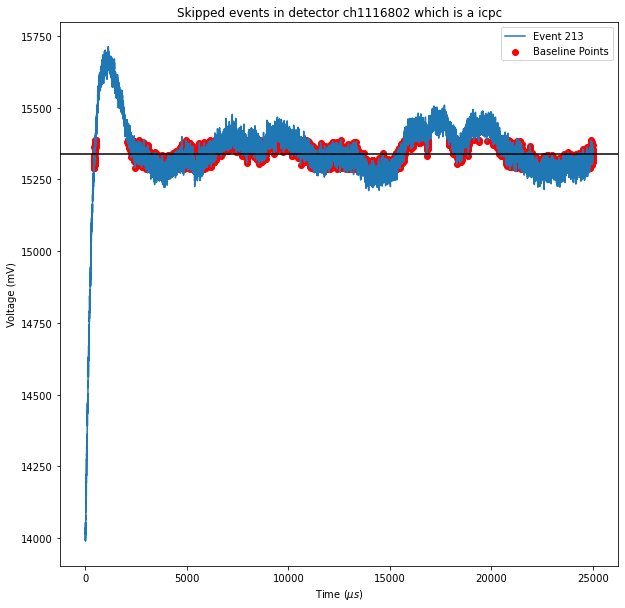

recovery rate 5094.400000000001s
DISCHARGE
Maximum difference: 508.8, 5094.400000000001
Next maximum difference: 19499.2, 21670.4


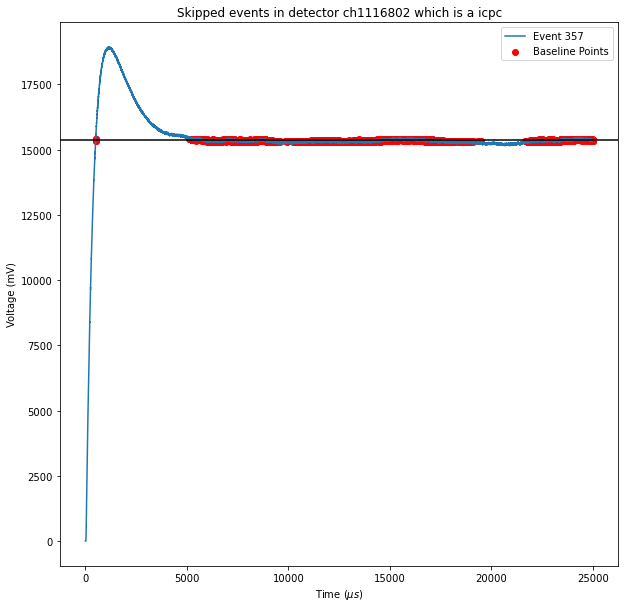

recovery rate 8394.4s
MICRODISCHARGE
Maximum difference: 2670.4, 8394.4
Next Maximum difference: 12656.800000000001, 14684.0


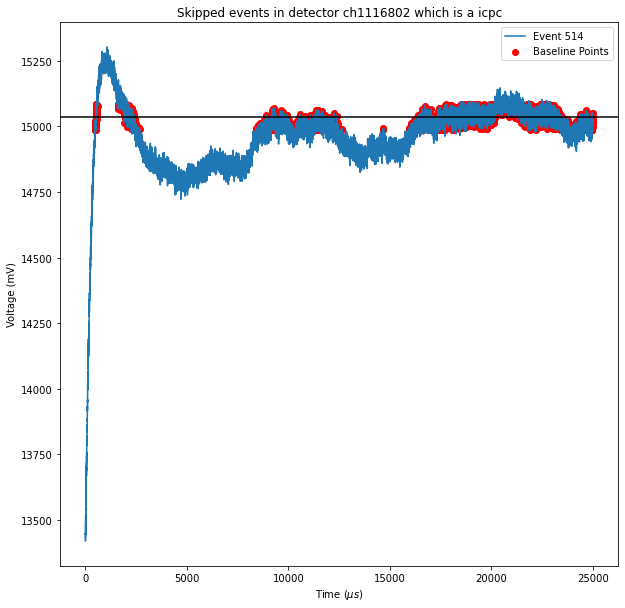

recovery rate 12196.0s
MICRODISCHARGE
Maximum difference: 3284.8, 12196.0
Next Maximum difference: 15285.6, 22448.0


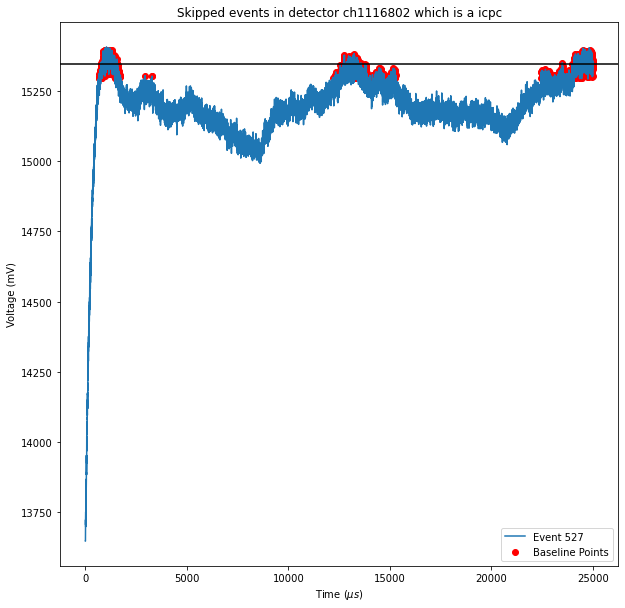

recovery rate 22336.0s
MICRODISCHARGE
Maximum difference: 16063.2, 22336.0
Next Maximum difference: 7156.8, 11783.2


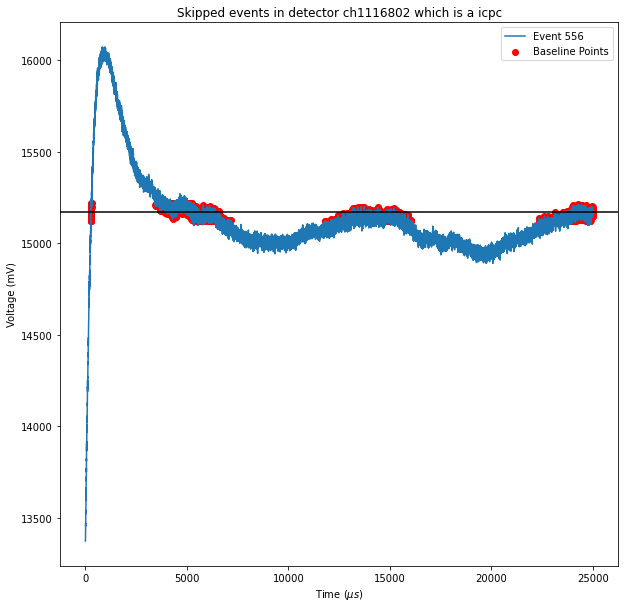

recovery rate 11477.6s
MICRODISCHARGE
Maximum difference: 328.8, 11477.6
Next Maximum difference: 18597.600000000002, 21238.4


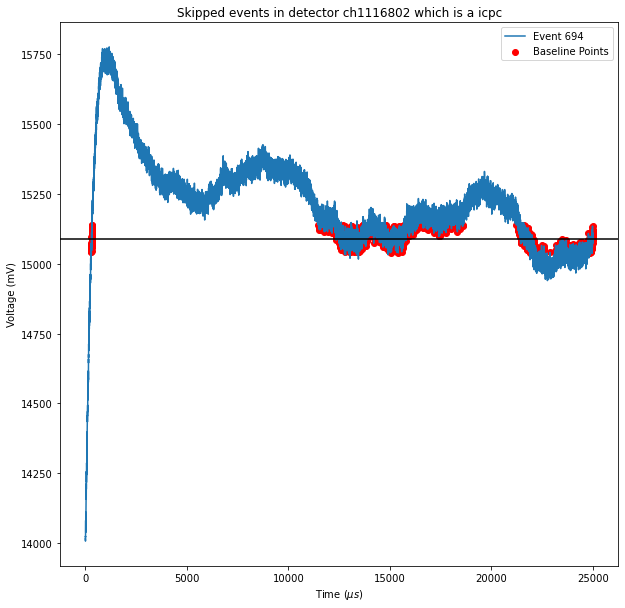

recovery rate 3569.6000000000004s
MICRODISCHARGE
Maximum difference: 305.6, 3569.6000000000004
Next Maximum difference: 7704.8, 10027.2


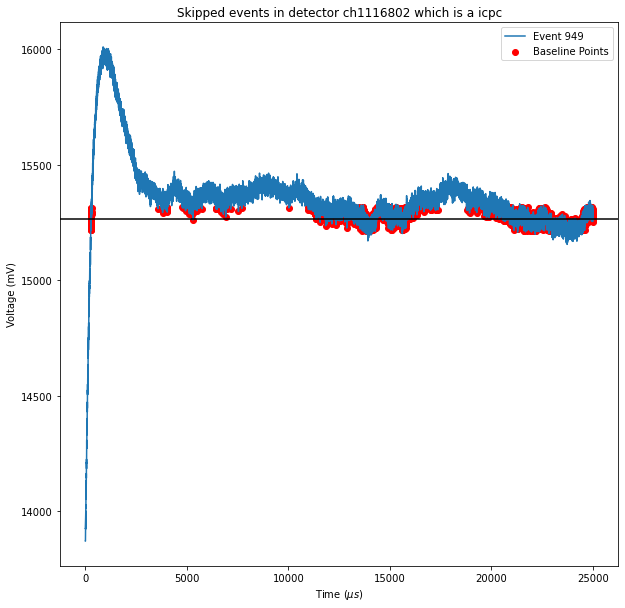

recovery rate -170.40000000000146s
MICRODISCHARGE
Maximum difference: 10836.0, 13076.0
Next Maximum difference: 13246.400000000001, 15311.2


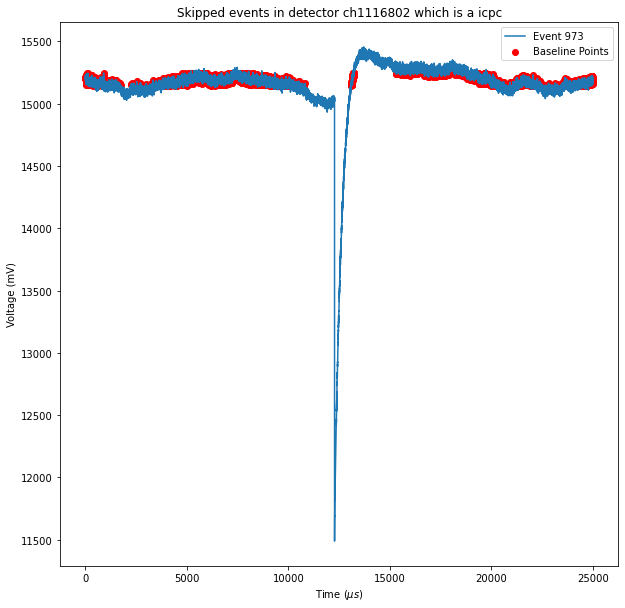

recovery rate 2968.8s
MICRODISCHARGE
Maximum difference: 313.6, 2968.8
Next Maximum difference: 18866.4, 21044.0


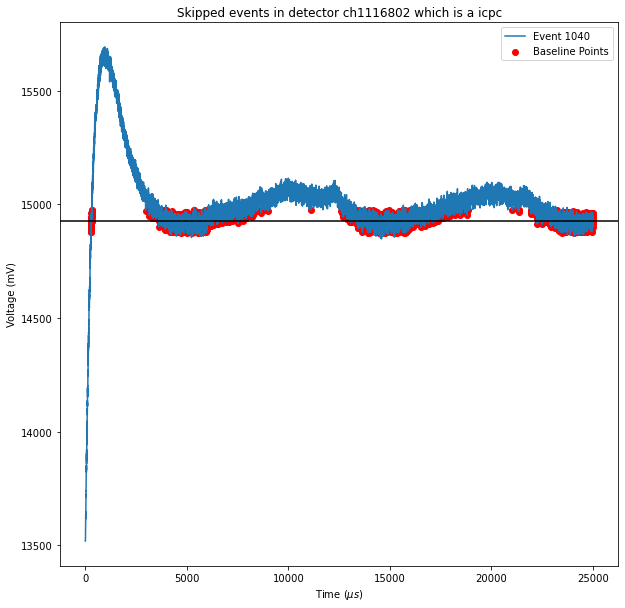

recovery rate 24885.600000000002s
DISCHARGE
Maximum difference: 24877.600000000002, 24885.600000000002
Next maximum difference: 24803.2, 24808.800000000003


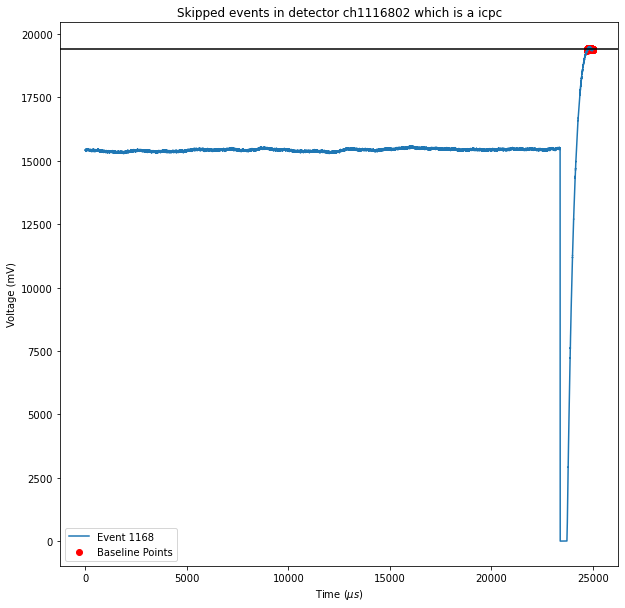

recovery rate 2582.3999999999996s
MICRODISCHARGE
Maximum difference: 14749.6, 16475.2
Next Maximum difference: 13892.800000000001, 14675.2


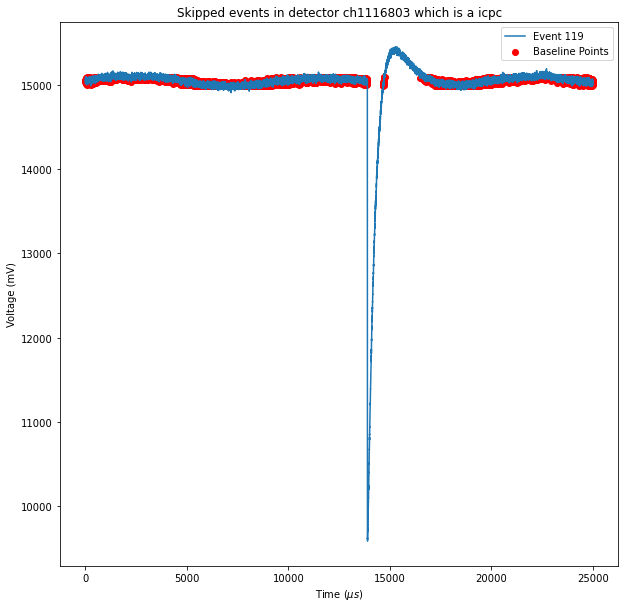

recovery rate 5092.8s
DISCHARGE
Maximum difference: 310.40000000000003, 5092.8
Next maximum difference: 14403.2, 17840.0


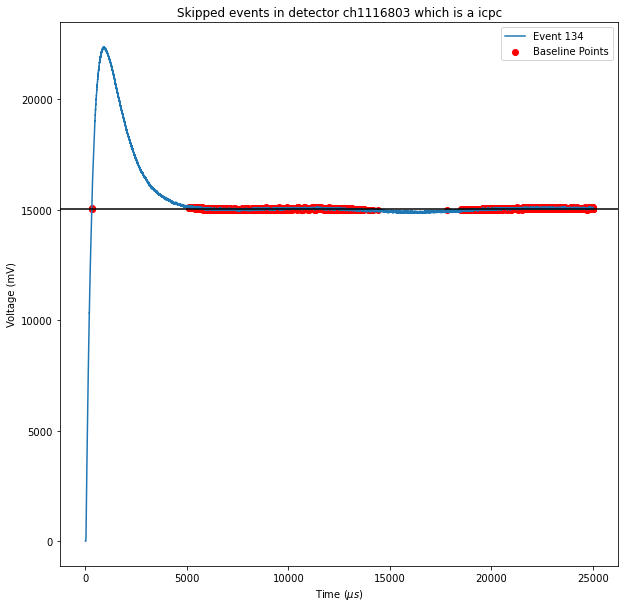

recovery rate 4838.400000000001s
DISCHARGE
Maximum difference: 484.0, 4838.400000000001
Next maximum difference: 18510.4, 21048.0


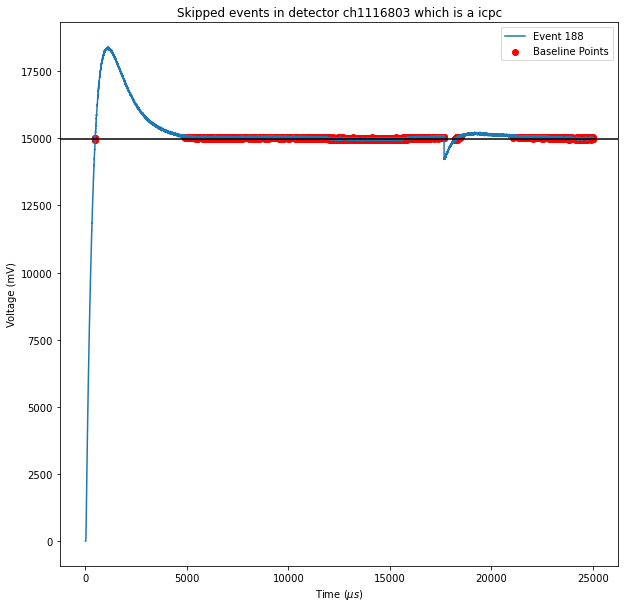

recovery rate 4095.2000000000003s
DISCHARGE
Maximum difference: 487.20000000000005, 4095.2000000000003
Next maximum difference: 11602.400000000001, 14043.2


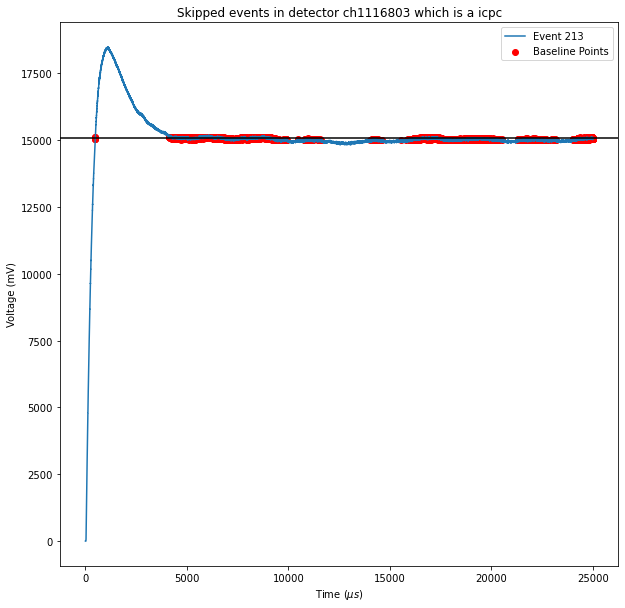

recovery rate 4443.2s
DISCHARGE
Maximum difference: 540.8000000000001, 4443.2
Next maximum difference: 13795.2, 16560.0


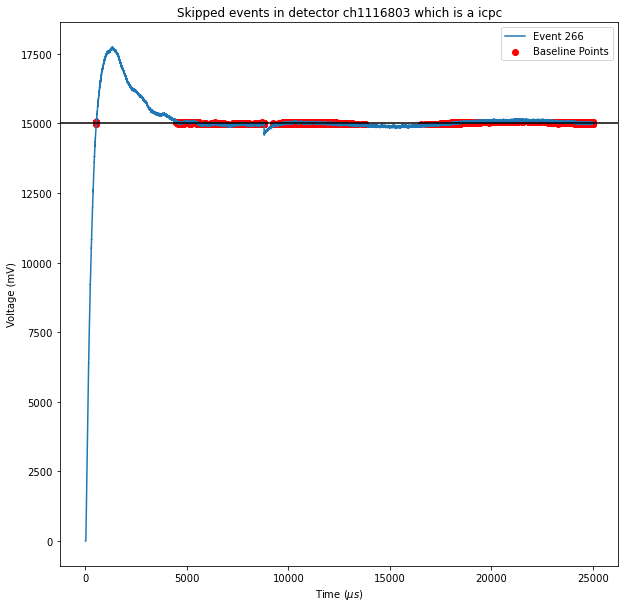

recovery rate 4700.8s
DISCHARGE
Maximum difference: 406.40000000000003, 4700.8
Next maximum difference: 19038.4, 20088.800000000003


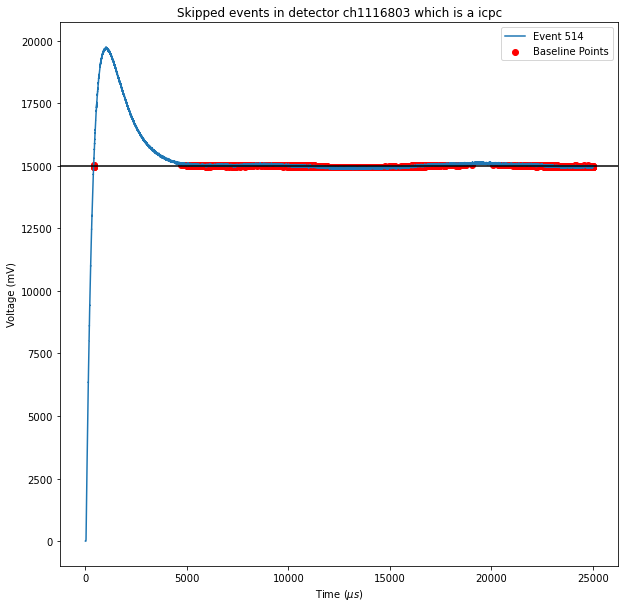

recovery rate 21596.800000000003s
DISCHARGE
Maximum difference: 15176.800000000001, 21596.800000000003
Next maximum difference: 451.20000000000005, 4948.8


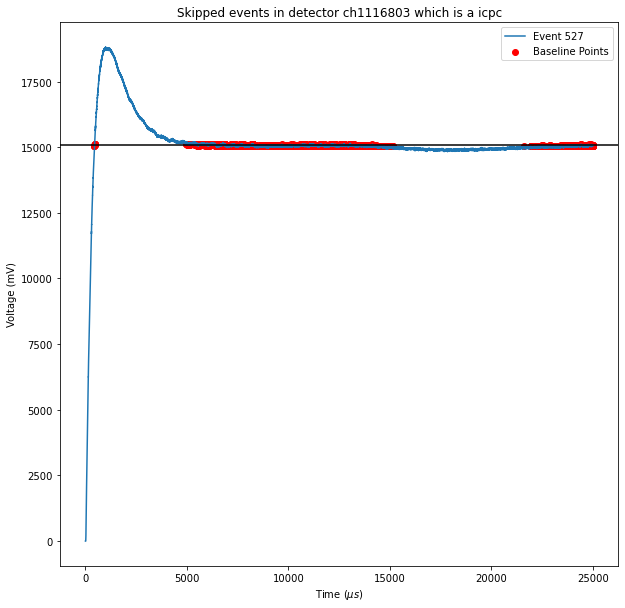

recovery rate 20854.4s
DISCHARGE
Maximum difference: 15224.800000000001, 20854.4
Next maximum difference: 220.8, 5351.200000000001


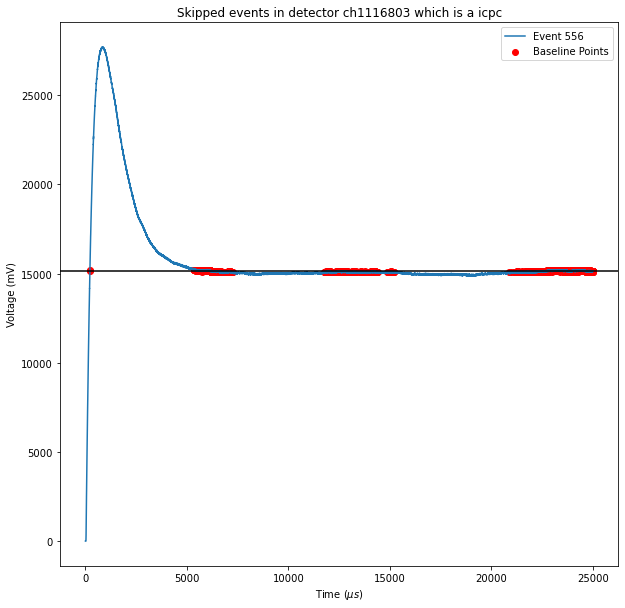

recovery rate 4348.8s
DISCHARGE
Maximum difference: 466.40000000000003, 4348.8
Next maximum difference: 18591.2, 19776.800000000003


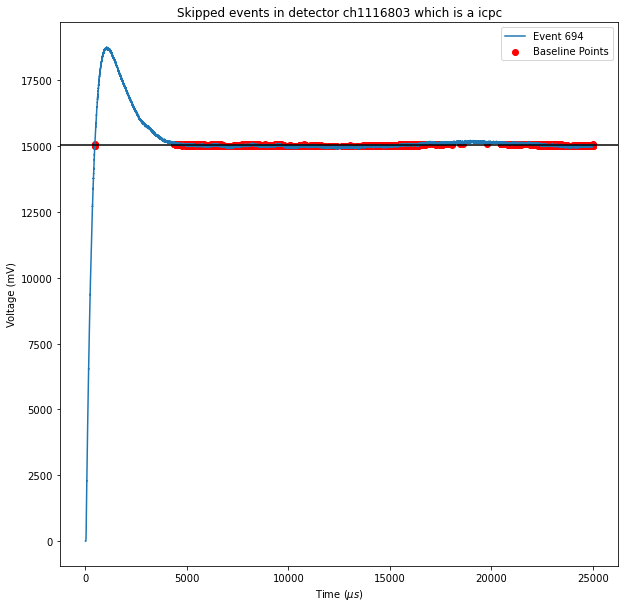

recovery rate 2214.4s
MICRODISCHARGE
Maximum difference: 1359.2, 2704.8
Next Maximum difference: 490.40000000000003, 1141.6000000000001


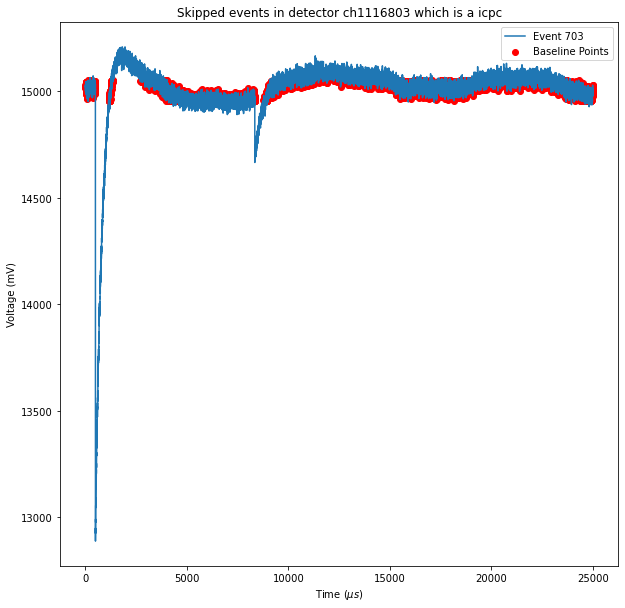

recovery rate 2812.7999999999993s
MICRODISCHARGE
Maximum difference: 14659.2, 16632.8
Next Maximum difference: 13820.0, 14606.400000000001


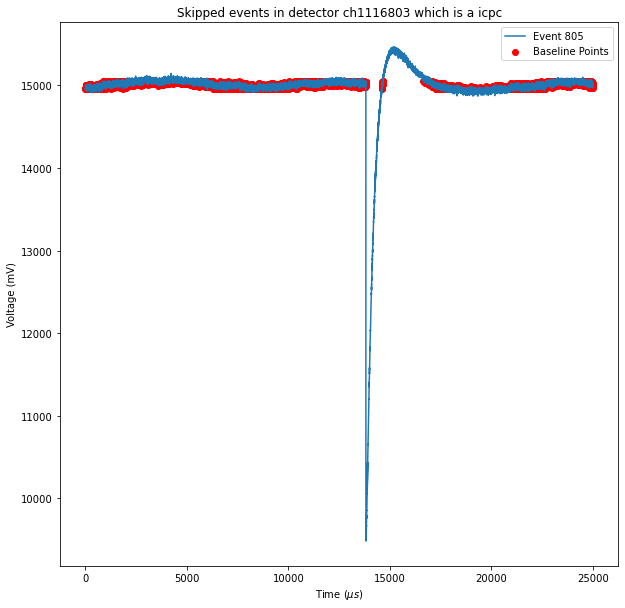

recovery rate 5760.8s
DISCHARGE
Maximum difference: 296.0, 5760.8
Next maximum difference: 6676.0, 10687.2


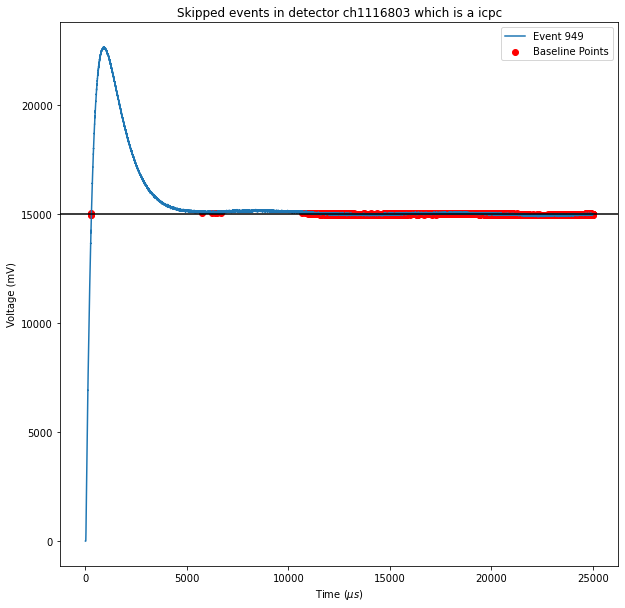

recovery rate 12259.2s
DISCHARGE
Maximum difference: 13058.400000000001, 18919.2
Next maximum difference: 6660.0, 7517.6


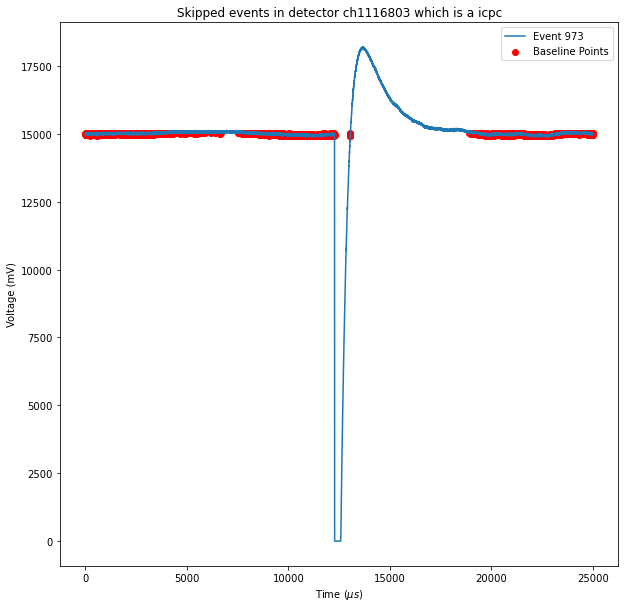

recovery rate 15284.800000000001s
MICRODISCHARGE
Maximum difference: 11737.6, 15284.800000000001
Next Maximum difference: 590.4, 2380.8


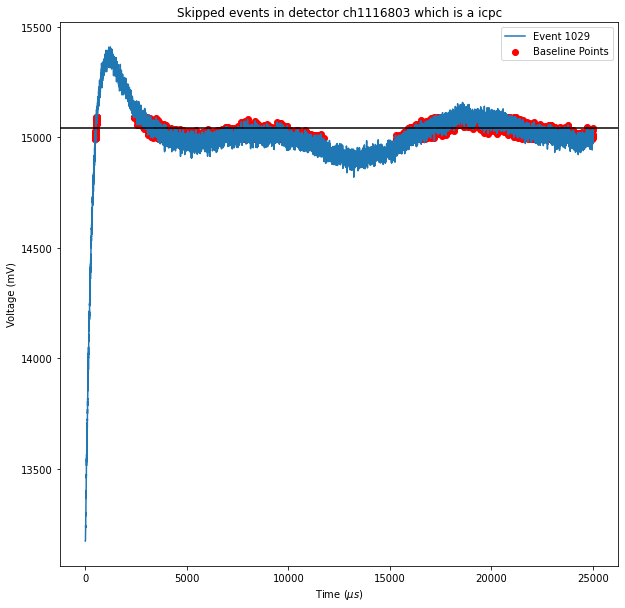

recovery rate 5216.0s
DISCHARGE
Maximum difference: 313.6, 5216.0
Next maximum difference: 8184.8, 10089.6


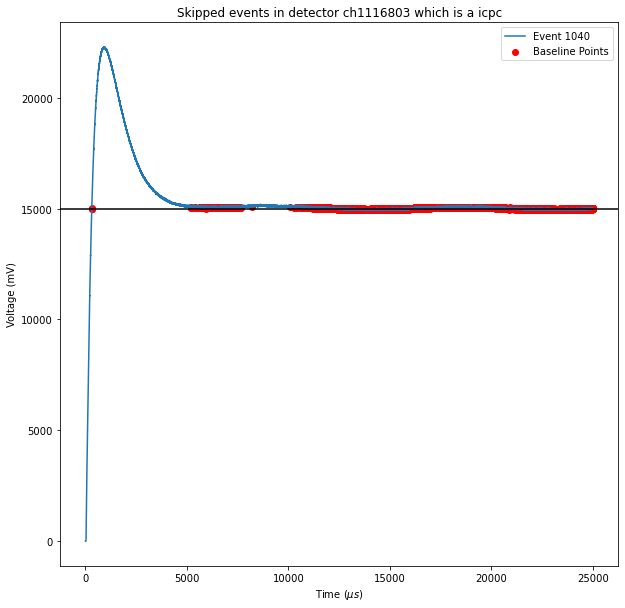

recovery rate -6326.399999999998s
MICRODISCHARGE
Maximum difference: 6272.0, 11202.400000000001
Next Maximum difference: 17528.8, 19947.2


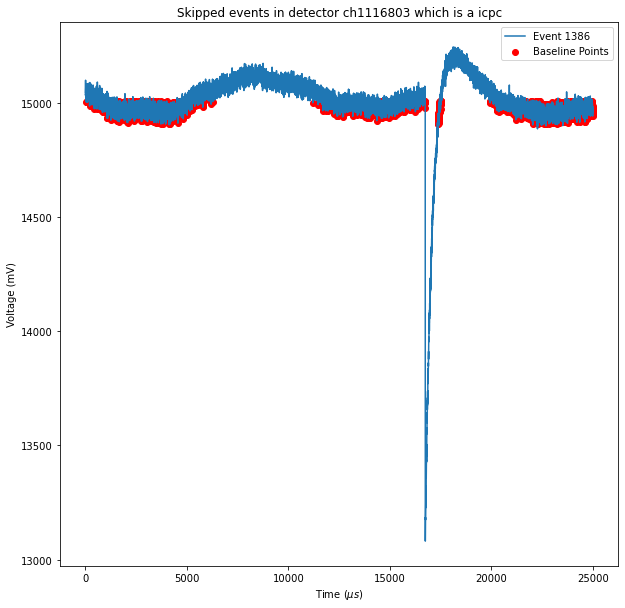

recovery rate 24557.600000000002s
MICRODISCHARGE
Maximum difference: 22728.0, 24557.600000000002
Next Maximum difference: 24575.2, 24609.600000000002


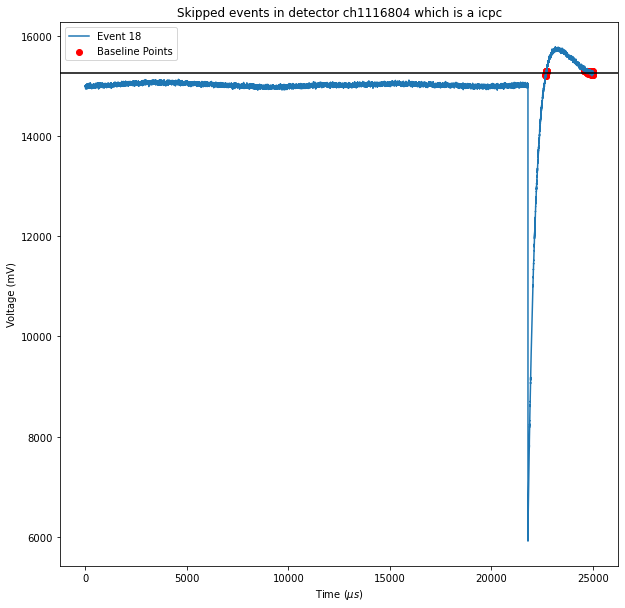

recovery rate 5382.400000000001s
DISCHARGE
Maximum difference: 385.6, 5382.400000000001
Next maximum difference: 5382.400000000001, 5644.8


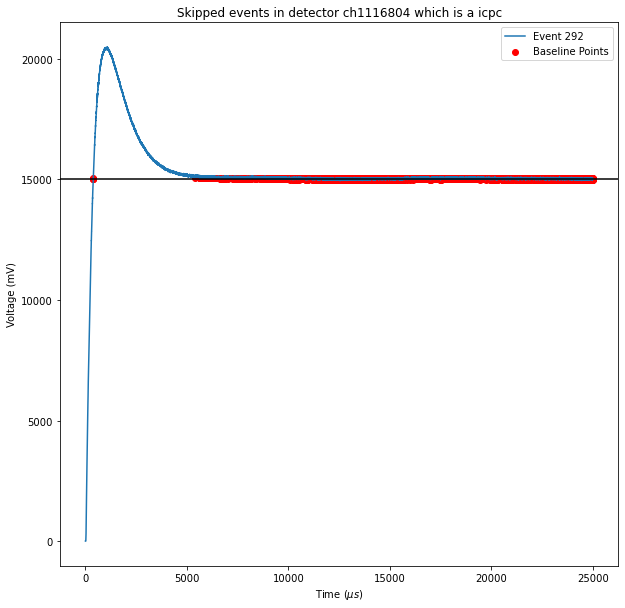

recovery rate 5604.0s
DISCHARGE
Maximum difference: 272.8, 5604.0
Next maximum difference: 11438.400000000001, 11563.2


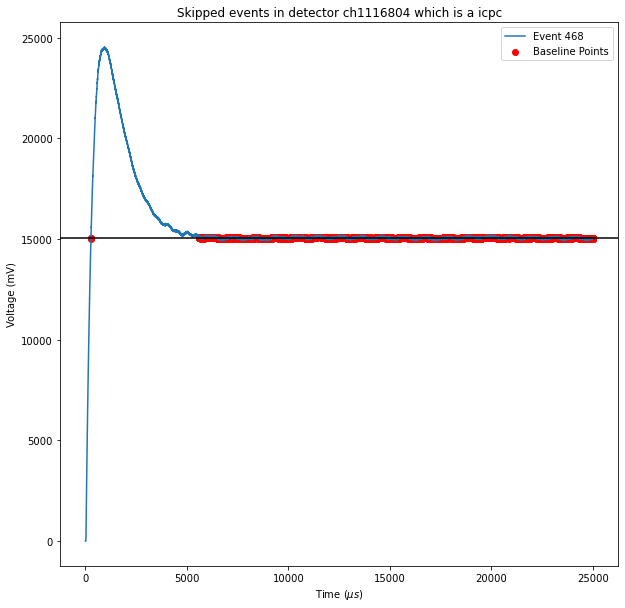

recovery rate 5779.200000000001s
DISCHARGE
Maximum difference: 280.0, 5779.200000000001
Next maximum difference: 5800.8, 5844.8


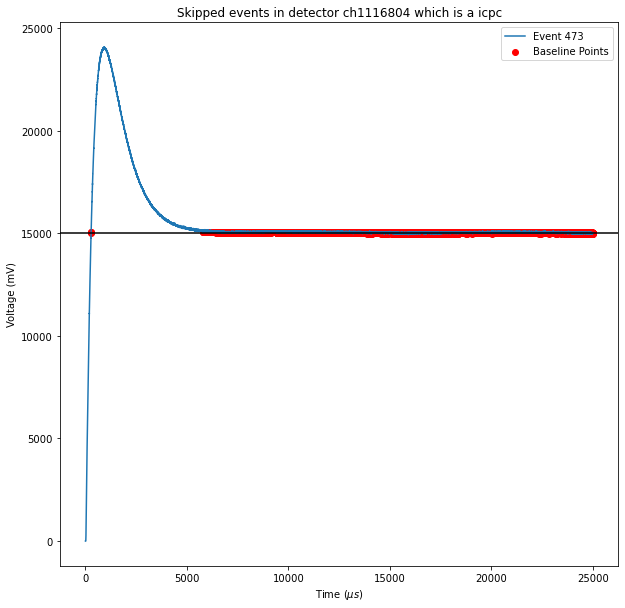

recovery rate 5299.200000000001s
DISCHARGE
Maximum difference: 432.0, 5299.200000000001
Next maximum difference: 5299.200000000001, 5404.0


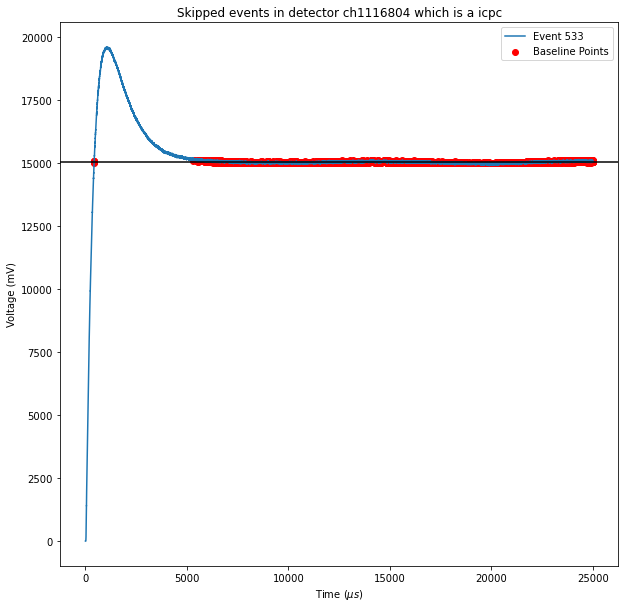

recovery rate 5520.0s
DISCHARGE
Maximum difference: 408.8, 5520.0
Next maximum difference: 5548.8, 5646.400000000001


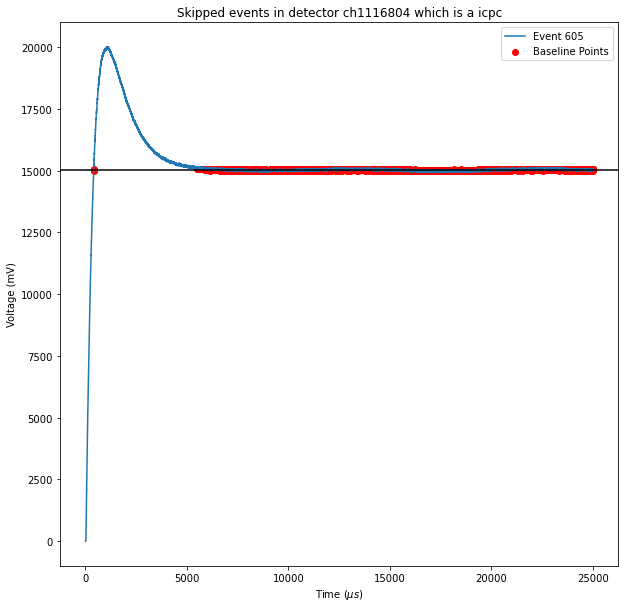

recovery rate 4685.6s
DISCHARGE
Maximum difference: 488.0, 4685.6
Next maximum difference: 14072.800000000001, 14139.2


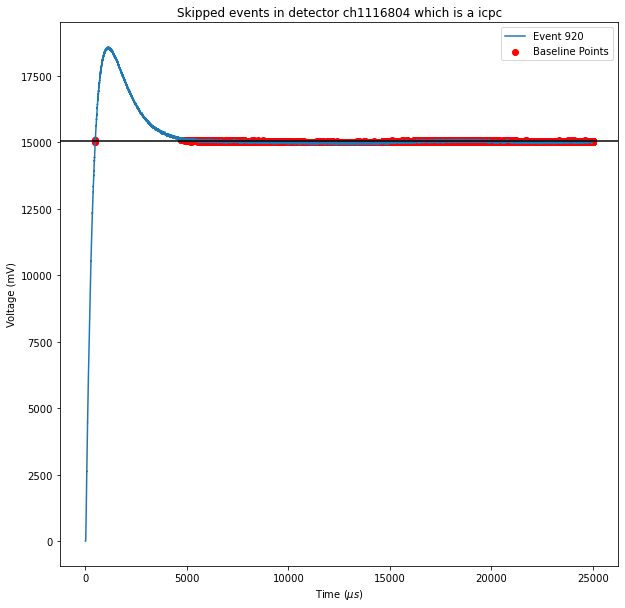

recovery rate 5355.200000000001s
DISCHARGE
Maximum difference: 397.6, 5355.200000000001
Next maximum difference: 5412.8, 5504.8


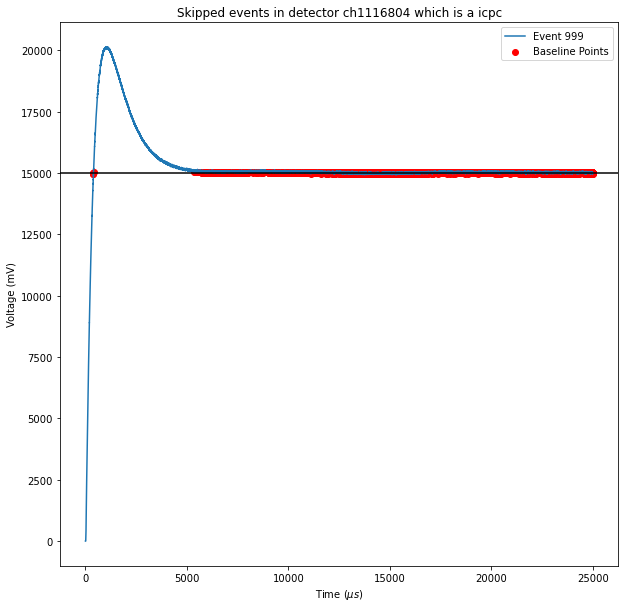

recovery rate 5372.8s
DISCHARGE
Maximum difference: 206.4, 5372.8
Next maximum difference: 5459.200000000001, 5806.400000000001


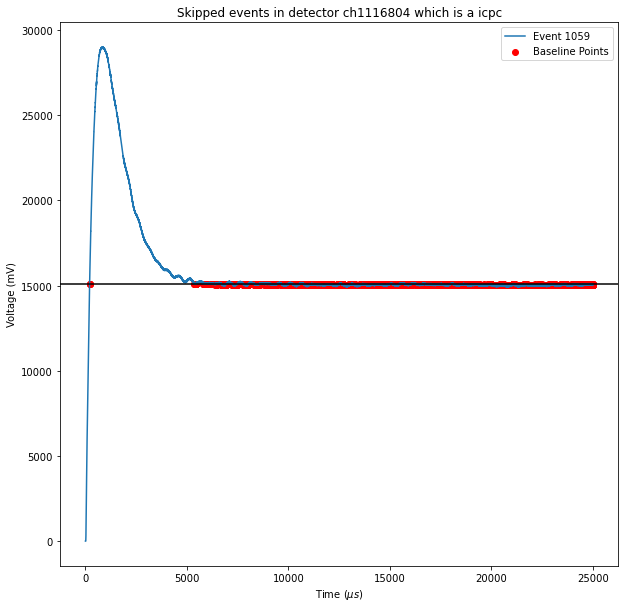

recovery rate 4918.400000000001s
DISCHARGE
Maximum difference: 452.0, 4918.400000000001
Next maximum difference: 4933.6, 5111.200000000001


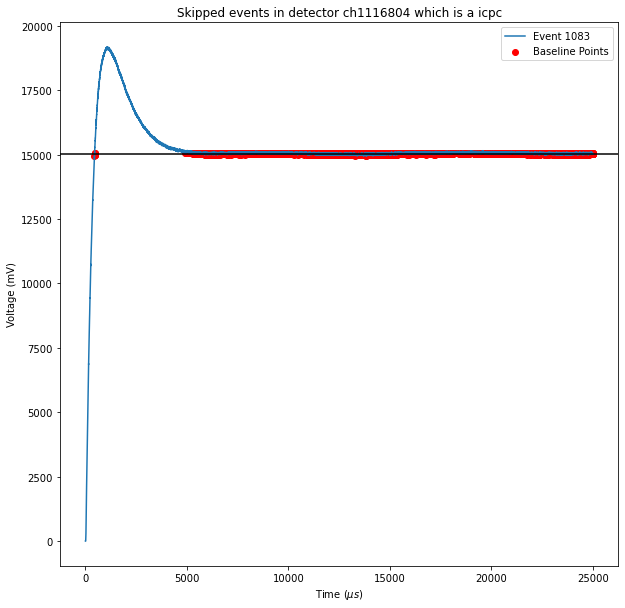

recovery rate 5031.200000000001s
DISCHARGE
Maximum difference: 372.0, 5031.200000000001
Next maximum difference: 5080.8, 5248.0


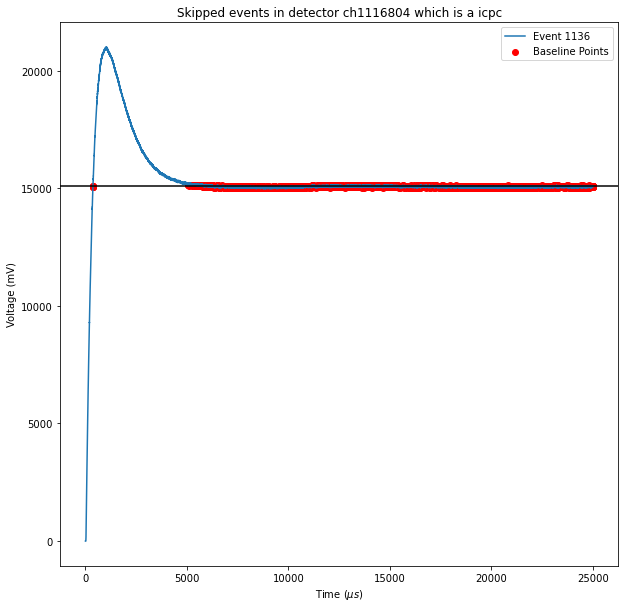

recovery rate 5699.200000000001s
DISCHARGE
Maximum difference: 326.40000000000003, 5699.200000000001
Next maximum difference: 5721.6, 5748.0


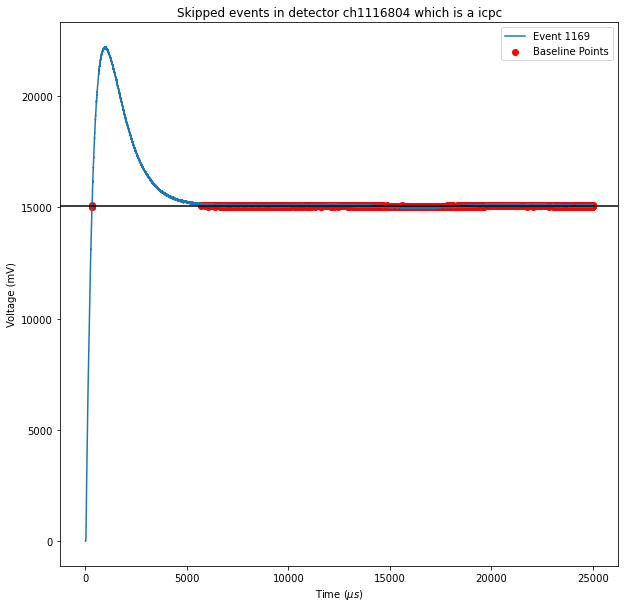

recovery rate 5397.6s
DISCHARGE
Maximum difference: 329.6, 5397.6
Next maximum difference: 5436.8, 5543.200000000001


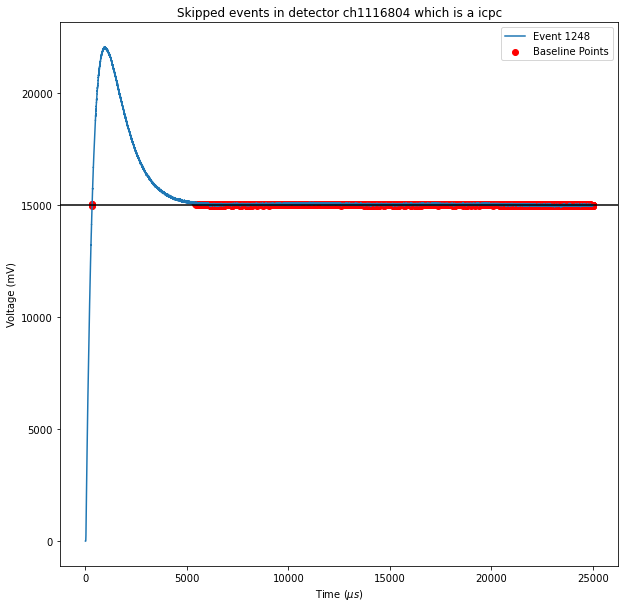

recovery rate 3145.6000000000004s
MICRODISCHARGE
Maximum difference: 5615.200000000001, 7887.200000000001
Next Maximum difference: 4741.6, 5465.6


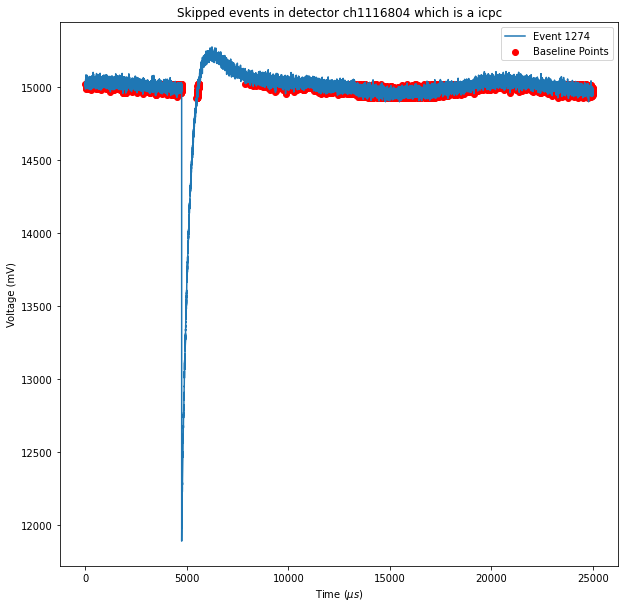

recovery rate 3630.4000000000015s
MICRODISCHARGE
Maximum difference: 18020.0, 20762.4
Next Maximum difference: 17132.0, 17811.2


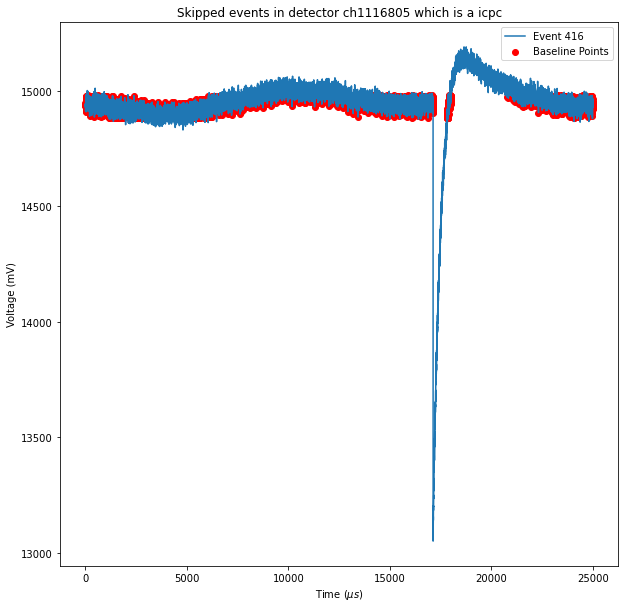

recovery rate 1250.3999999999996s
MICRODISCHARGE
Maximum difference: 12267.2, 12636.0
Next Maximum difference: 11385.6, 11433.6


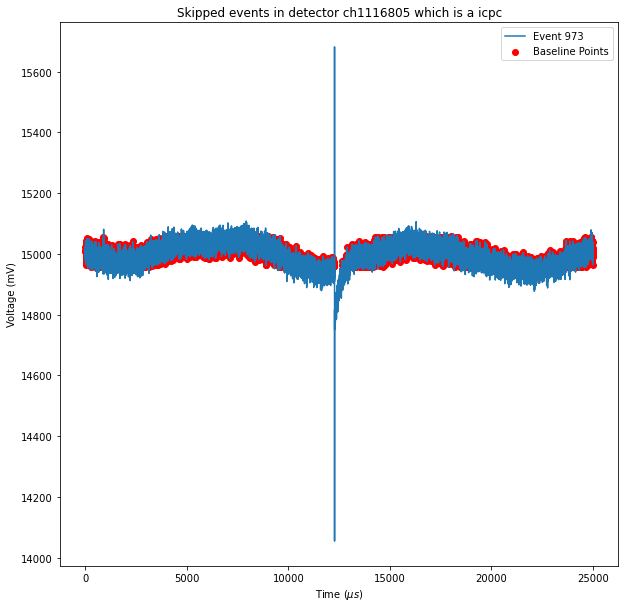

recovery rate 5211.200000000001s
DISCHARGE
Maximum difference: 494.40000000000003, 5211.200000000001
Next maximum difference: 12182.400000000001, 12438.400000000001


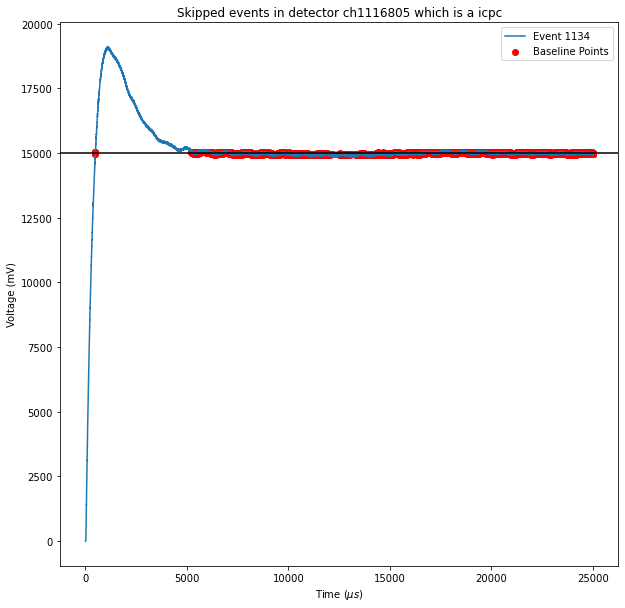

recovery rate 4868.0s
DISCHARGE
Maximum difference: 535.2, 4868.0
Next maximum difference: 14108.0, 15083.2


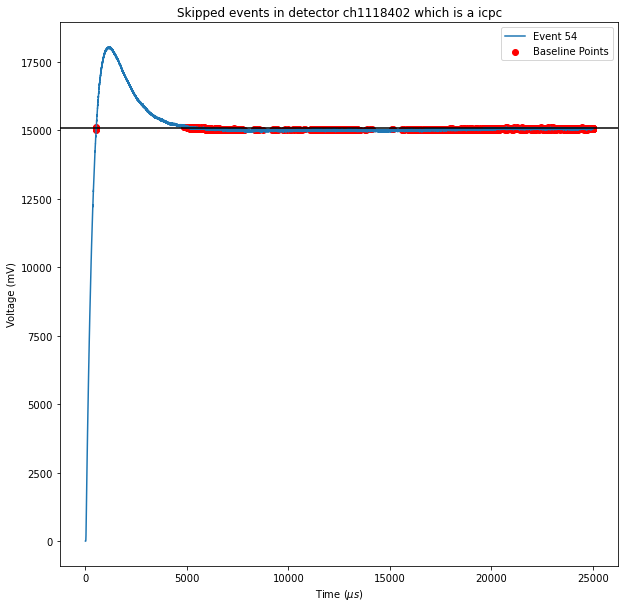

recovery rate 4983.200000000001s
DISCHARGE
Maximum difference: 416.0, 4983.200000000001
Next maximum difference: 5120.8, 5168.8


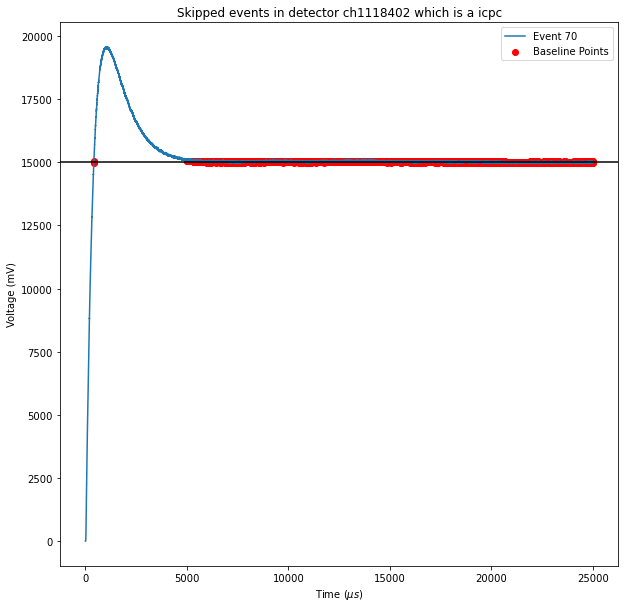

recovery rate 3268.0s
MICRODISCHARGE
Maximum difference: 341.6, 3268.0
Next Maximum difference: 7755.200000000001, 7786.400000000001


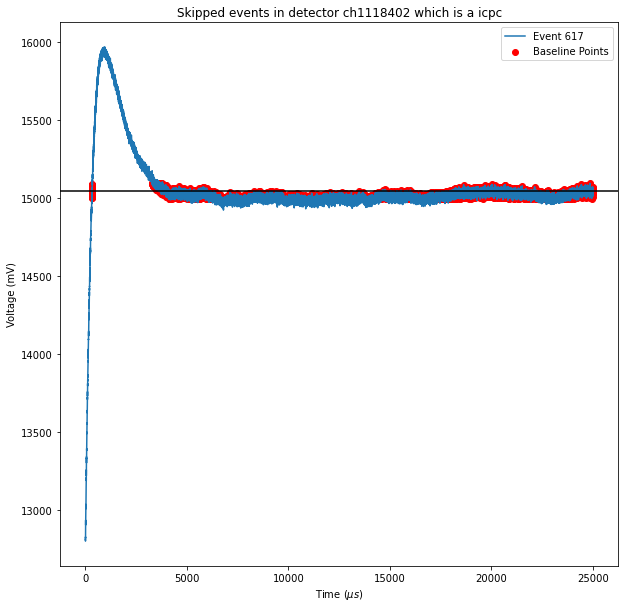

recovery rate 4700.8s
DISCHARGE
Maximum difference: 5616.0, 9511.2
Next maximum difference: 4810.400000000001, 5604.0


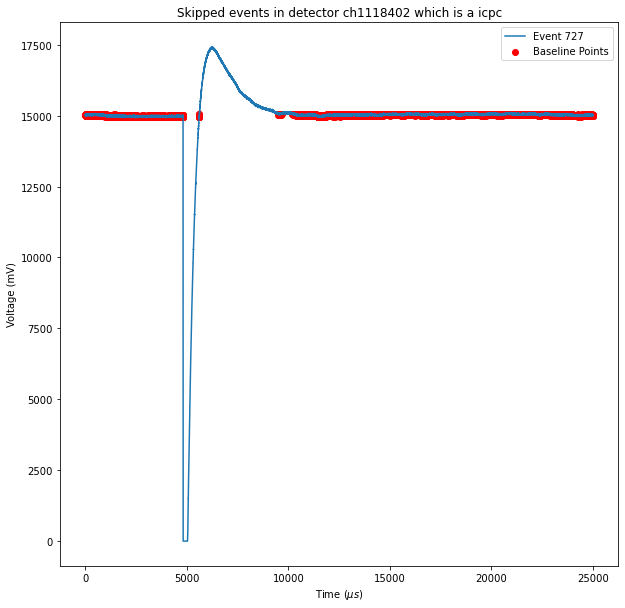

recovery rate 3836.0s
MICRODISCHARGE
Maximum difference: 367.20000000000005, 3836.0
Next Maximum difference: 3912.8, 3940.0


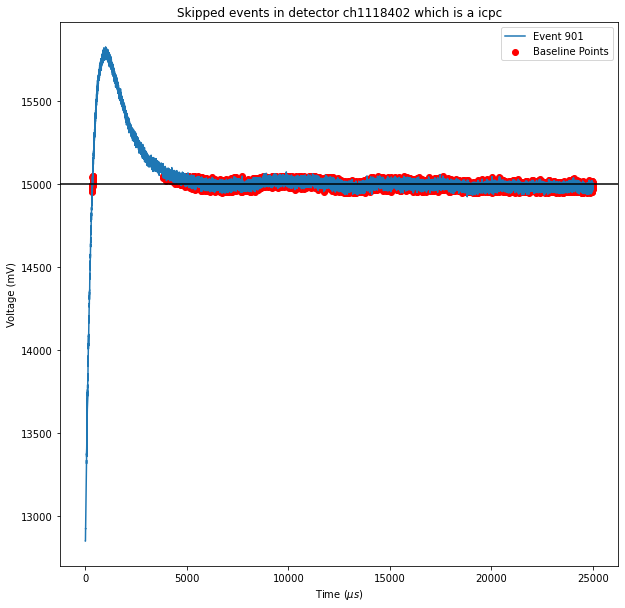

recovery rate 5362.400000000001s
DISCHARGE
Maximum difference: 388.0, 5362.400000000001
Next maximum difference: 5362.400000000001, 5424.0


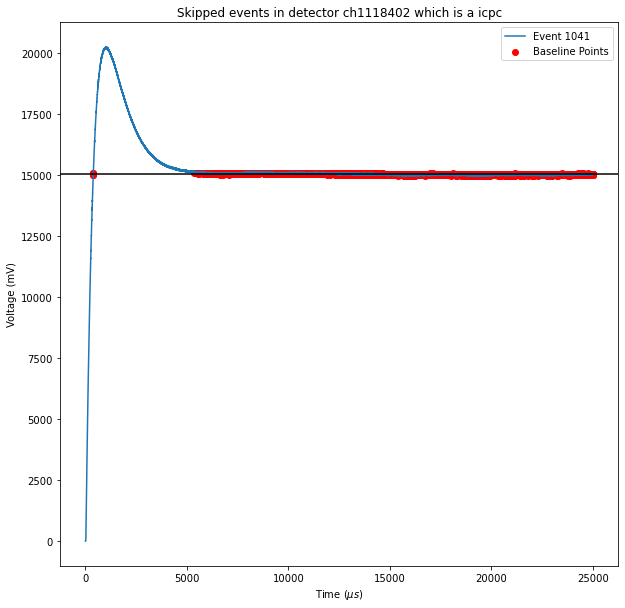

recovery rate 5368.8s
DISCHARGE
Maximum difference: 403.20000000000005, 5368.8
Next maximum difference: 5368.8, 5400.8


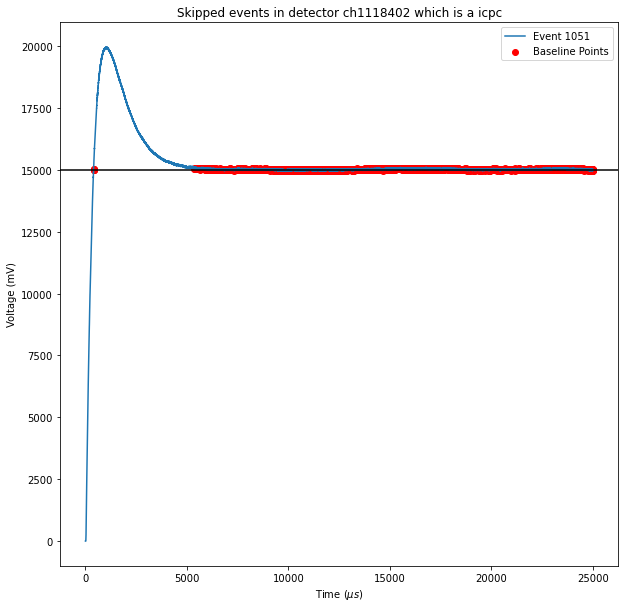

recovery rate 5346.4000000000015s
DISCHARGE
Maximum difference: 10158.400000000001, 14700.800000000001
Next maximum difference: 9354.4, 10152.0


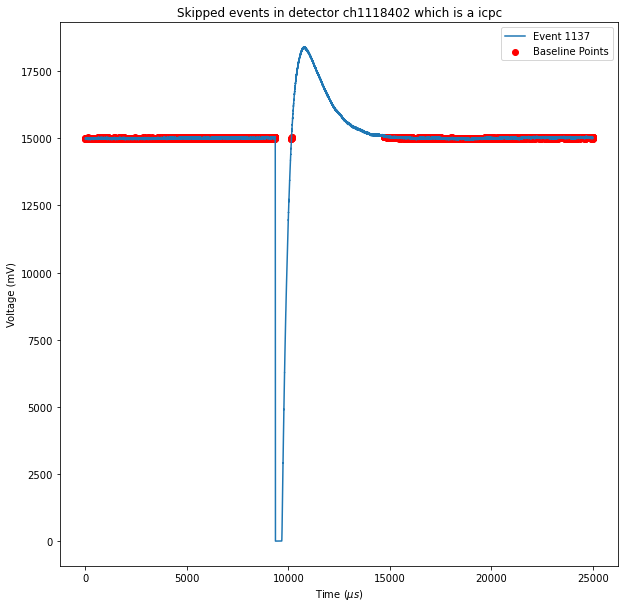

recovery rate 3733.6000000000013s
DISCHARGE
Maximum difference: 7829.6, 10738.400000000001
Next maximum difference: 7004.8, 7808.0


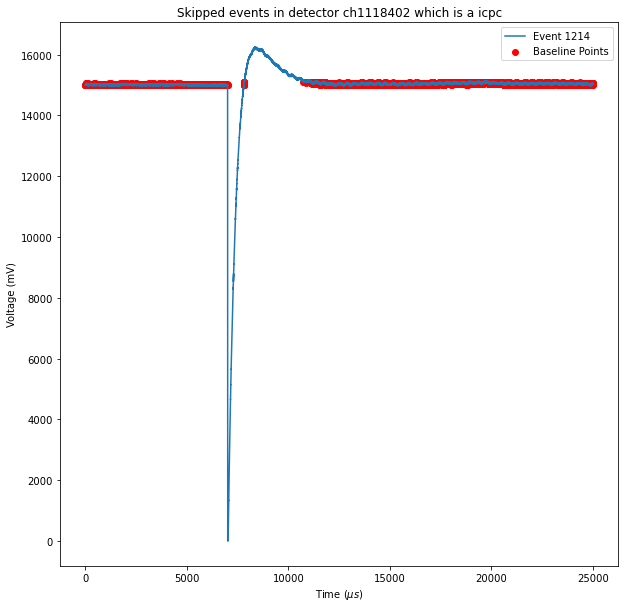

recovery rate 4016.0s
MICRODISCHARGE
Maximum difference: 368.8, 4016.0
Next Maximum difference: 4023.2000000000003, 4180.0


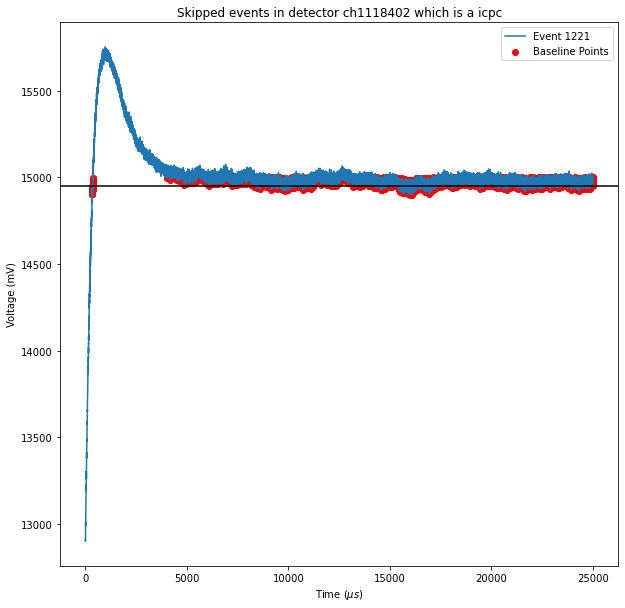

recovery rate 5589.6s
DISCHARGE
Maximum difference: 334.40000000000003, 5589.6
Next maximum difference: 5749.6, 5820.0


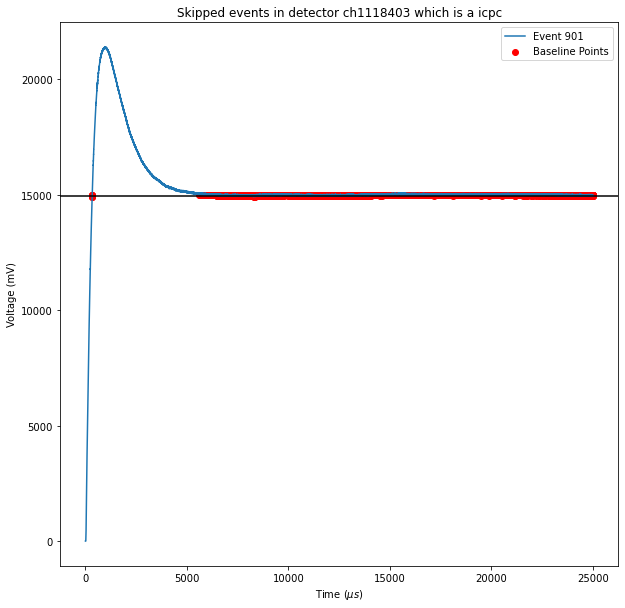

recovery rate 3191.2000000000003s
MICRODISCHARGE
Maximum difference: 516.8000000000001, 3191.2000000000003
Next Maximum difference: 3259.2000000000003, 3415.2000000000003


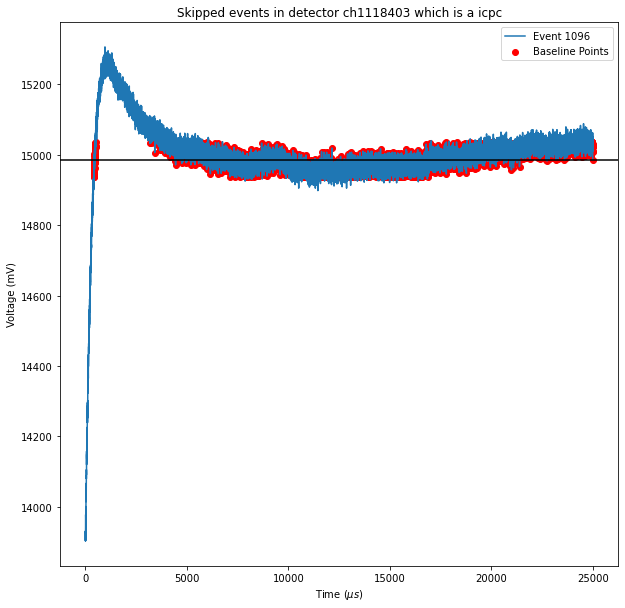

recovery rate 5059.200000000001s
DISCHARGE
Maximum difference: 350.40000000000003, 5059.200000000001
Next maximum difference: 5372.0, 5507.200000000001


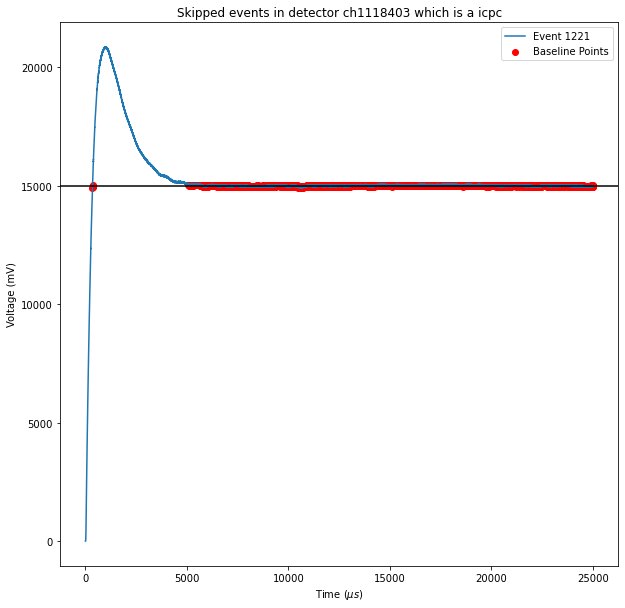

recovery rate 2064.0s
MICRODISCHARGE
Maximum difference: 1348.8000000000002, 2064.0
Next Maximum difference: 15216.0, 15243.2


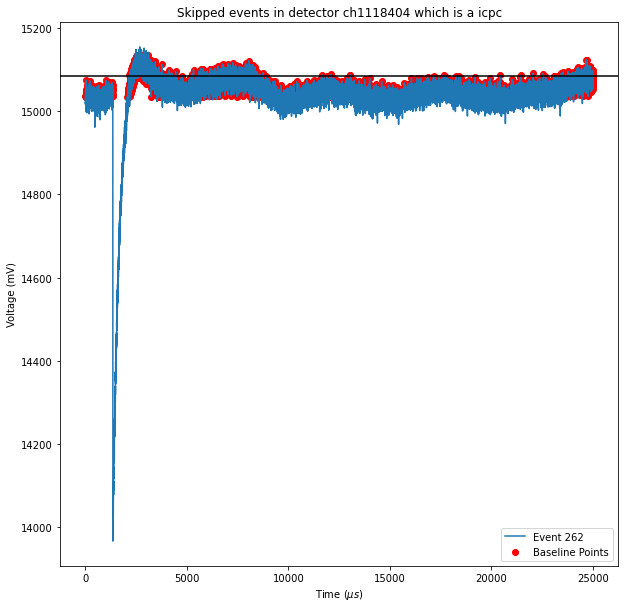

recovery rate 6976.800000000001s
MICRODISCHARGE
Maximum difference: 21201.600000000002, 21773.600000000002
Next Maximum difference: 14796.800000000001, 14921.6


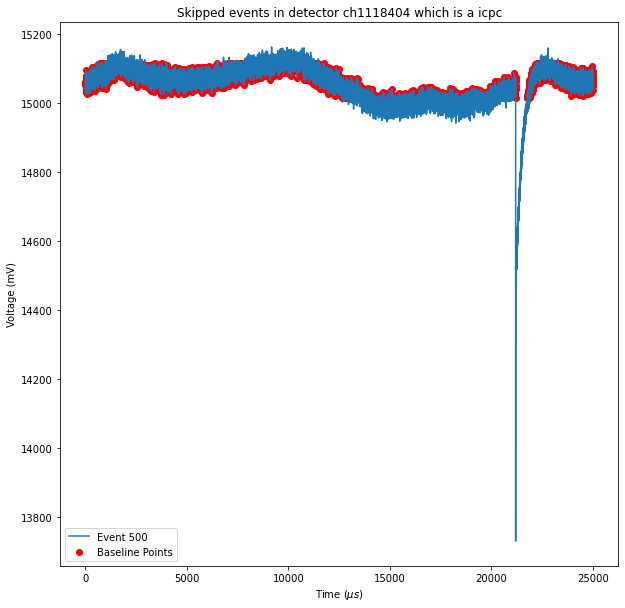

recovery rate 4448.0s
DISCHARGE
Maximum difference: 528.0, 4448.0
Next maximum difference: 13740.800000000001, 15255.2


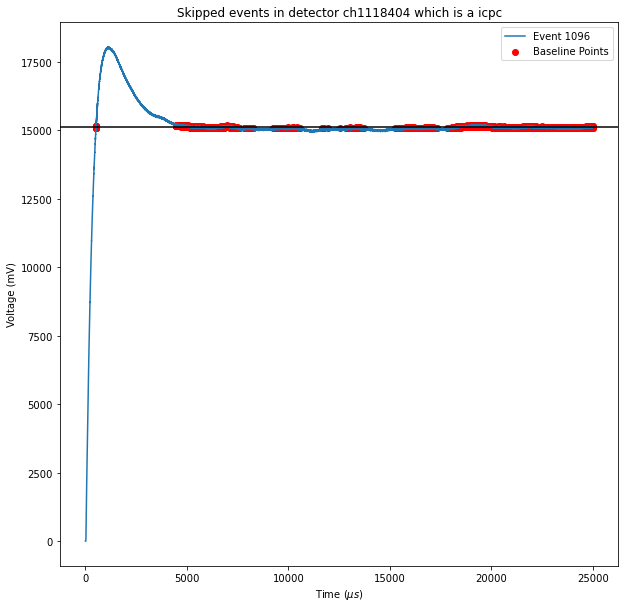

recovery rate 24356.800000000003s
MICRODISCHARGE
Maximum difference: 23612.0, 24356.800000000003
Next Maximum difference: 2343.2000000000003, 2434.4


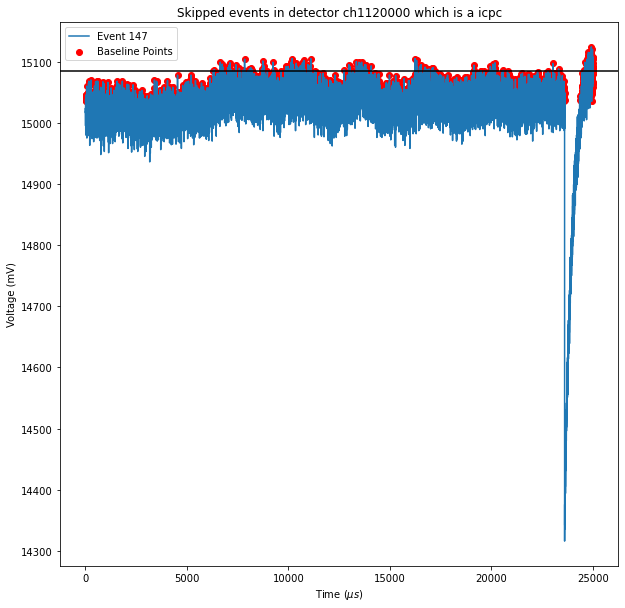

recovery rate 96.0s
MICRODISCHARGE
Maximum difference: 10703.2, 10740.0
Next Maximum difference: 10644.0, 10674.400000000001


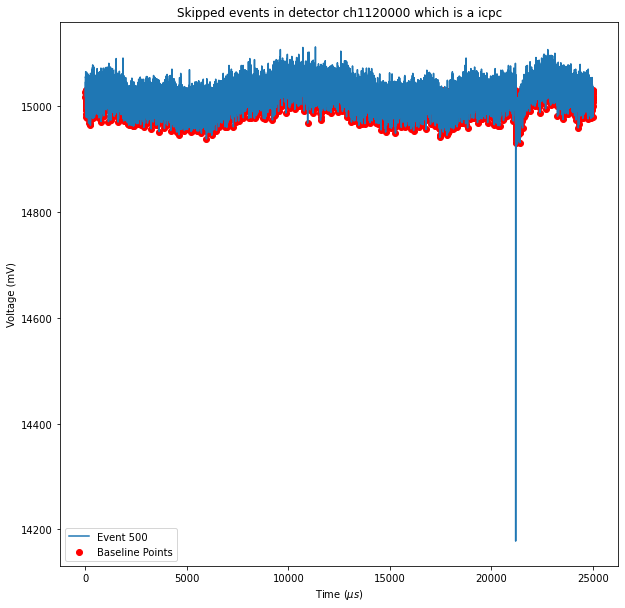

recovery rate 1919.2s
MICRODISCHARGE
Maximum difference: 696.8000000000001, 1919.2
Next Maximum difference: 17762.4, 17876.8


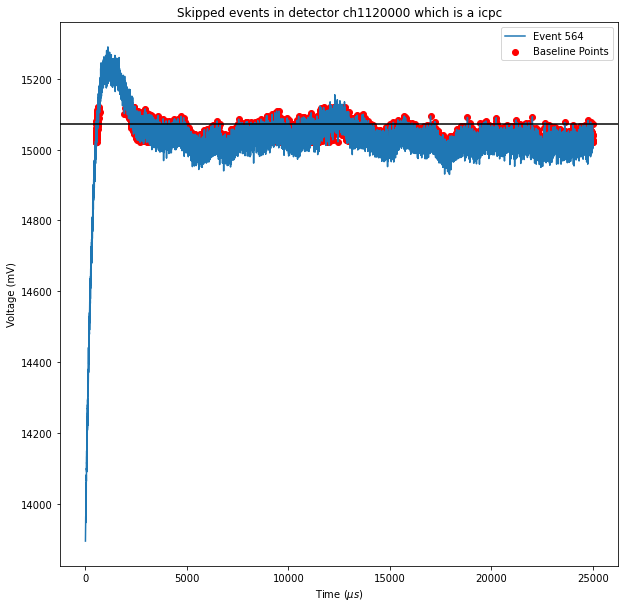

recovery rate 2885.6000000000004s
MICRODISCHARGE
Maximum difference: 431.20000000000005, 2885.6000000000004
Next Maximum difference: 2937.6000000000004, 2953.6000000000004


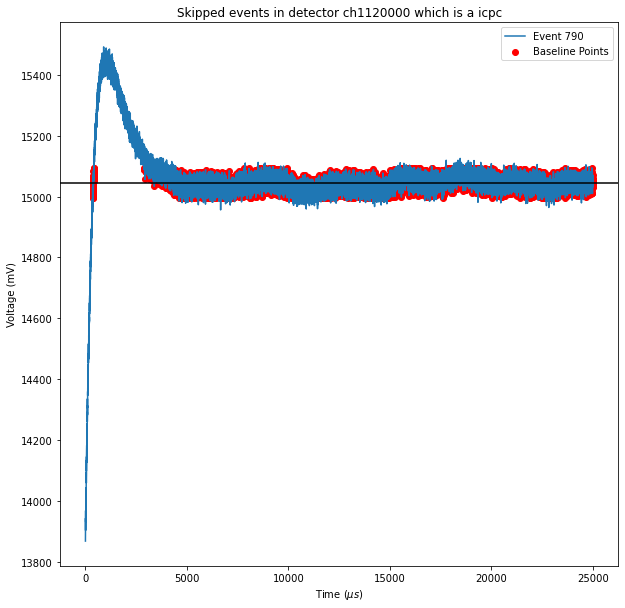

recovery rate -1712.7999999999993s
MICRODISCHARGE
Maximum difference: 13933.6, 16879.2
Next Maximum difference: 18592.0, 21193.600000000002


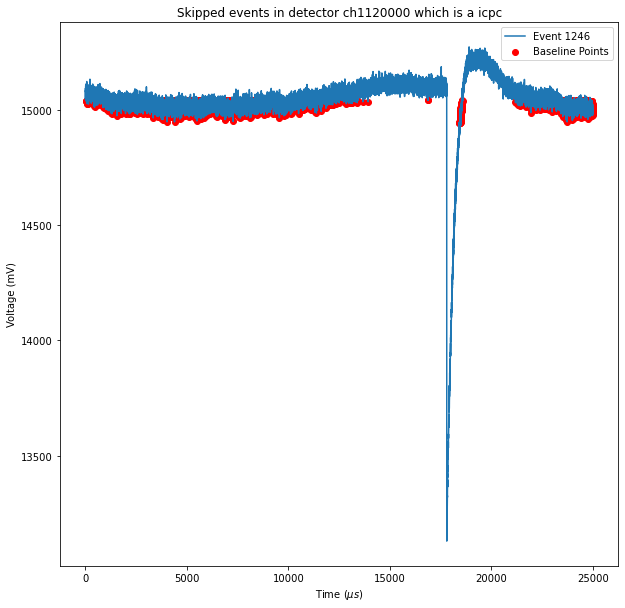

recovery rate 4280.799999999999s
MICRODISCHARGE
Maximum difference: 16069.6, 19387.2
Next Maximum difference: 15106.400000000001, 16069.6


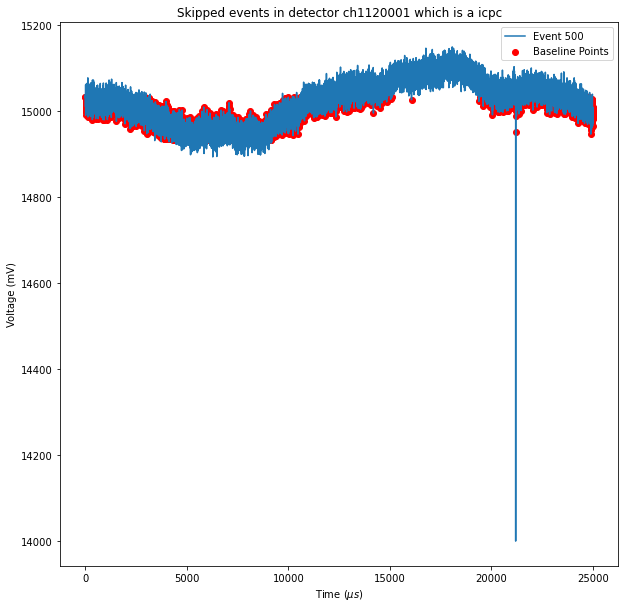

recovery rate 5315.200000000001s
DISCHARGE
Maximum difference: 522.4, 5315.200000000001
Next maximum difference: 17352.0, 18443.2


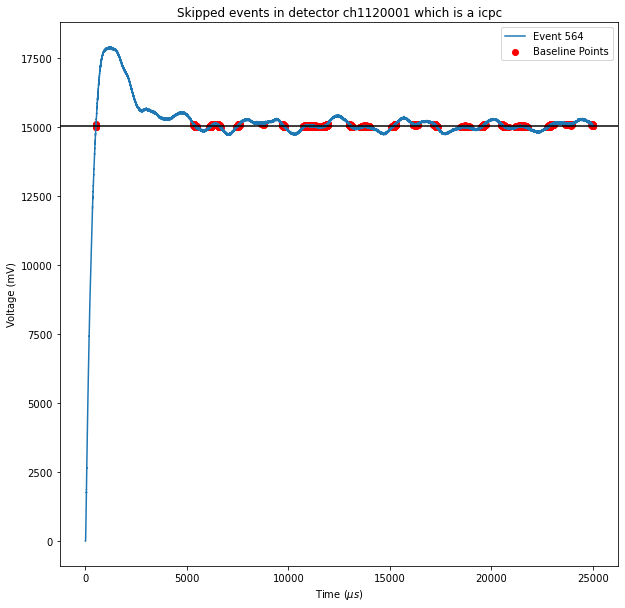

recovery rate 5233.6s
DISCHARGE
Maximum difference: 382.40000000000003, 5233.6
Next maximum difference: 19204.0, 20700.800000000003


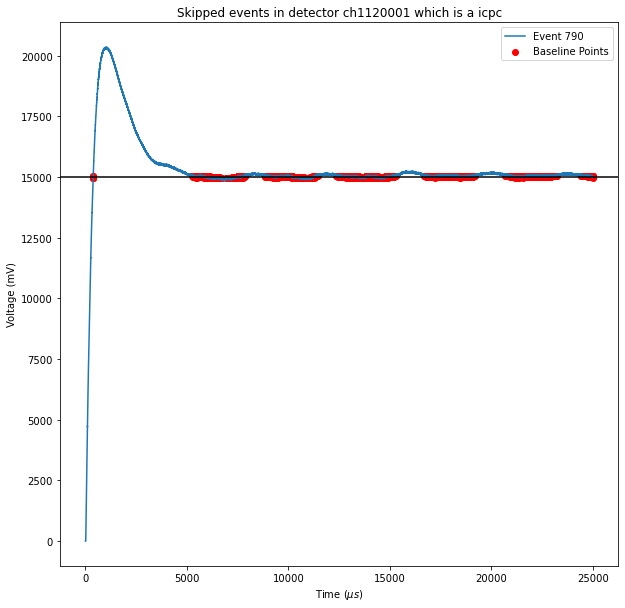

recovery rate 18576.8s
MICRODISCHARGE
Maximum difference: 24182.4, 24803.2
Next Maximum difference: 6226.400000000001, 6254.400000000001


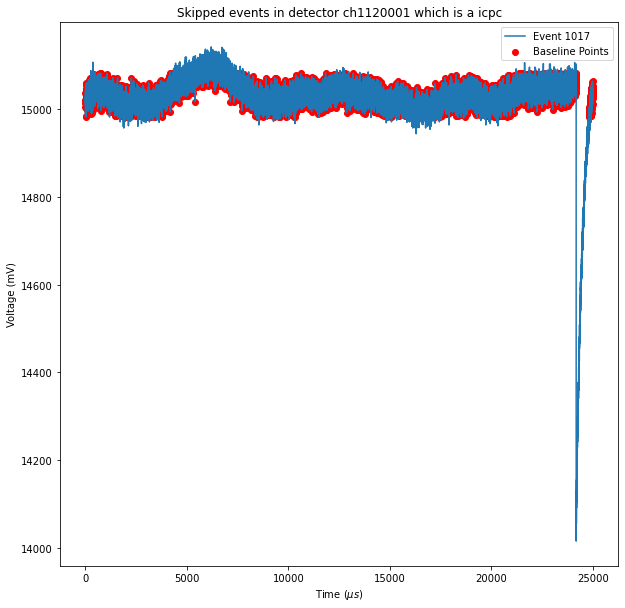

recovery rate -375.1999999999971s
DISCHARGE
Maximum difference: 18593.600000000002, 23744.800000000003
Next maximum difference: 24120.0, 24820.800000000003


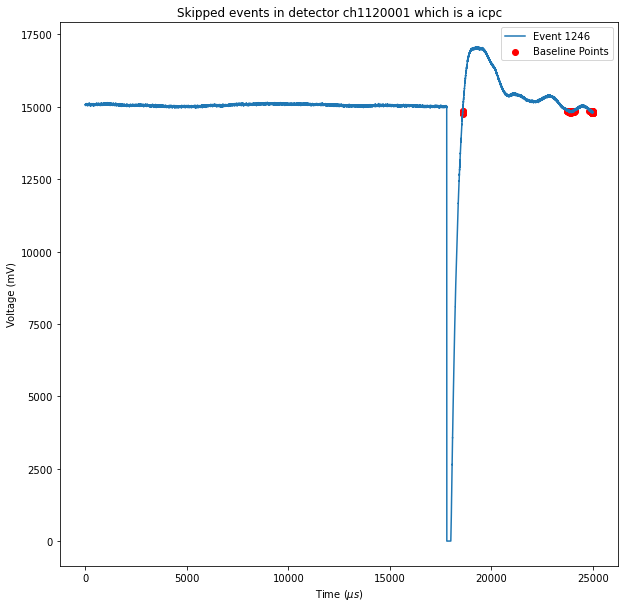

recovery rate -64.0s
MICRODISCHARGE
Maximum difference: 2752.0, 3749.6000000000004
Next Maximum difference: 3813.6000000000004, 3827.2000000000003


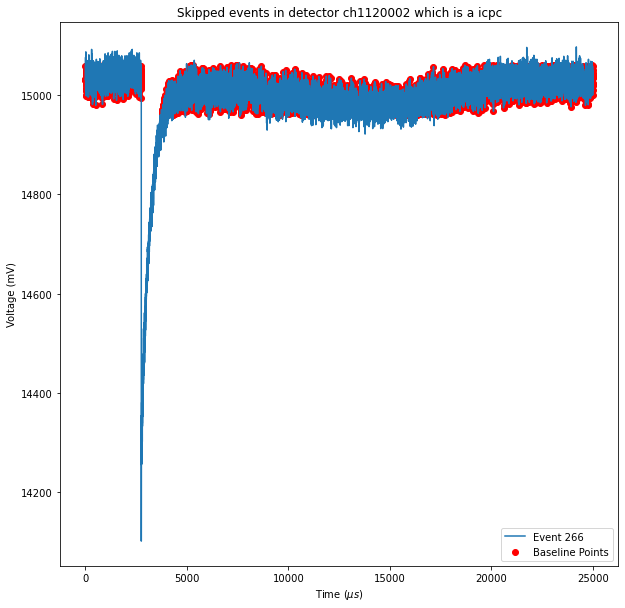

recovery rate 14892.0s
MICRODISCHARGE
Maximum difference: 14884.0, 14892.0
Next Maximum difference: 8024.0, 8031.200000000001


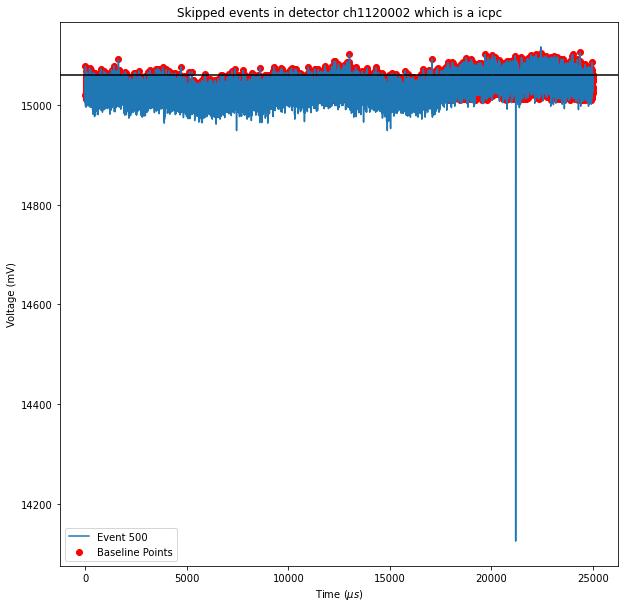

recovery rate -42.399999999999636s
MICRODISCHARGE
Maximum difference: 9331.2, 10601.6
Next Maximum difference: 10644.0, 10706.400000000001


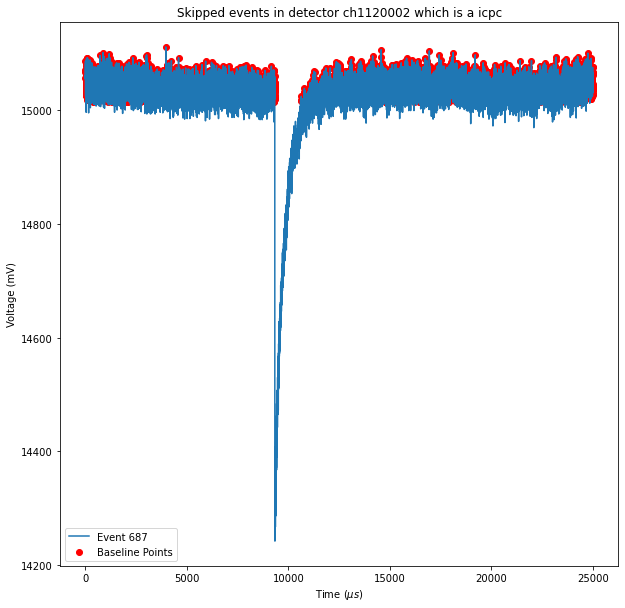

recovery rate 19140.8s
DISCHARGE
Maximum difference: 9814.4, 19140.8
Next maximum difference: 19602.4, 24537.600000000002


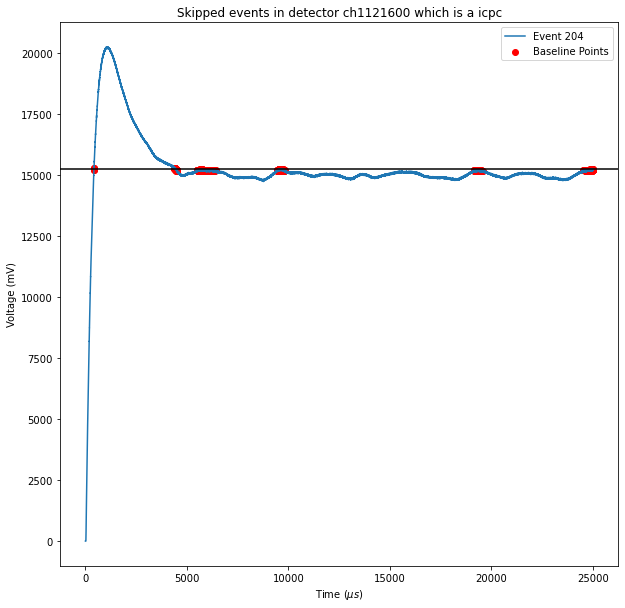

recovery rate 16162.400000000001s
DISCHARGE
Maximum difference: 9898.400000000001, 16162.400000000001
Next maximum difference: 19868.800000000003, 24512.0


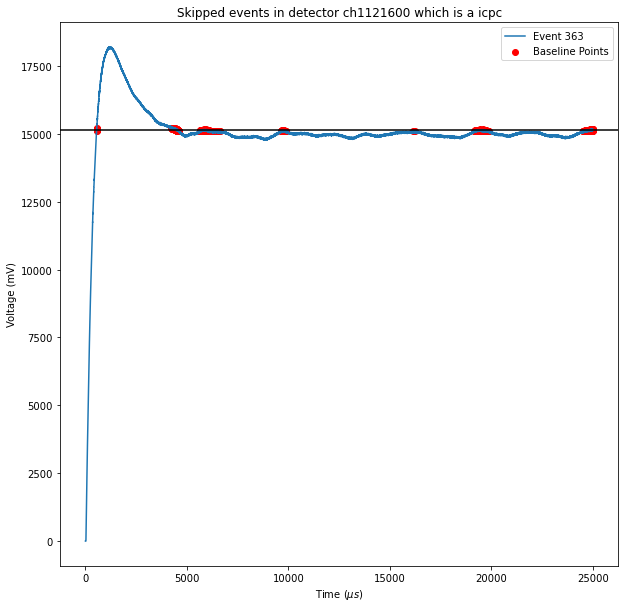

recovery rate 15344.0s
DISCHARGE
Maximum difference: 9897.6, 15344.0
Next maximum difference: 19942.4, 24684.0


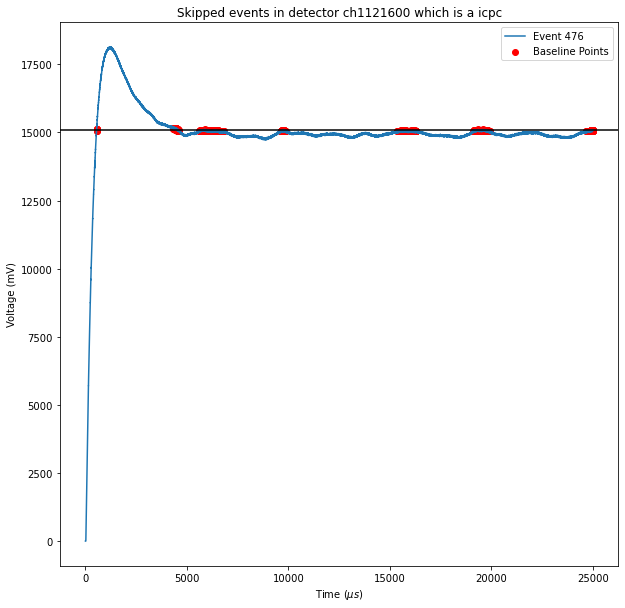

recovery rate 4492.8s
DISCHARGE
Maximum difference: 552.8000000000001, 4492.8
Next maximum difference: 16509.600000000002, 18958.4


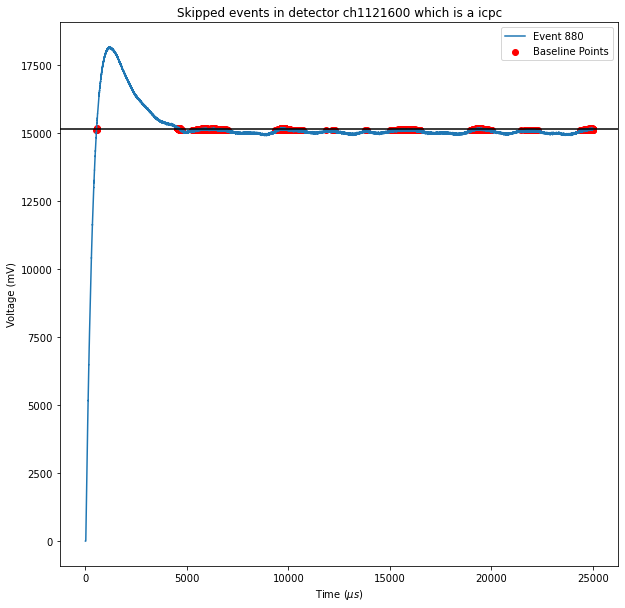

recovery rate 2965.6000000000004s
MICRODISCHARGE
Maximum difference: 10076.0, 12108.0
Next Maximum difference: 9142.4, 9916.0


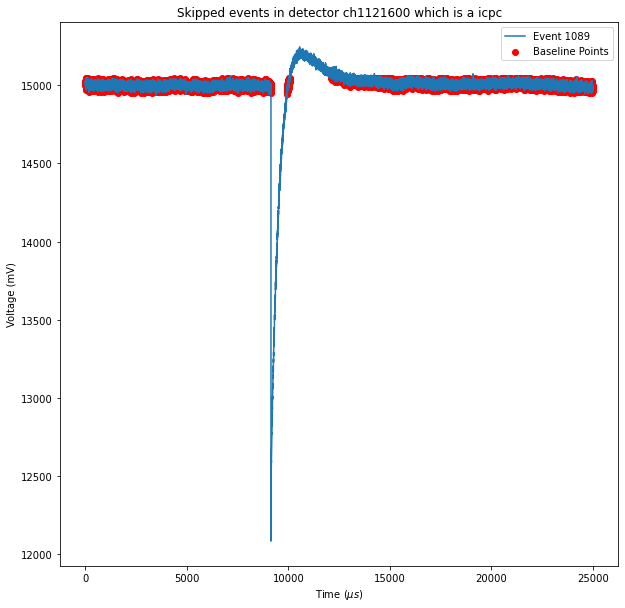

recovery rate 19346.4s
DISCHARGE
Maximum difference: 5930.400000000001, 19346.4
Next maximum difference: 19490.4, 24566.4


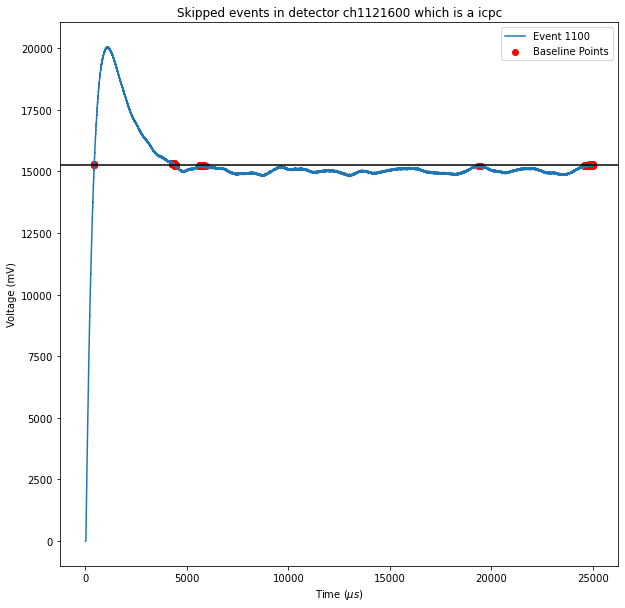

recovery rate 15588.800000000001s
DISCHARGE
Maximum difference: 9967.2, 15588.800000000001
Next maximum difference: 19877.600000000002, 24548.800000000003


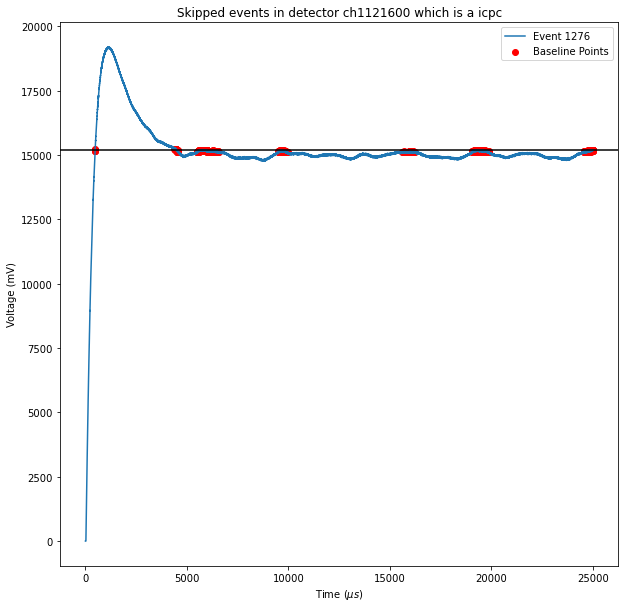

recovery rate 19186.4s
DISCHARGE
Maximum difference: 9842.400000000001, 19186.4
Next maximum difference: 19714.4, 24572.0


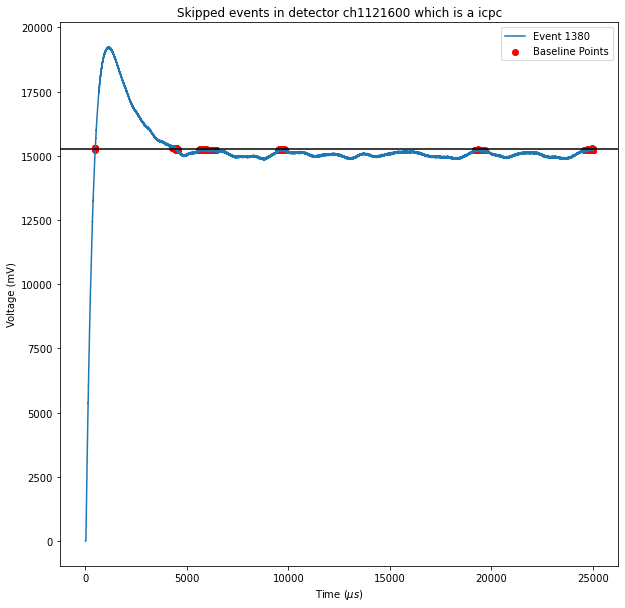

recovery rate 4920.0s
DISCHARGE
Maximum difference: 505.6, 4920.0
Next maximum difference: 4920.0, 4986.400000000001


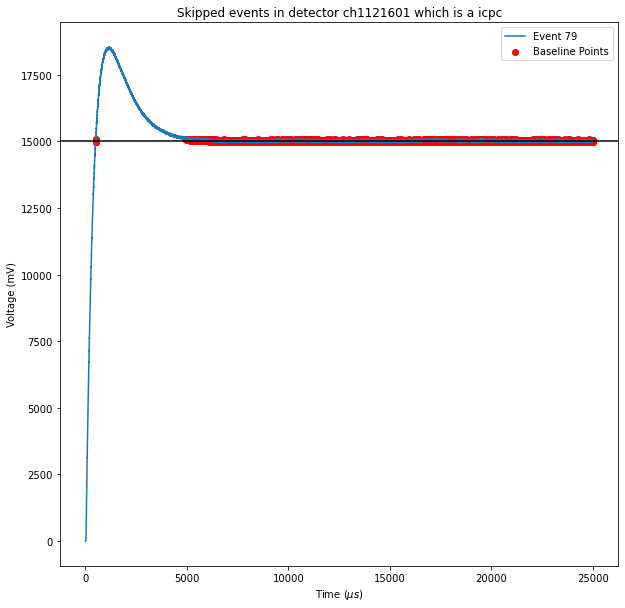

recovery rate 5389.6s
DISCHARGE
Maximum difference: 415.20000000000005, 5389.6
Next maximum difference: 5389.6, 5487.200000000001


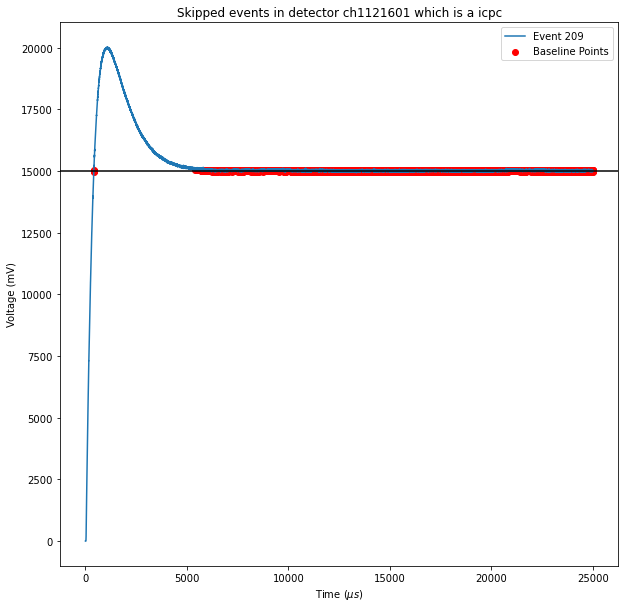

recovery rate 5171.200000000001s
DISCHARGE
Maximum difference: 417.6, 5171.200000000001
Next maximum difference: 5171.200000000001, 5736.0


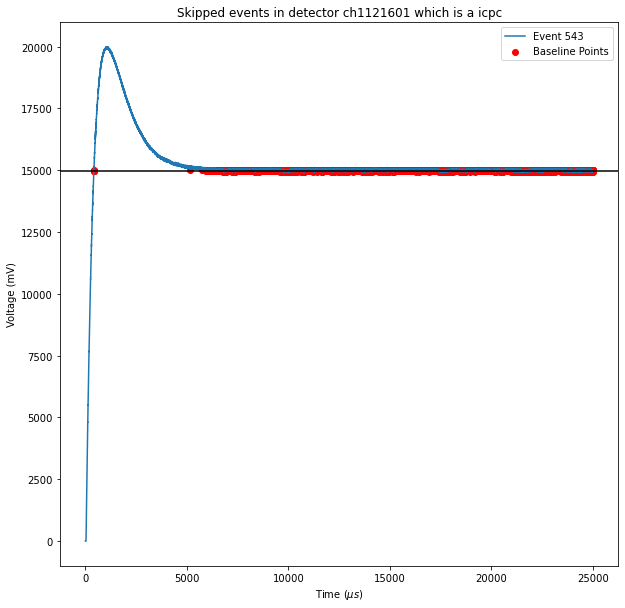

recovery rate 2844.0s
MICRODISCHARGE
Maximum difference: 550.4, 2844.0
Next Maximum difference: 19818.4, 20020.0


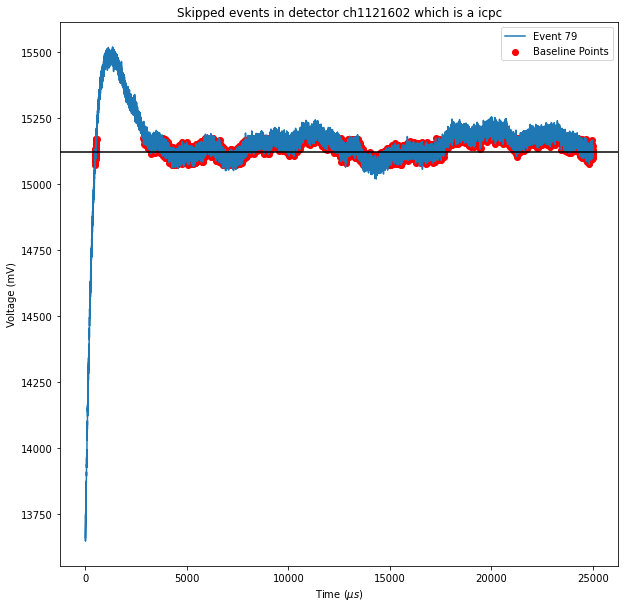

recovery rate 4120.0s
MICRODISCHARGE
Maximum difference: 419.20000000000005, 4120.0
Next Maximum difference: 8369.6, 9954.400000000001


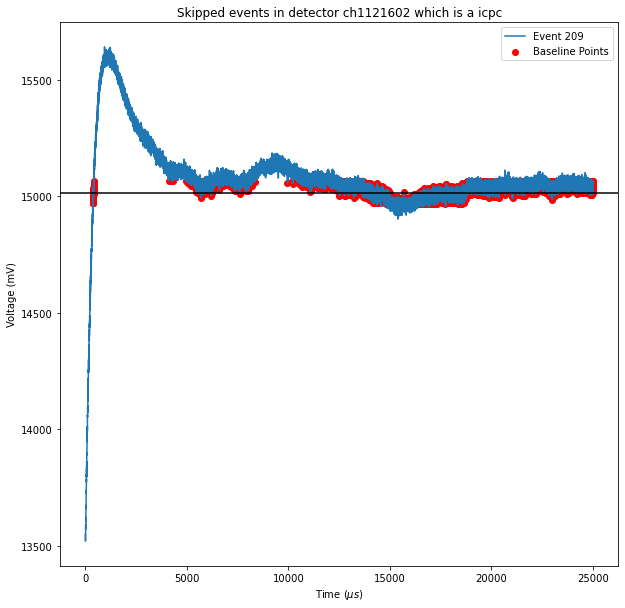

recovery rate 4772.8s
MICRODISCHARGE
Maximum difference: 395.20000000000005, 4772.8
Next Maximum difference: 16083.2, 16278.400000000001


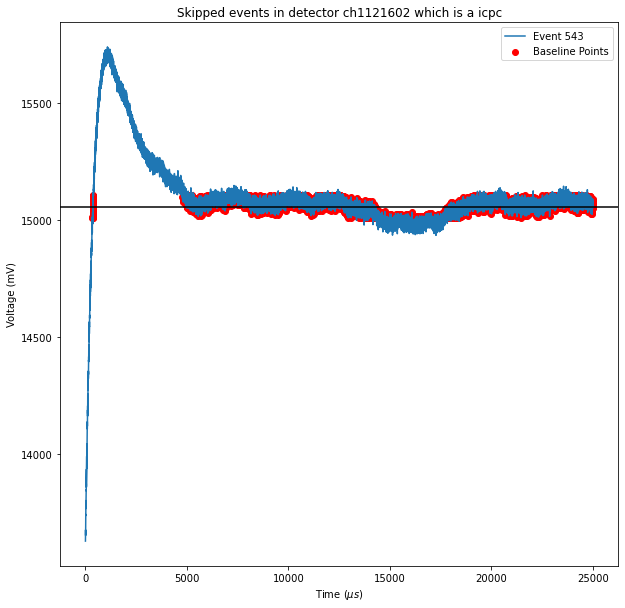

recovery rate -5628.8s
MICRODISCHARGE
Maximum difference: 2197.6, 4111.2
Next Maximum difference: 9740.0, 10375.2


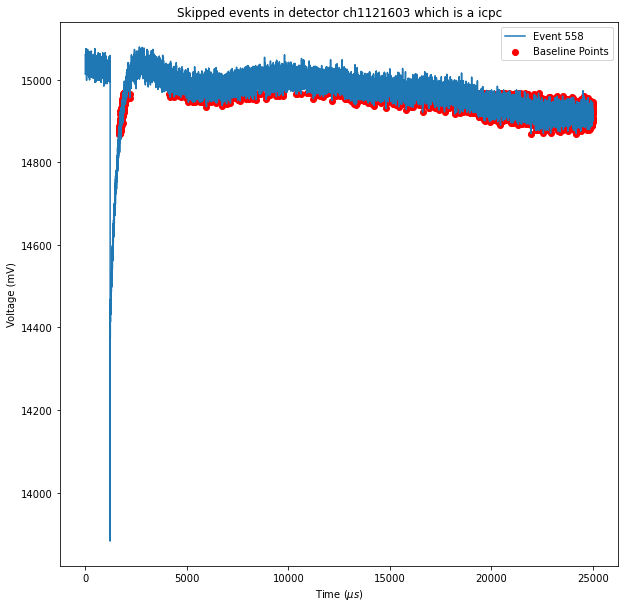

recovery rate -14733.6s
MICRODISCHARGE
Maximum difference: 1217.6000000000001, 1298.4
Next Maximum difference: 16032.0, 16111.2


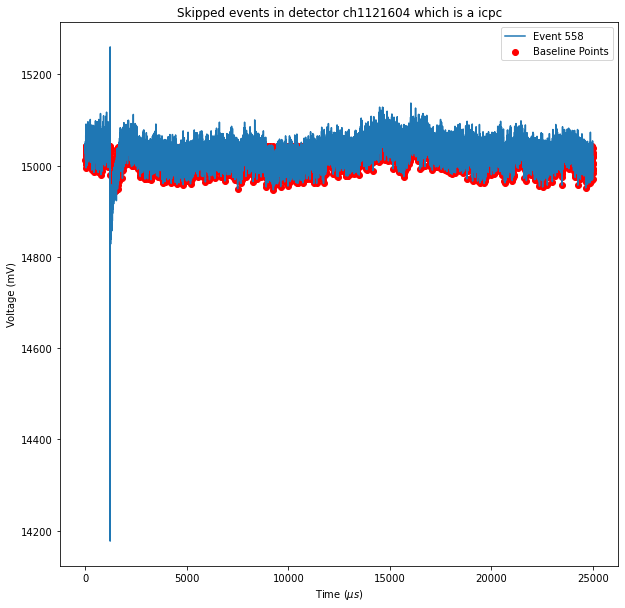

recovery rate 3100.8s
MICRODISCHARGE
Maximum difference: 420.0, 3100.8
Next Maximum difference: 3226.4, 3259.2000000000003


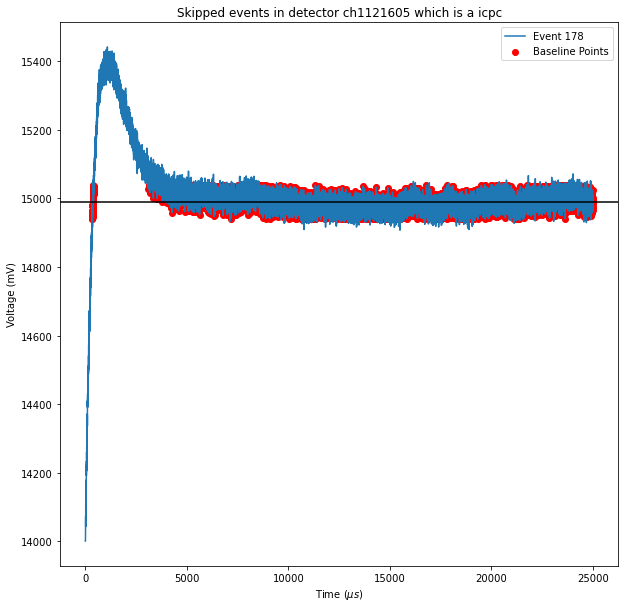

recovery rate 2703.2000000000007s
MICRODISCHARGE
Maximum difference: 21881.600000000002, 23505.600000000002
Next Maximum difference: 20802.4, 21616.0


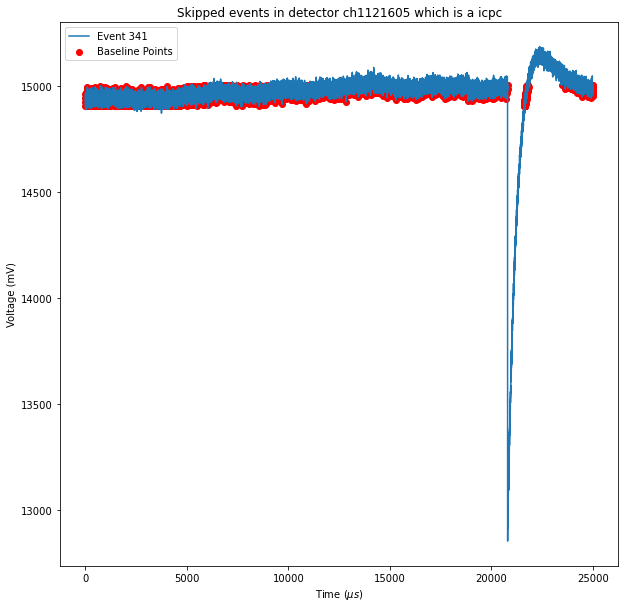

recovery rate 2972.8s
MICRODISCHARGE
Maximum difference: 346.40000000000003, 2972.8
Next Maximum difference: 2972.8, 3024.8


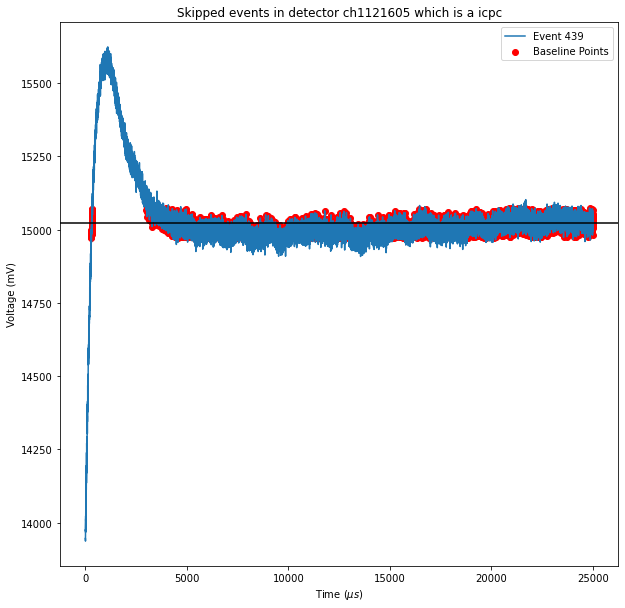

recovery rate 2777.6000000000004s
MICRODISCHARGE
Maximum difference: 457.6, 2777.6000000000004
Next Maximum difference: 2777.6000000000004, 2821.6000000000004


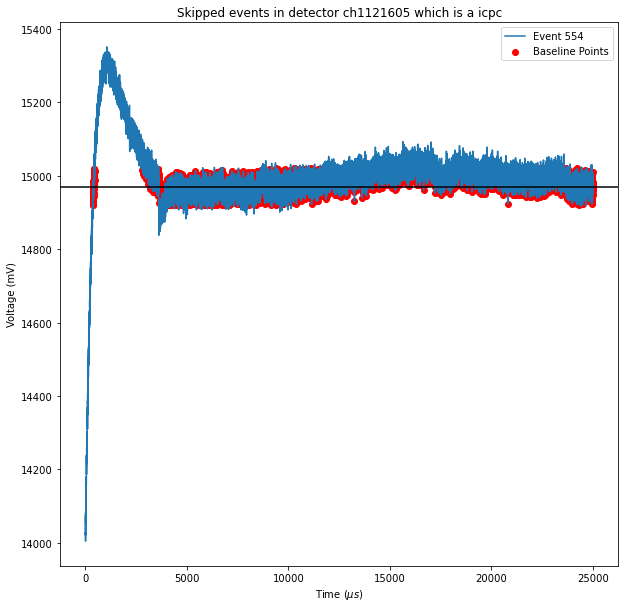

recovery rate 2964.7999999999993s
MICRODISCHARGE
Maximum difference: 7145.6, 8988.0
Next Maximum difference: 6023.200000000001, 6753.6


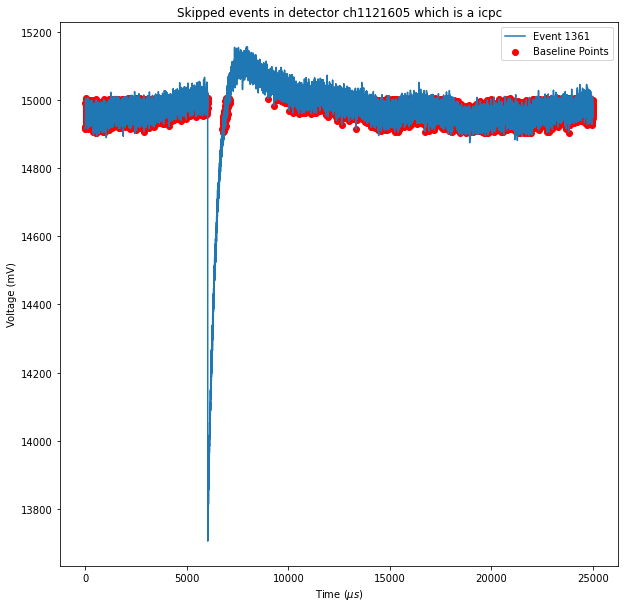

recovery rate 6887.200000000001s
DISCHARGE
Maximum difference: 258.40000000000003, 6887.200000000001
Next maximum difference: 17148.0, 18227.2


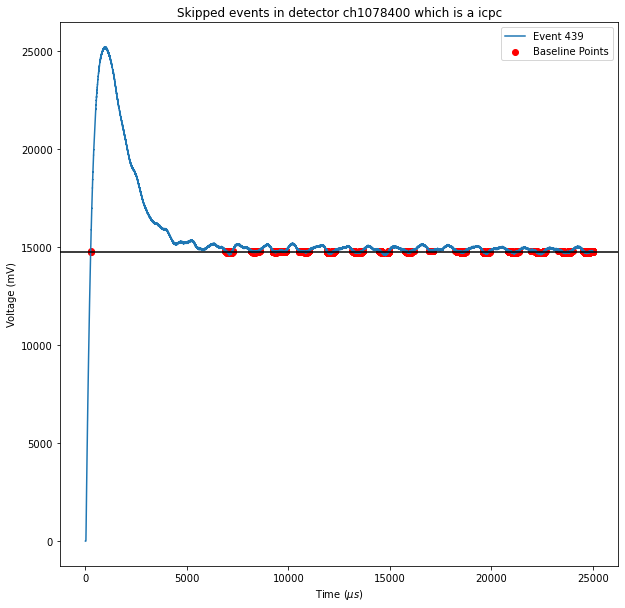

recovery rate 7657.6s
DISCHARGE
Maximum difference: 361.6, 7657.6
Next maximum difference: 7657.6, 10717.6


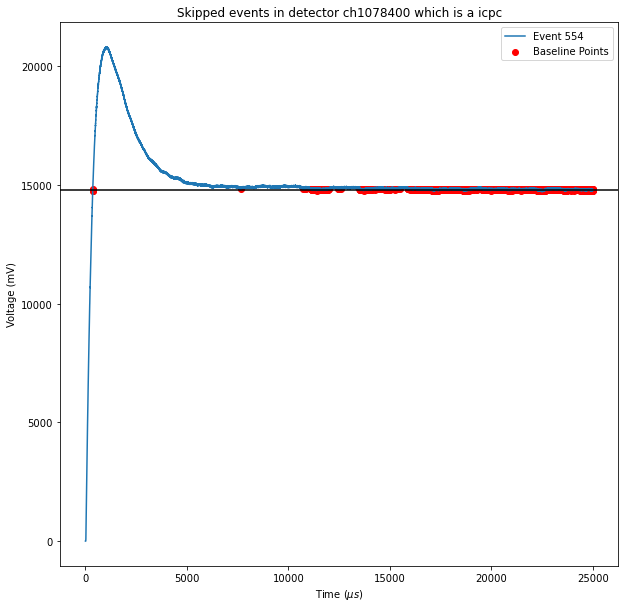

recovery rate 204.79999999999973s
MICRODISCHARGE
Maximum difference: 3133.6000000000004, 3160.0
Next Maximum difference: 2955.2000000000003, 2978.4


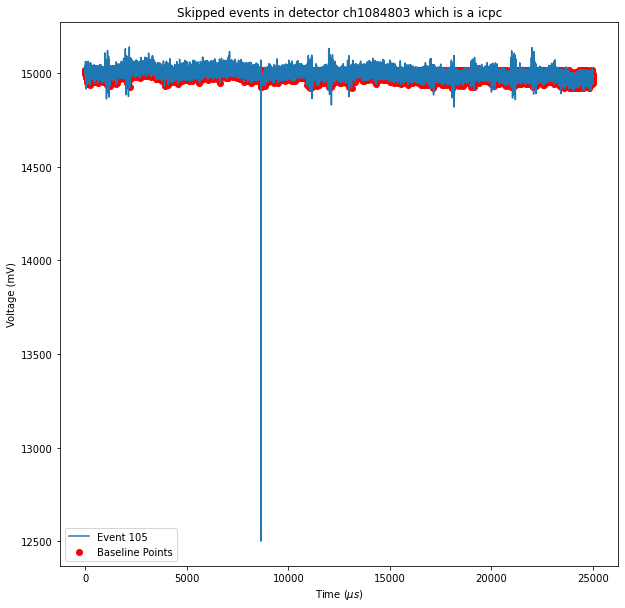

recovery rate -26.399999999999636s
MICRODISCHARGE
Maximum difference: 7288.8, 7507.200000000001
Next Maximum difference: 7533.6, 7559.200000000001


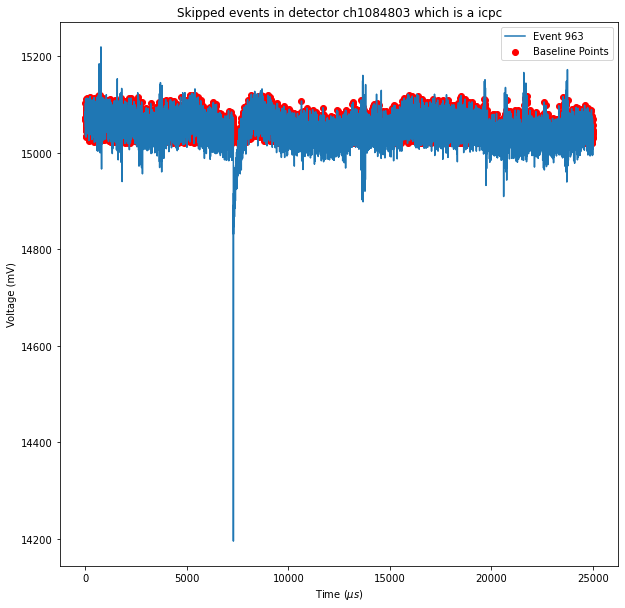

recovery rate -4.800000000000182s
MICRODISCHARGE
Maximum difference: 7292.0, 7436.8
Next Maximum difference: 7441.6, 7466.400000000001


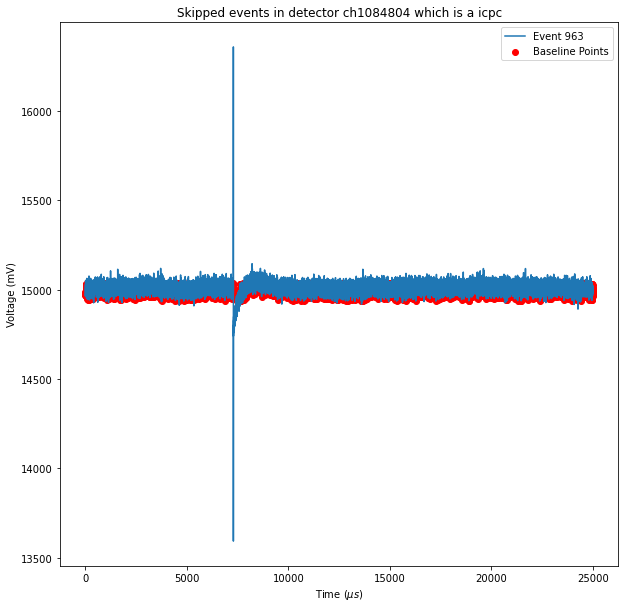

recovery rate 3243.2000000000003s
MICRODISCHARGE
Maximum difference: 301.6, 3243.2000000000003
Next Maximum difference: 3243.2000000000003, 3887.2000000000003


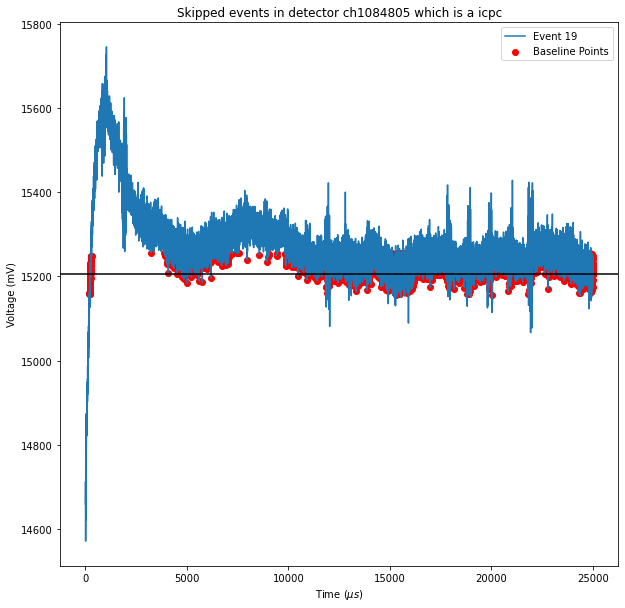

recovery rate 2255.2000000000007s
MICRODISCHARGE
Maximum difference: 9632.0, 10898.400000000001
Next Maximum difference: 8643.2, 9329.6


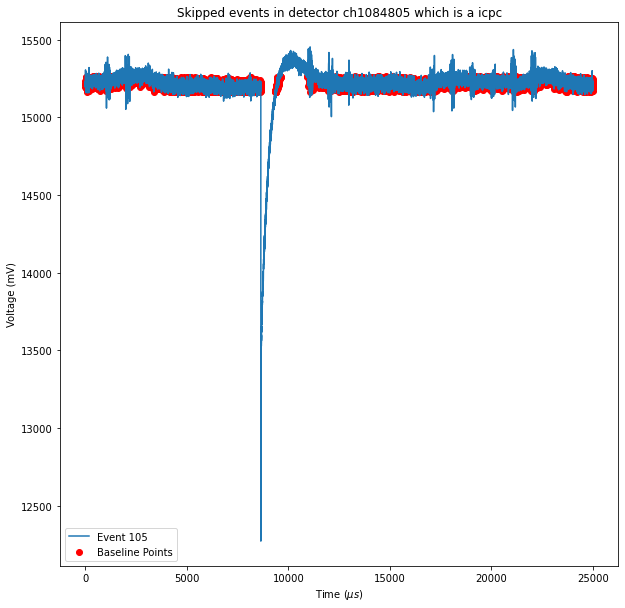

recovery rate 3432.000000000001s
MICRODISCHARGE
Maximum difference: 8139.200000000001, 10720.800000000001
Next Maximum difference: 7288.8, 8053.6


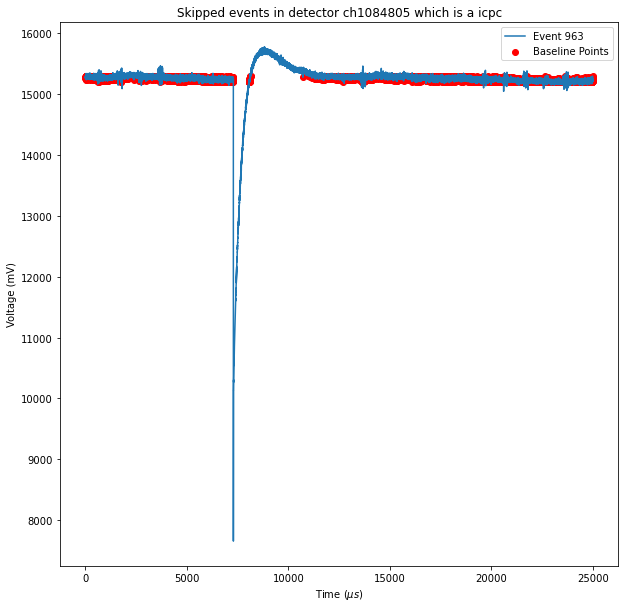

recovery rate 6059.200000000001s
DISCHARGE
Maximum difference: 412.8, 6059.200000000001
Next maximum difference: 6059.200000000001, 6244.0


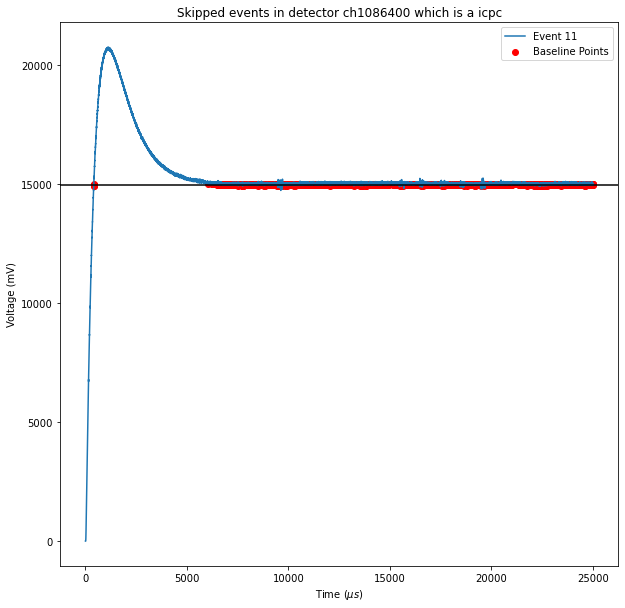

recovery rate 5760.8s
DISCHARGE
Maximum difference: 306.40000000000003, 5760.8
Next maximum difference: 5760.8, 6118.400000000001


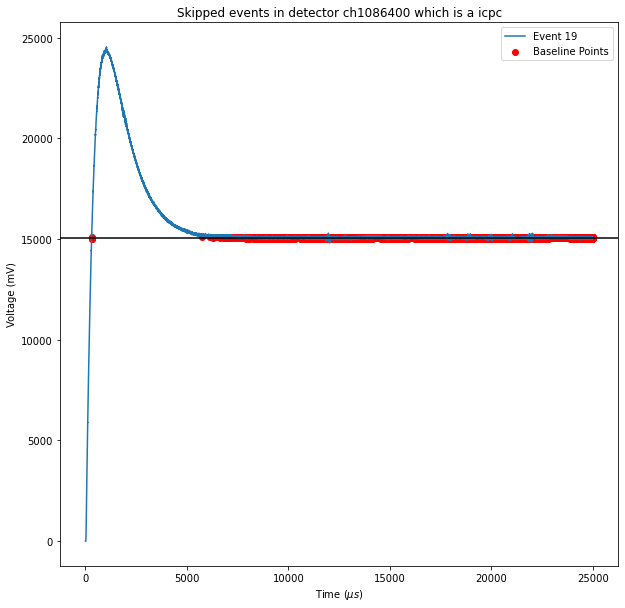

recovery rate 5511.200000000001s
DISCHARGE
Maximum difference: 447.20000000000005, 5511.200000000001
Next maximum difference: 5599.200000000001, 5703.200000000001


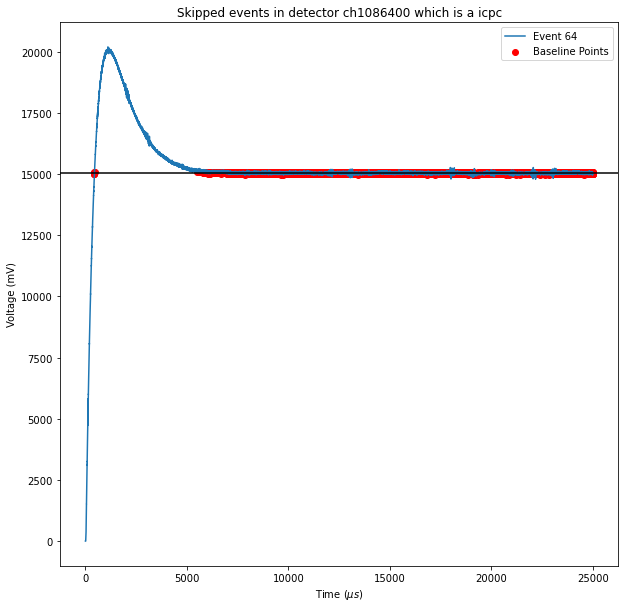

recovery rate 5221.6s
DISCHARGE
Maximum difference: 9492.0, 13864.800000000001
Next maximum difference: 8643.2, 9482.4


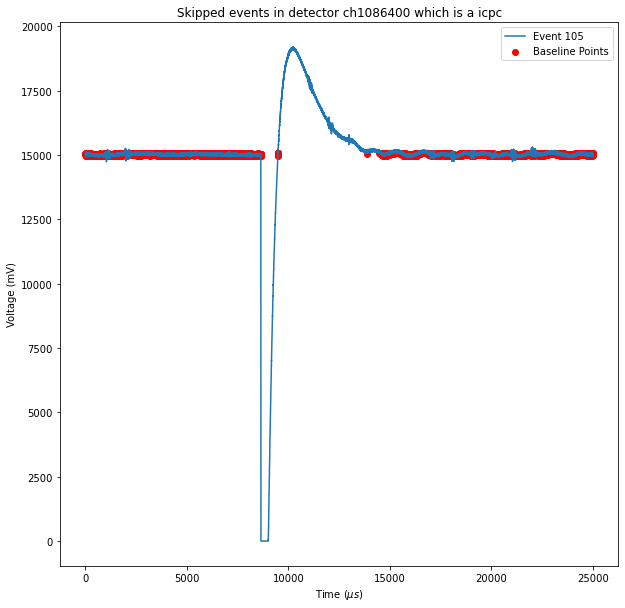

recovery rate -212.79999999999995s
MICRODISCHARGE
Maximum difference: 164.8, 1110.4
Next Maximum difference: 1323.2, 1564.0


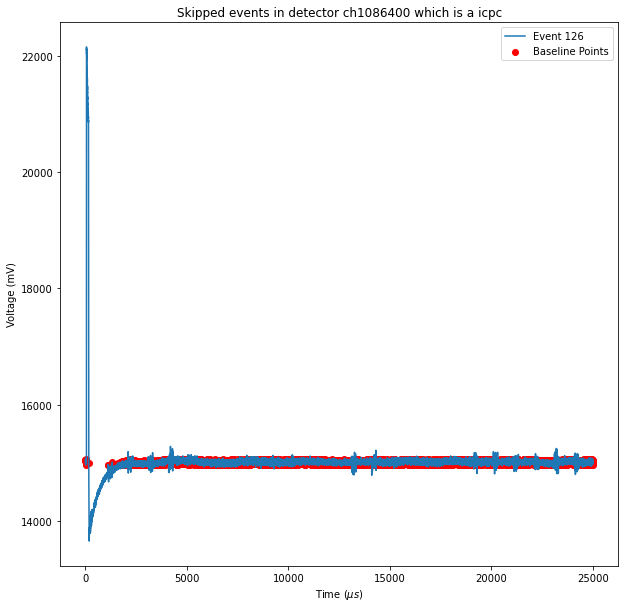

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 164.0, 1166.4
Next Maximum difference: 1166.4, 1570.4


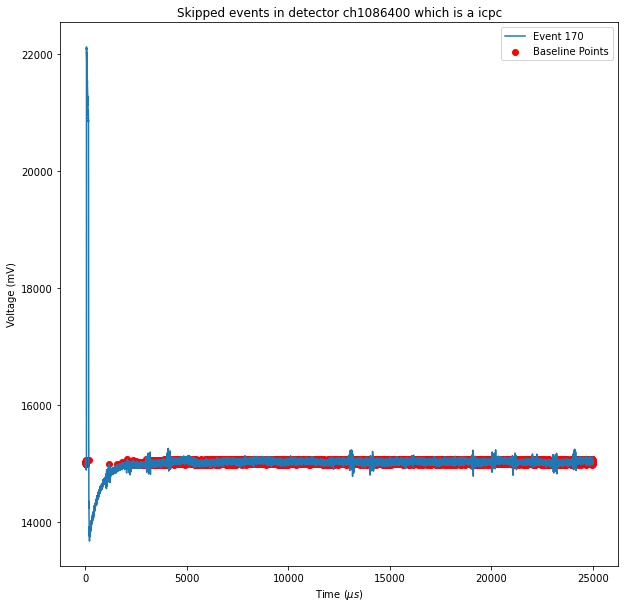

recovery rate 1450.4s
MICRODISCHARGE
Maximum difference: 164.0, 1500.0
Next Maximum difference: 49.6, 164.0


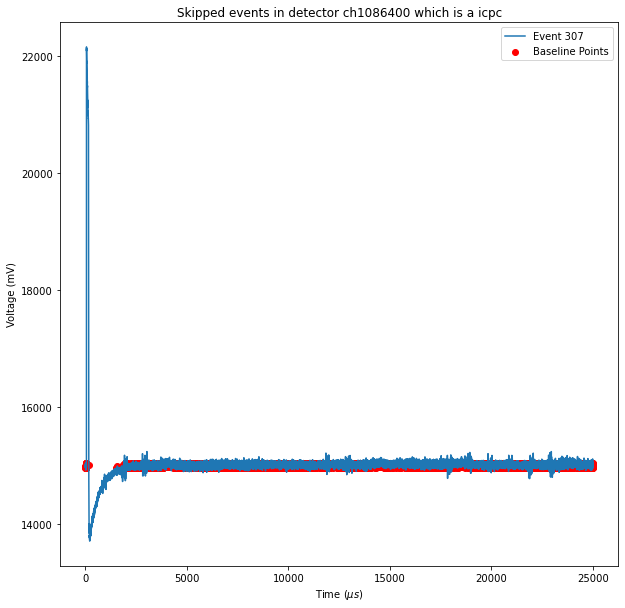

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 49.6, 1314.4
Next Maximum difference: 1314.4, 1373.6000000000001


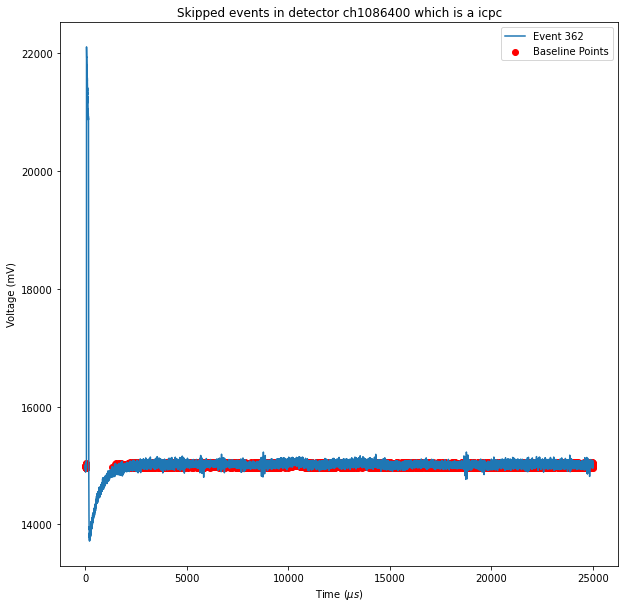

recovery rate -80.0s
MICRODISCHARGE
Maximum difference: 164.8, 1068.0
Next Maximum difference: 1148.0, 1376.0


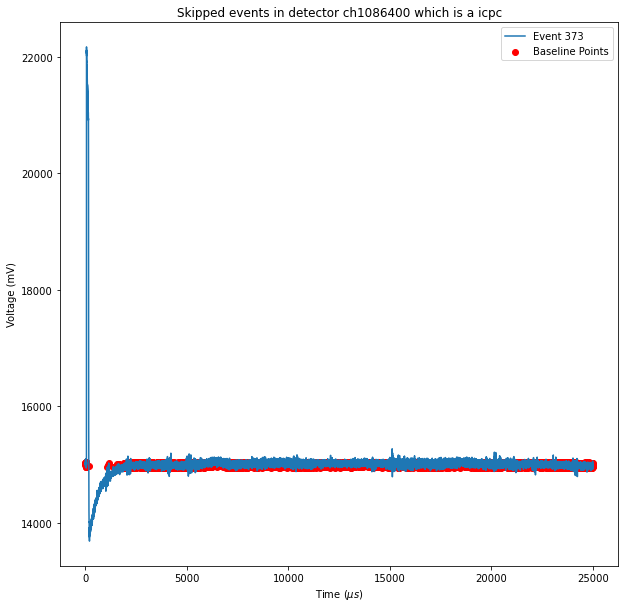

recovery rate 1676.0s
MICRODISCHARGE
Maximum difference: 164.0, 1676.0
Next Maximum difference: 16.0, 163.20000000000002


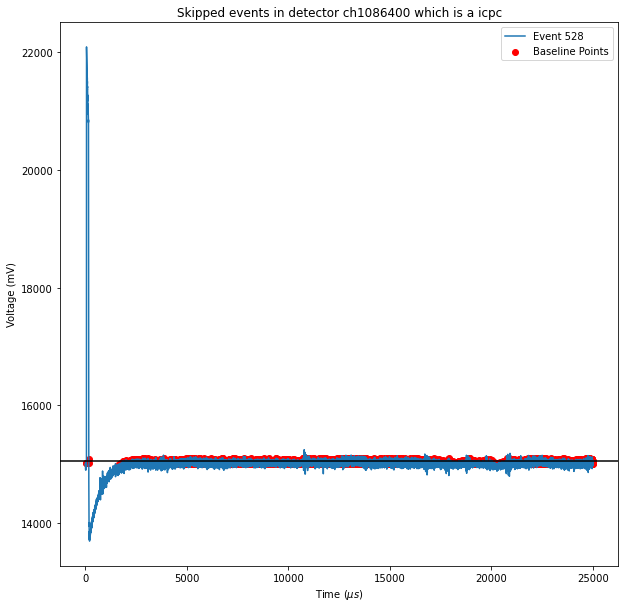

recovery rate 1682.4s
MICRODISCHARGE
Maximum difference: 164.0, 1682.4
Next Maximum difference: 1707.2, 1960.0


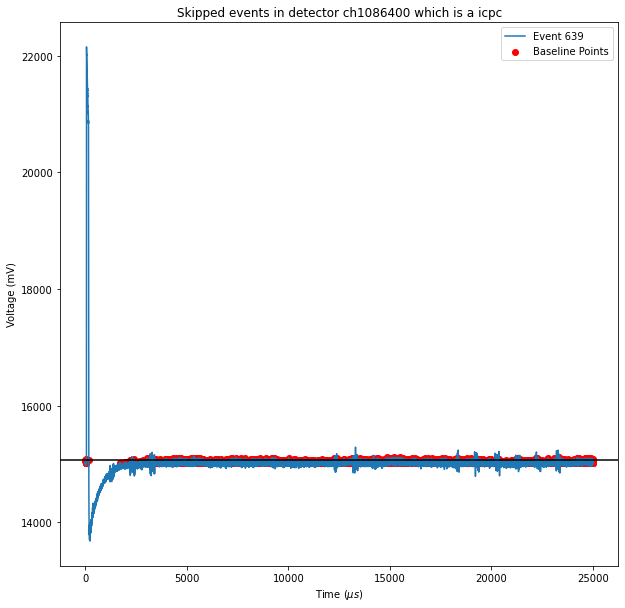

recovery rate 13629.6s
DISCHARGE
Maximum difference: 8134.400000000001, 13629.6
Next maximum difference: 7288.8, 8133.6


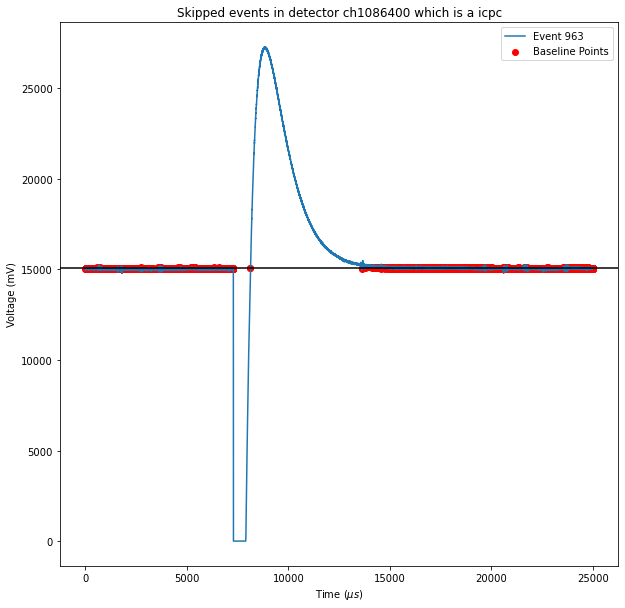

recovery rate -20.800000000000182s
MICRODISCHARGE
Maximum difference: 164.8, 1136.8
Next Maximum difference: 1157.6000000000001, 1477.6000000000001


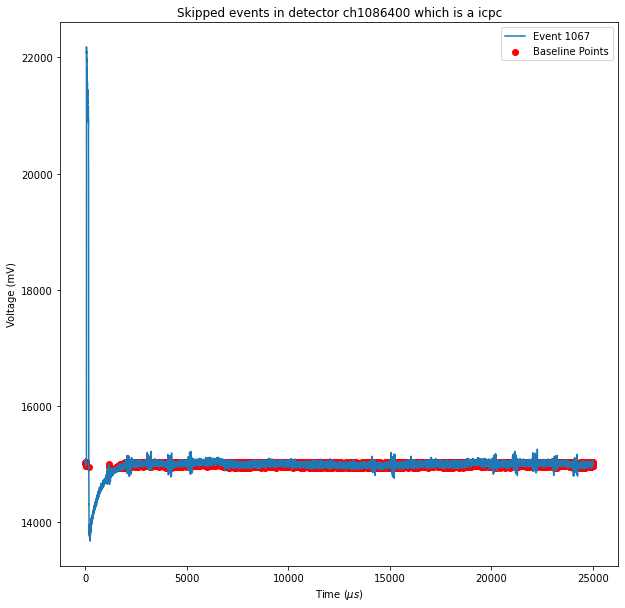

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 164.0, 1672.0
Next Maximum difference: 1672.0, 1805.6000000000001


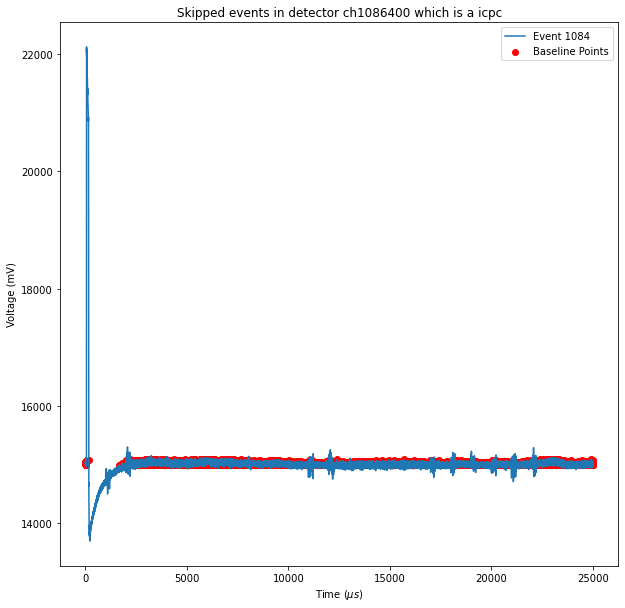

recovery rate -136.0s
MICRODISCHARGE
Maximum difference: 164.0, 1273.6000000000001
Next Maximum difference: 1409.6000000000001, 1761.6000000000001


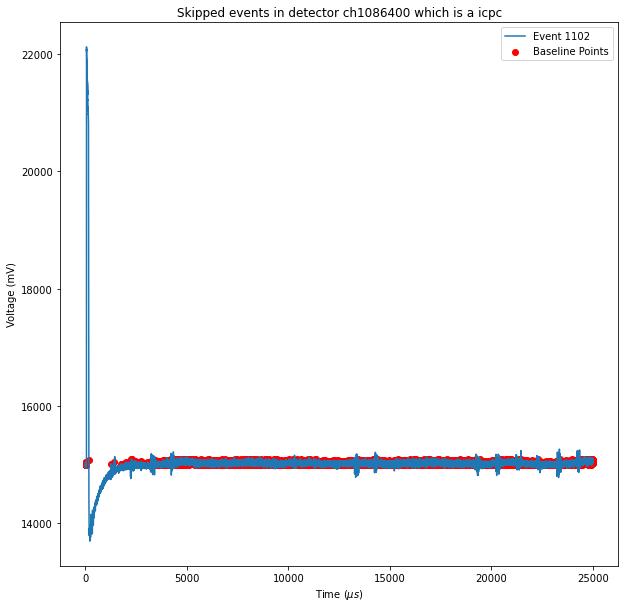

recovery rate 1146.4s
MICRODISCHARGE
Maximum difference: 164.8, 1195.2
Next Maximum difference: 48.800000000000004, 164.8


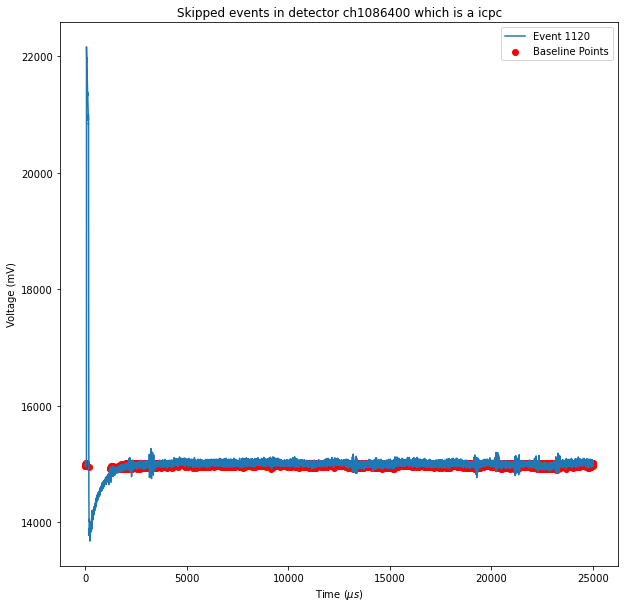

recovery rate 1207.2000000000003s
MICRODISCHARGE
Maximum difference: 164.8, 1256.8000000000002
Next Maximum difference: 49.6, 164.8


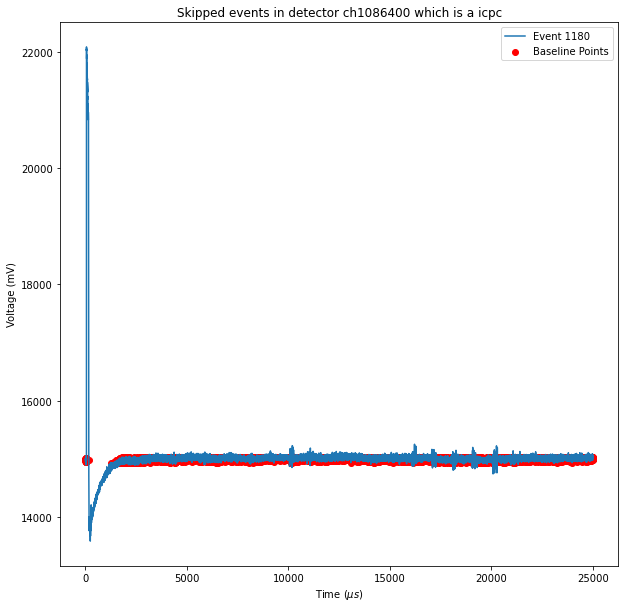

recovery rate 1764.8000000000002s
MICRODISCHARGE
Maximum difference: 164.0, 1814.4
Next Maximum difference: 49.6, 164.0


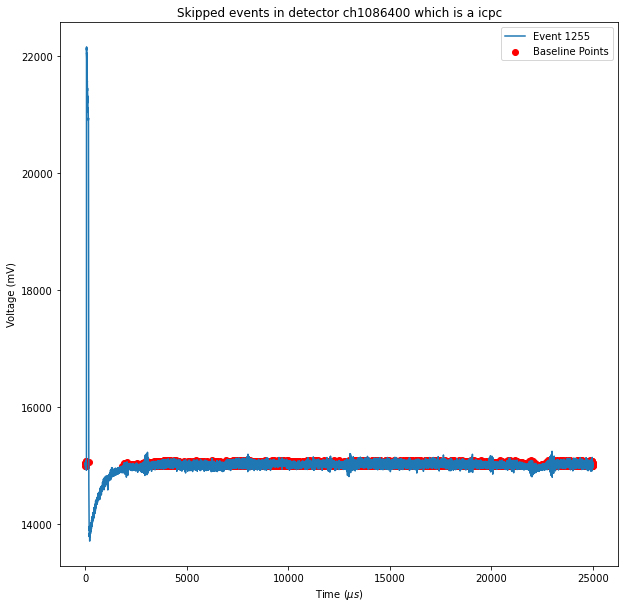

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 164.0, 2048.8
Next Maximum difference: 2048.8, 2232.8


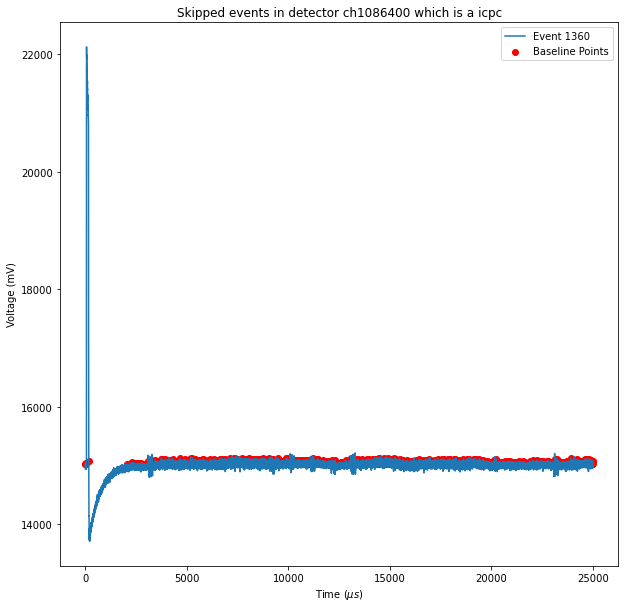

recovery rate 6036.800000000001s
MICRODISCHARGE
Maximum difference: 8643.2, 8971.2
Next Maximum difference: 2934.4, 3048.8


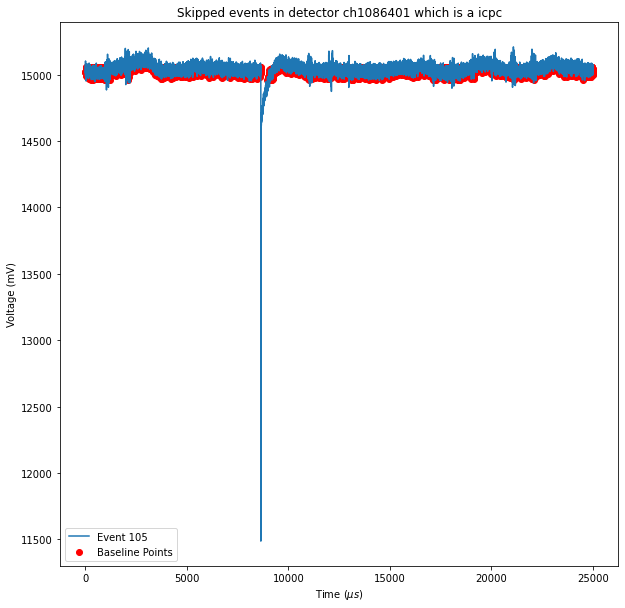

recovery rate 1570.4s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1570.4
Next Maximum difference: 49.6, 163.20000000000002


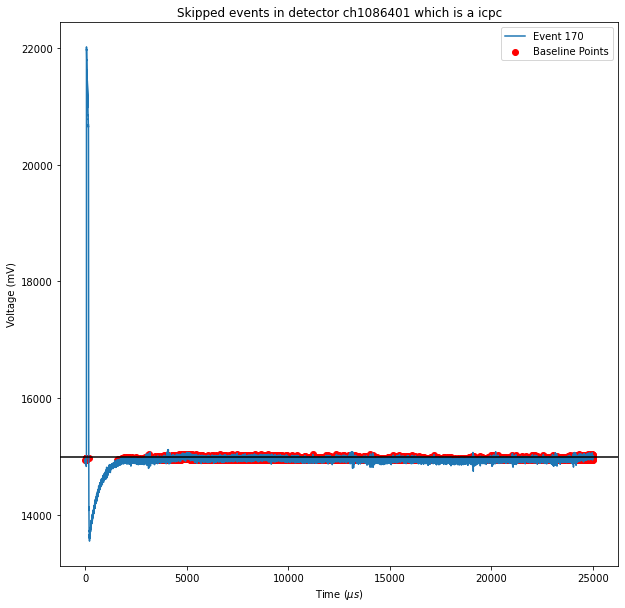

recovery rate 5070.400000000001s
DISCHARGE
Maximum difference: 517.6, 5070.400000000001
Next maximum difference: 5188.0, 5205.6


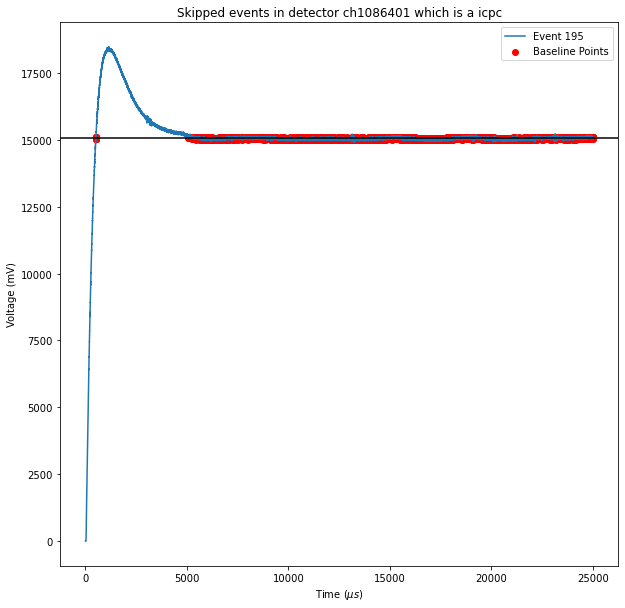

recovery rate 21259.2s
MICRODISCHARGE
Maximum difference: 19524.0, 21423.2
Next Maximum difference: 164.0, 1048.8


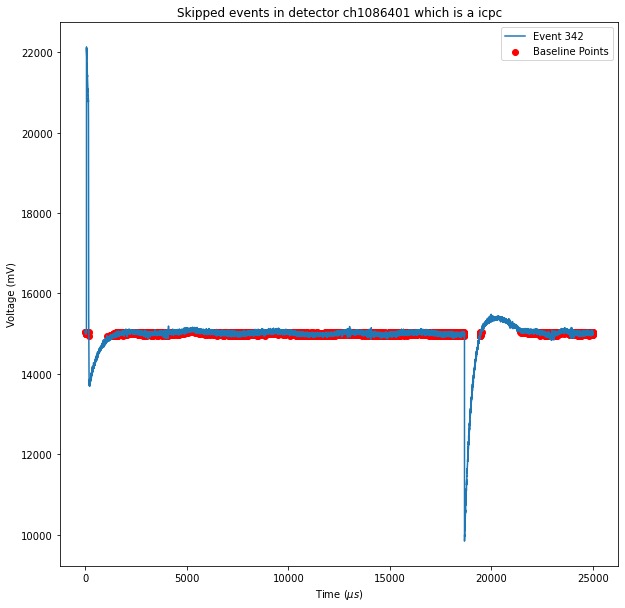

recovery rate 4844.0s
DISCHARGE
Maximum difference: 489.6, 4844.0
Next maximum difference: 4908.0, 5312.0


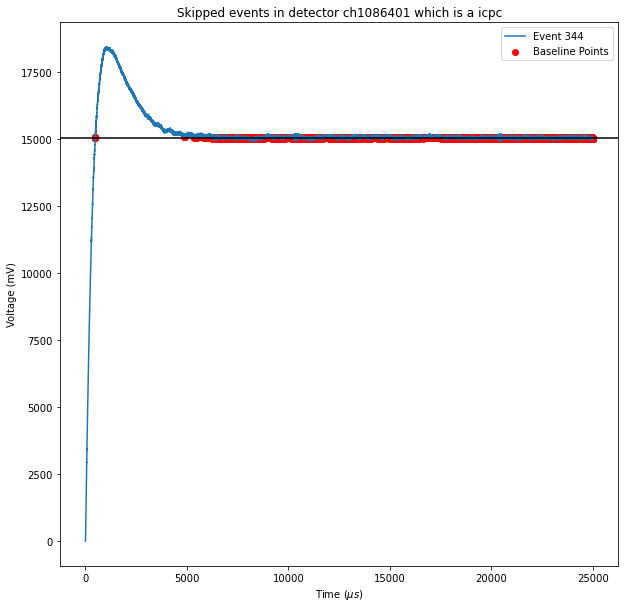

recovery rate 5104.8s
DISCHARGE
Maximum difference: 444.8, 5104.8
Next maximum difference: 5220.8, 5384.8


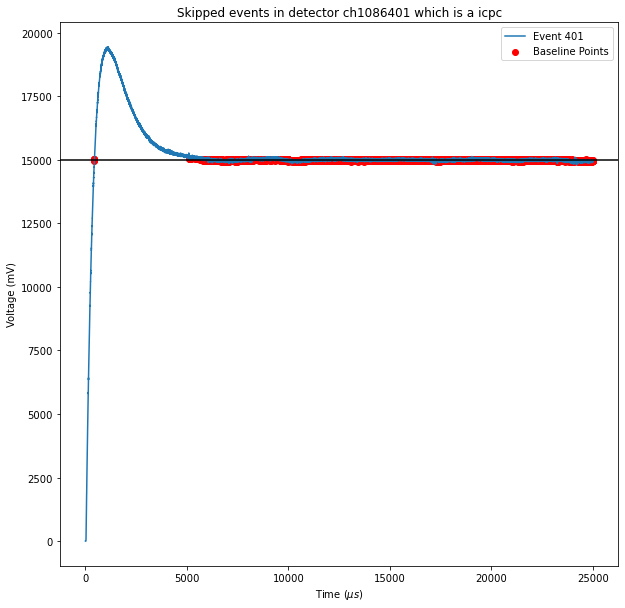

recovery rate 7640.8s
MICRODISCHARGE
Maximum difference: 6808.8, 7640.8
Next Maximum difference: 5622.400000000001, 6309.6


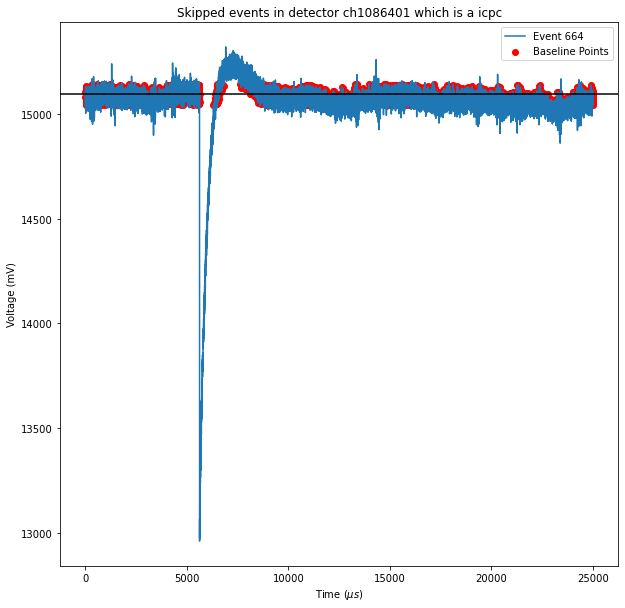

recovery rate 2830.4000000000005s
MICRODISCHARGE
Maximum difference: 5020.8, 6866.400000000001
Next Maximum difference: 4036.0, 4797.6


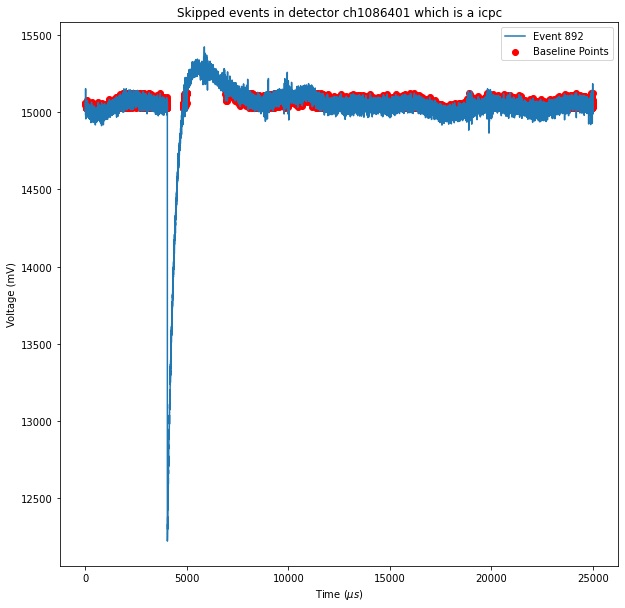

recovery rate 5438.400000000001s
DISCHARGE
Maximum difference: 388.0, 5438.400000000001
Next maximum difference: 5438.400000000001, 5503.200000000001


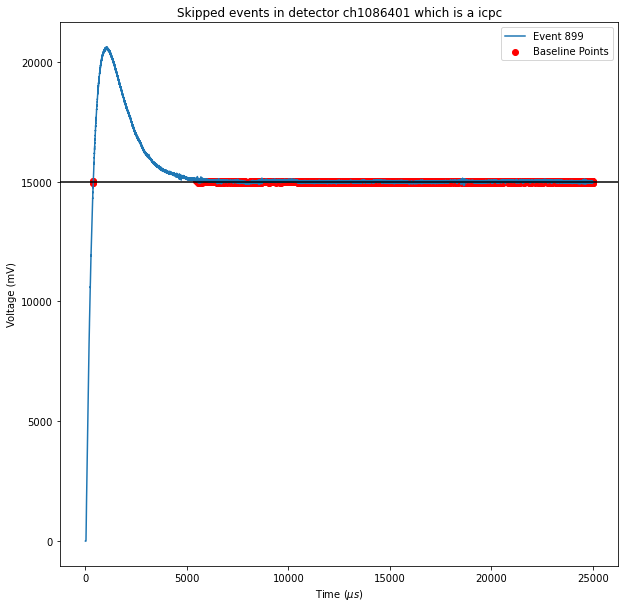

recovery rate 5772.8s
DISCHARGE
Maximum difference: 347.20000000000005, 5772.8
Next maximum difference: 6761.6, 7659.200000000001


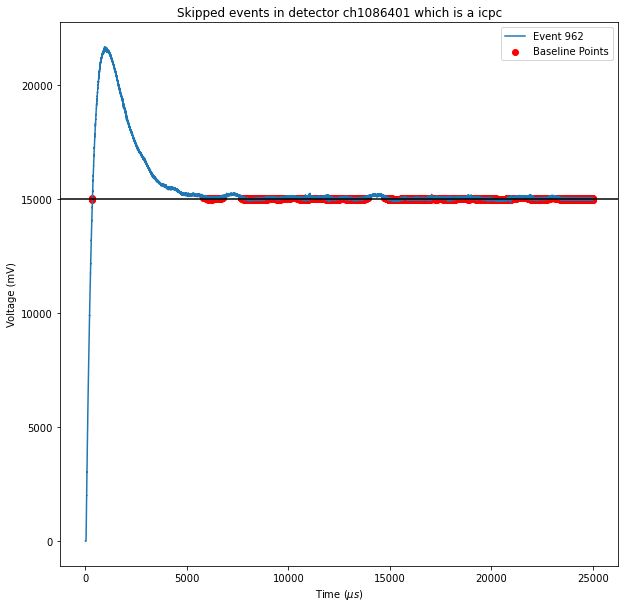

recovery rate 1876.000000000001s
MICRODISCHARGE
Maximum difference: 8026.400000000001, 9164.800000000001
Next Maximum difference: 7288.8, 7832.0


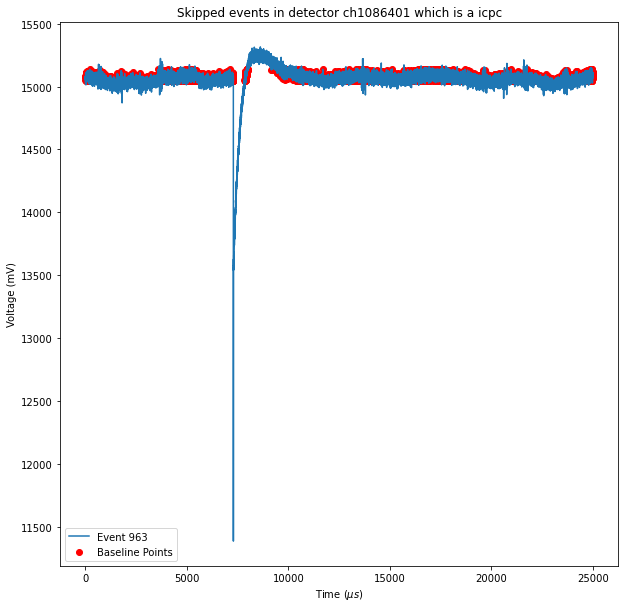

recovery rate 4800.0s
DISCHARGE
Maximum difference: 500.0, 4800.0
Next maximum difference: 5310.400000000001, 5937.6


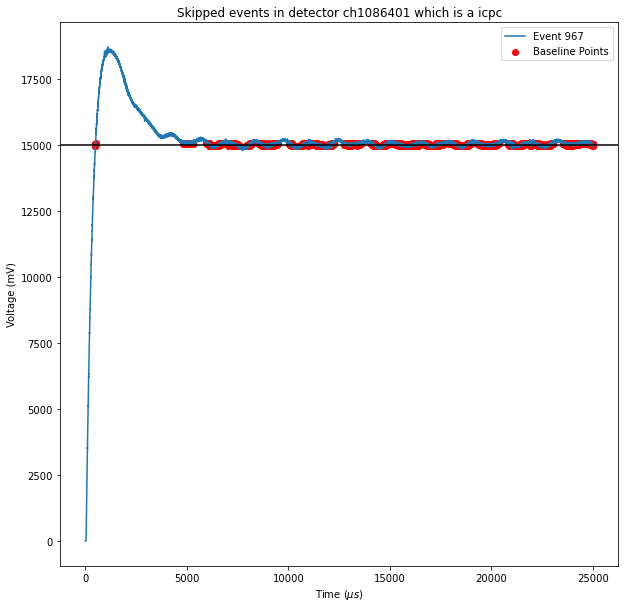

recovery rate -5123.200000000001s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1247.2
Next Maximum difference: 6370.400000000001, 6508.0


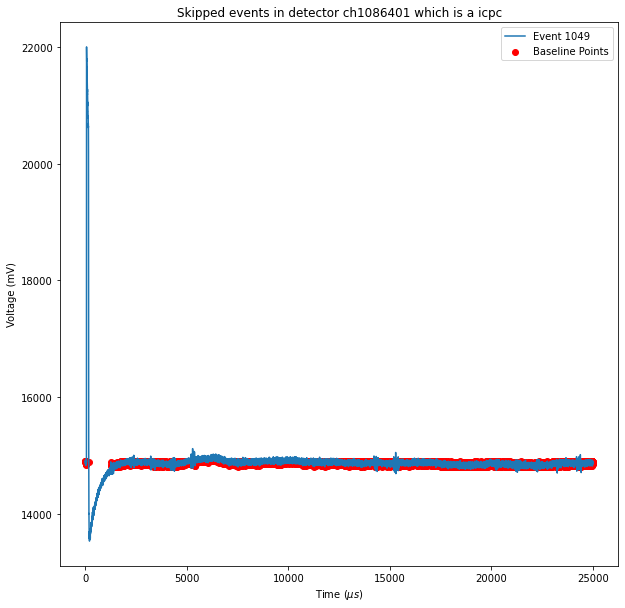

recovery rate 1368.8s
MICRODISCHARGE
Maximum difference: 164.0, 1416.0
Next Maximum difference: 47.2, 163.20000000000002


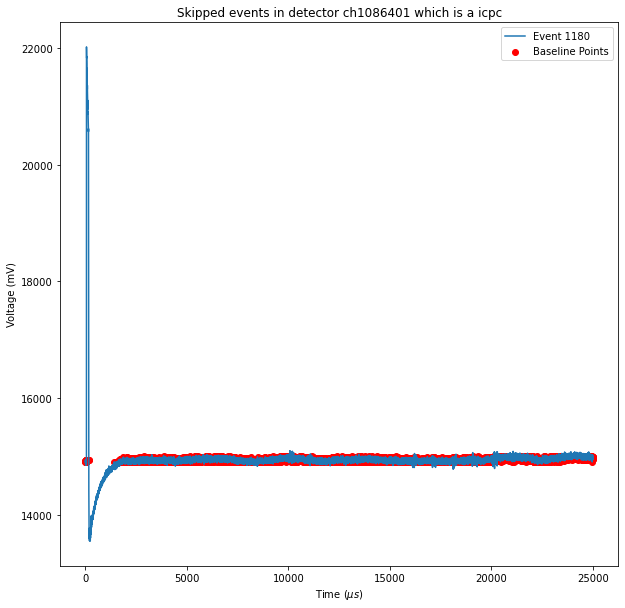

recovery rate 8514.4s
MICRODISCHARGE
Maximum difference: 6852.8, 8514.4
Next Maximum difference: 5913.6, 6604.0


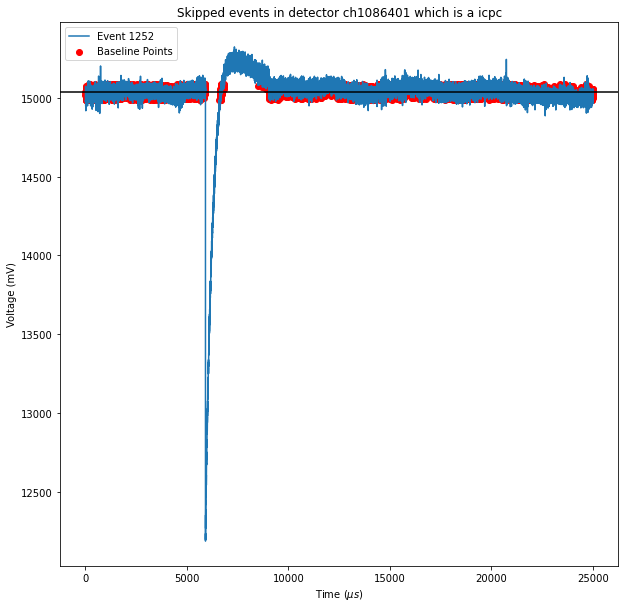

recovery rate 1959.199999999999s
MICRODISCHARGE
Maximum difference: 14760.0, 15701.6
Next Maximum difference: 13742.400000000001, 14441.6


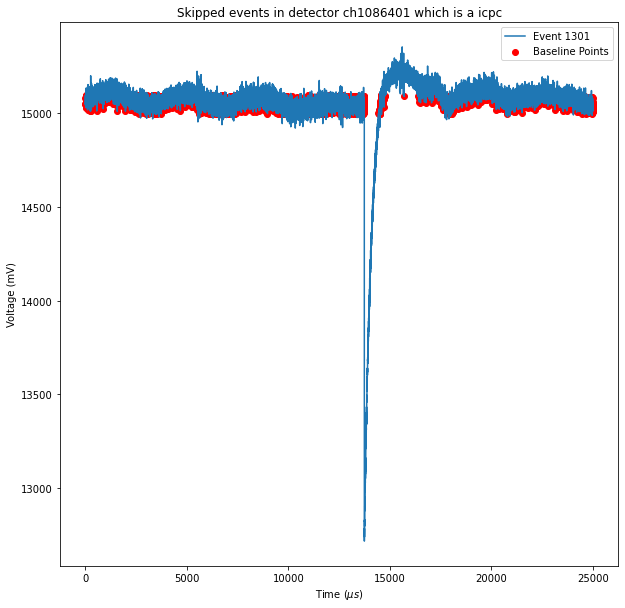

recovery rate 4825.6s
DISCHARGE
Maximum difference: 492.8, 4825.6
Next maximum difference: 4887.2, 4926.400000000001


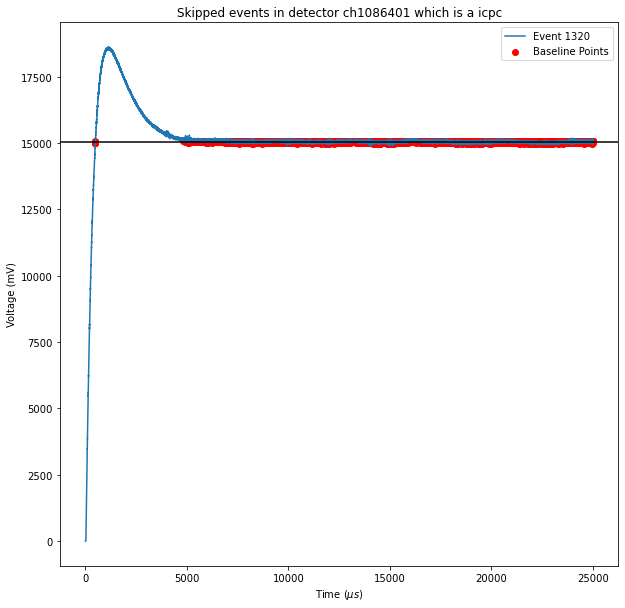

In [19]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate','Recovery Rate 2'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate','Recovery Rate 2'])


for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0) 
            
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}')
            
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if weighted_average-51 < q < weighted_average+51:
                    for_x.append(t)
                    for_append.append(q)

            
            plt.scatter(for_x, for_append, color='r', label='Baseline Points')
            #differences between points along the baseline
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:#if there is a gap in the baseline we have a discharge
                #where does the maximum difference occur 
                max_diff_index = np.argmax(x_diff)
                
                
                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))
                #where does the next maximum difference occur
                next_max_index = np.argmax(masked_data)

                # indices above are used to determine the x point where the maximum occurs 
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]
                # indices above are used to determine the x point where the next maximum occurs
                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
               
                #if at t=0 the waveform is below the baseline
                # the recovery rate is as follows 
                if (wf0[0]<weighted_average-51):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else:#otherwise the recovery rate is as follows
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                    
                #--------------------------------------------------
                #ONLY KEY DIFFERENCE BETWEEN OTHER RECOVERY RATE NOTEBOOK 
                
                #if the recovery rate is negative or 0 this is a sign of a different shaped
                #dicsharge event
                if rec_rate<=0:
                    rec_rate = 0
                    rec_rate_2 = max_diff_x2-max_diff_x1
                
                #---------------------------------------------------
                
                #if at any point the waveform = 0 it is a discharge event 
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate,
                        'Recovery Rate 2': rec_rate_2,
                    }, ignore_index=True)                    
                else:#if at any point ≠ 0 it is a microdischarge event
                    discharge_type = "microdischarge"
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate,
                        'Recovery Rate 2': rec_rate_2,
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")

            
            # Customize plot
            #plt.axhline(y=mean_y,color='lawngreen')
            #plt.axhline(y=weighted_average,color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [20]:
excel_filename = 'discharge_icpc.xlsx'
df.to_excel(excel_filename, index=False)

excel_filename1 = 'microdischarge_icpc.xlsx'
df1.to_excel(excel_filename1, index=False)